In [520]:
library("dplyr")
library('MatchIt')
library("marginaleffects")
library('tidyr')
library('ggplot2')
library('fixest')

In [521]:
source("matching.r")

In [524]:
df_pretreat_metrics <- read.csv('data/experiment/complete-regression-df-mindays-minute.csv')

In [506]:
df_week_data <- read.csv('data/experiment/did-weeks-bugfix.csv')


In [48]:
df_day_data <- read.csv('data/experiment/did-days-bugfix.csv')

In [528]:
target <- c("rfpp-protected", "rfpp-declined")
df_exp <- filter(df_pretreat_metrics, type %in% target)
df_exp <- filter(df_exp, year_of_request>= 2012 & year_of_request < 2023)
df_exp$treated <- df_exp$type == 'rfpp-protected'
df_exp$is_HandS <- df_exp$is_HandS == 'True'
df_exp$is_Geo <- df_exp$is_Geo== 'True'
df_exp$is_Culture <- df_exp$is_Culture== 'True'
df_exp$is_STEM <- df_exp$is_STEM == 'True'

In [7]:
weekly_revs_around <- df_week_data %>%
  filter(between(request_diff_week, -1, 0)) %>%
  group_by(treated_id, request_diff_week) %>%
  summarize(revisions = sum(revisions)) %>%
  group_by(treated_id) %>%
  filter(all(revisions >= 1))

`summarise()` has grouped output by 'treated_id'. You can override using the
`.groups` argument.


In [8]:
df_filtered_minrevs_around <- filter(df_exp, treated_id %in% weekly_revs_around$treated_id)
table(df_filtered_minrevs_around$type)


 rfpp-declined rfpp-protected 
          4544          25569 

In [9]:
weekly_revs_before_protection <- df_week_data %>%
          filter(request_diff_week < 0& request_diff_week >= -1) %>%
          group_by(treated_id) %>%
          summarize(revisions = sum(revisions)) %>%
          filter(revisions >= 1)
df_filtered_minrevs_before <- filter(df_exp, treated_id %in% weekly_revs_before_protection$treated_id)
print(table(df_filtered_minrevs_before$type))

weekly_revs_after_protection <- df_week_data %>%
          filter(request_diff_week >= 0& request_diff_week < 1) %>%
          group_by(treated_id) %>%
          summarize(revisions = sum(revisions)) %>%
          filter(revisions >= 1)
df_filtered_minrevs_after <- filter(df_exp, treated_id %in% weekly_revs_after_protection$treated_id)
df_filtered_minrevs <- filter(df_filtered_minrevs_before,
                              treated_id %in% df_filtered_minrevs_after$treated_id)

print(table(df_filtered_minrevs$type))
print(table(df_exp$type))


 rfpp-declined rfpp-protected 
          6163          25580 

 rfpp-declined rfpp-protected 
          4544          25569 

 rfpp-declined rfpp-protected 
          6591          25617 


In [508]:
norm_minmax <- function(x){(x- min(x)) /(max(x)-min(x))}
norm_std <- function(values) {(values - mean(values)) / sd(values)}

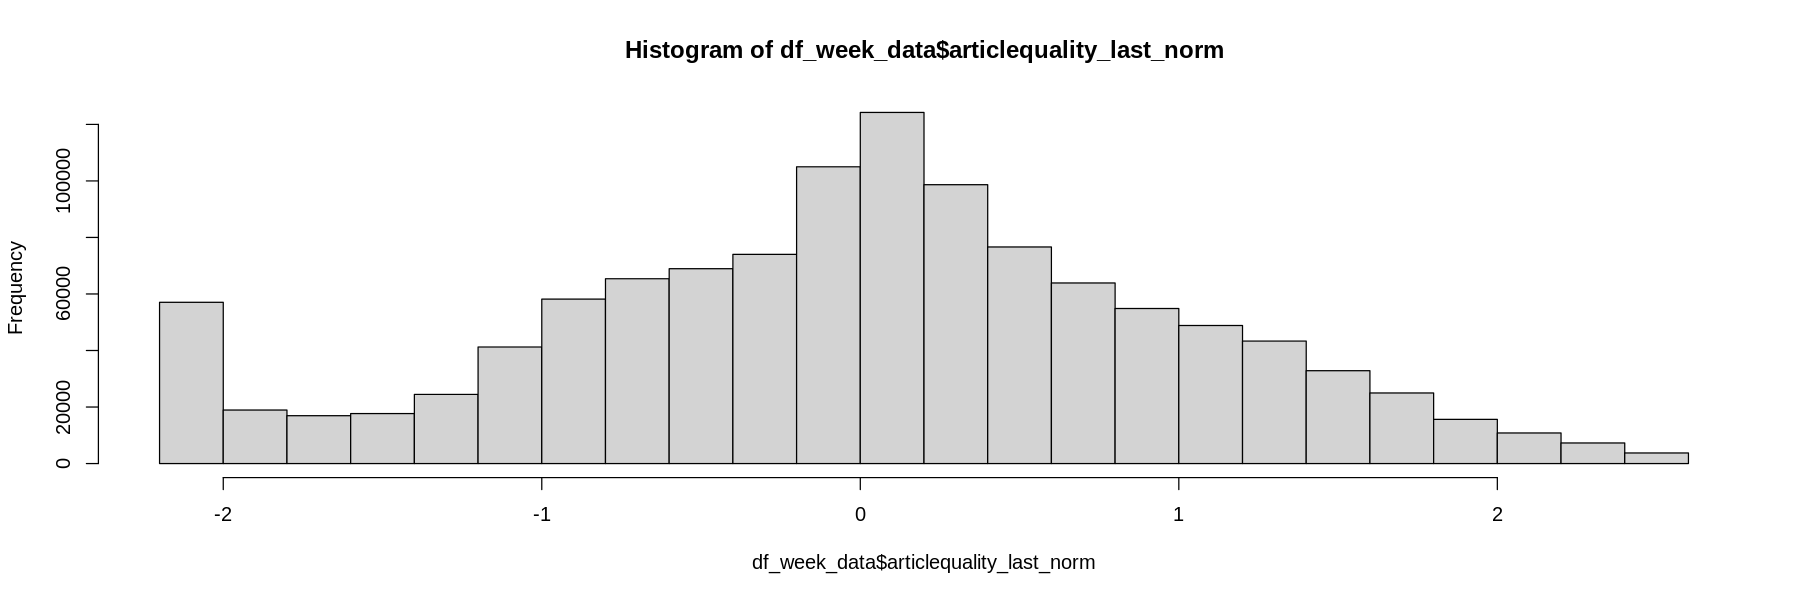

In [323]:
hist(df_week_data$articlequality_last_norm)

In [509]:
df_week_data$articlequality_last_log<- log(df_week_data$articlequality_last)
df_week_data$articlequality_last_norm <- norm_std(df_week_data$articlequality_last)
df_week_data$page_size_last_log <- log1p(df_week_data$page_size_last)
df_week_data$page_size_max_log <- log1p(df_week_data$page_size_max)

df_week_data$articlequality_last_perc <- df_week_data$articlequality_last / df_week_data$Q_score_last_m1

In [429]:
df_day_data$articlequality_last_log<- log(df_day_data$articlequality_last)
df_day_data$articlequality_last_norm <- norm_minmax(df_day_data$articlequality_last)
df_day_data$page_size_last_log <- log1p(df_day_data$page_size_last)
#df_day_data$articlequality_last_perc <- df_day_data$articlequality_last / df_day_data$Q_score_last_m1

In [529]:
df_exp$revisions_productive_1H_log <- log1p(df_exp$revisions_productive_1H)
df_exp$revisions_productive_24H_log <- log1p(df_exp$revisions_productive_24H)
df_exp$revisions_productive_168H_log <- log1p(df_exp$revisions_productive_168H)
df_exp$identity_reverts_1H_log <- log1p(df_exp$revisions_productive_1H)
df_exp$identity_reverts_24H_log <- log1p(df_exp$revisions_productive_24H)
df_exp$identity_reverts_168H_log <- log1p(df_exp$revisions_productive_168H)
df_exp$Max_revision_text_bytes_log <- log1p(df_exp$Max_revision_text_bytes)
df_exp$page_age_log <- log1p(df_exp$page_age)
df_exp$page_size_log <- log1p(df_exp$Max_revision_text_bytes)

df_filtered_minrevs <- filter(df_exp, treated_id %in% df_filtered_minrevs$treated_id)

In [530]:
formula_ext <- treated ~ revisions_productive_1H_log  + revisions_productive_24H_log  + revisions_productive_168H_log +
                     identity_reverts_24H_log + identity_reverts_1H_log  + identity_reverts_168H_log +
                     Max_revision_text_bytes_log + page_age_log

In [531]:
m.out.ex.ps_last <- matchit(formula_ext, data = df_exp, method='nearest', 
                       exact=~is_HandS + is_Geo + is_STEM + is_Culture,
                       caliper=c(1, Q_score_last_m21=.25, Q_score_last_m8=.25, Q_score_last_m1=.25),
                       std.caliper = c(TRUE, FALSE, FALSE, FALSE), 
                       replace = TRUE)
options(repr.plot.width = 15, repr.plot.height = 5)
paired_matches_last <- get_matches(m.out.ex.ps_last)
plot(summary(m.out.ex.ps_last, var.order="unmatched"))
plot(m.out.ex.ps_last, type = "jitter", interactive = FALSE)
summary(m.out.ex.ps_last, var.order="unmatched")

In [ ]:
m.out.ex.ps_max <- matchit(formula_ext, data = df_exp, method='nearest', 
                       exact=~is_HandS + is_Geo + is_STEM + is_Culture,
                       caliper=c(1, Q_score_max_m21=.25, Q_score_max_m8=.25, Q_score_max_m1=.25),
                       std.caliper = c(TRUE, FALSE, FALSE, FALSE), 
                       replace = TRUE)
options(repr.plot.width = 15, repr.plot.height = 5)
paired_matches_max <- get_matches(m.out.ex.ps_max)
plot(summary(m.out.ex.ps_max, var.order="unmatched"))
plot(m.out.ex.ps_max, type = "jitter", interactive = FALSE)
summary(m.out.ex.ps_max, var.order="unmatched")

In [349]:
m.out.ex.ps_5 <- matchit(formula_ext, data = df_exp, method='nearest', 
                       exact=~is_HandS + is_Geo + is_STEM + is_Culture,
                       caliper=c(1, Q_score_max_m21=.5, Q_score_max_m8=.5, Q_score_max_m1=.5),
                       std.caliper = c(TRUE, FALSE, FALSE, FALSE), 
                       replace = TRUE)
options(repr.plot.width = 15, repr.plot.height = 5)
paired_matches_5 <- get_matches(m.out.ex.ps_5)
#plot(summary(m.out.ex.ps_closer, var.order="unmatched"))
#plot(m.out.ex.ps_closer, type = "jitter", interactive = FALSE)
#summary(m.out.ex.ps_closer, var.order="unmatched")

In [293]:
m.out.ex.ps_1 <- matchit(formula_ext, data = df_exp, method='nearest', 
                       exact=~is_HandS + is_Geo + is_STEM + is_Culture,
                       caliper=c(1, Q_score_max_m21=.1, Q_score_max_m8=.1, Q_score_max_m1=.1),
                       std.caliper = c(TRUE, FALSE, FALSE, FALSE), 
                       replace = TRUE)
options(repr.plot.width = 15, repr.plot.height = 5)
paired_matches_1 <- get_matches(m.out.ex.ps_1)
#plot(summary(m.out.ex.ps_closer, var.order="unmatched"))
#plot(m.out.ex.ps_closer, type = "jitter", interactive = FALSE)
#summary(m.out.ex.ps_closer, var.order="unmatched")

In [532]:
m.out.ex.ps <- matchit(formula_ext, data = df_exp, method='nearest', 
                       exact=~is_HandS + is_Geo + is_STEM + is_Culture,
                       caliper=c(1, Q_score_max_m21=.25, Q_score_max_m8=.25, Q_score_max_m1=.25),
                       std.caliper = c(TRUE, FALSE, FALSE, FALSE), 
                       replace = TRUE)
options(repr.plot.width = 15, repr.plot.height = 5)
paired_matches <- get_matches(m.out.ex.ps)


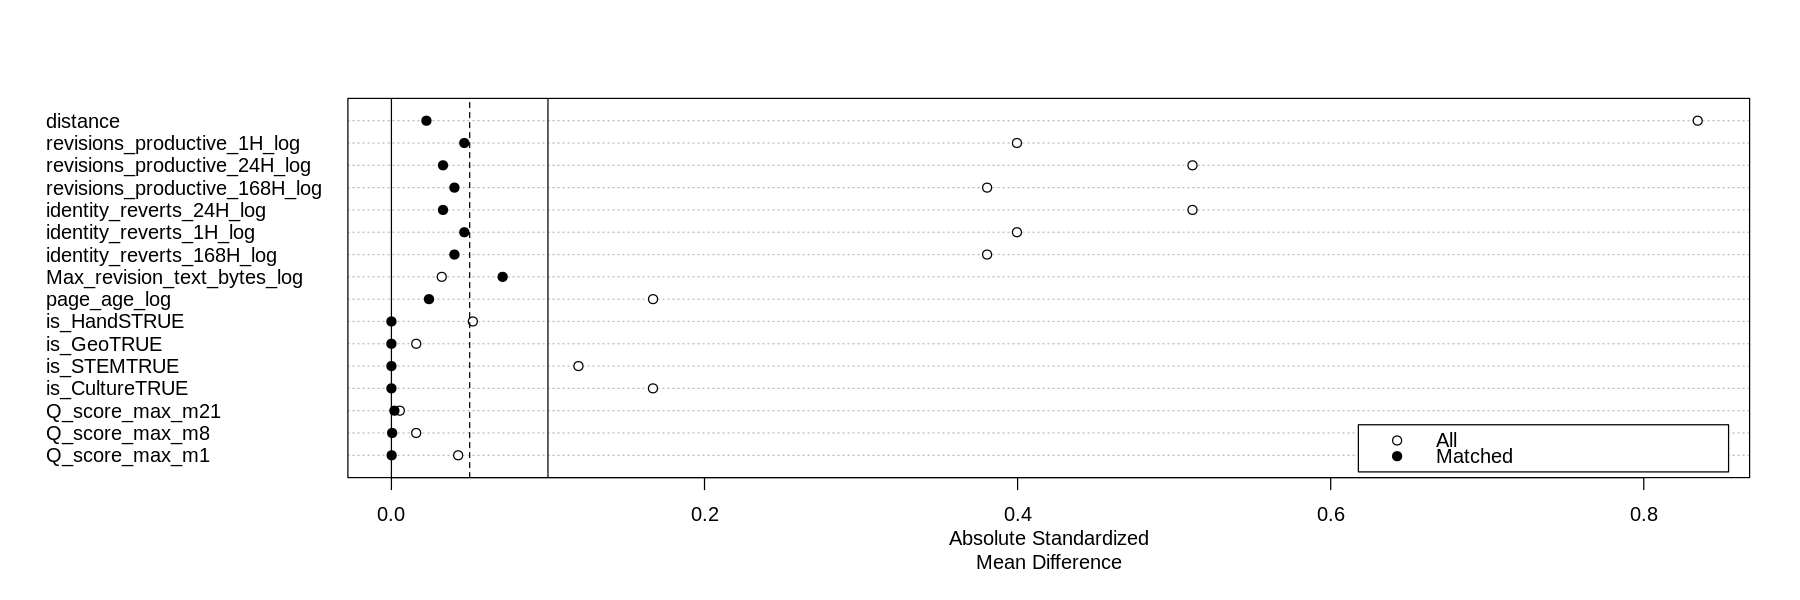


Call:
matchit(formula = formula_ext, data = df_exp, method = "nearest", 
    exact = ~is_HandS + is_Geo + is_STEM + is_Culture, replace = TRUE, 
    caliper = c(1, Q_score_max_m21 = 0.25, Q_score_max_m8 = 0.25, 
        Q_score_max_m1 = 0.25), std.caliper = c(TRUE, FALSE, 
        FALSE, FALSE))

Summary of Balance for All Data:
                              Means Treated Means Control Std. Mean Diff.
distance                             0.8144        0.7214          0.8344
revisions_productive_1H_log          0.8706        0.4952          0.3996
revisions_productive_24H_log         1.3612        0.7773          0.5117
revisions_productive_168H_log        1.4871        1.0081          0.3805
identity_reverts_24H_log             1.3612        0.7773          0.5117
identity_reverts_1H_log              0.8706        0.4952          0.3996
identity_reverts_168H_log            1.4871        1.0081          0.3805
Max_revision_text_bytes_log          9.6438        9.6110          0.0322
pa

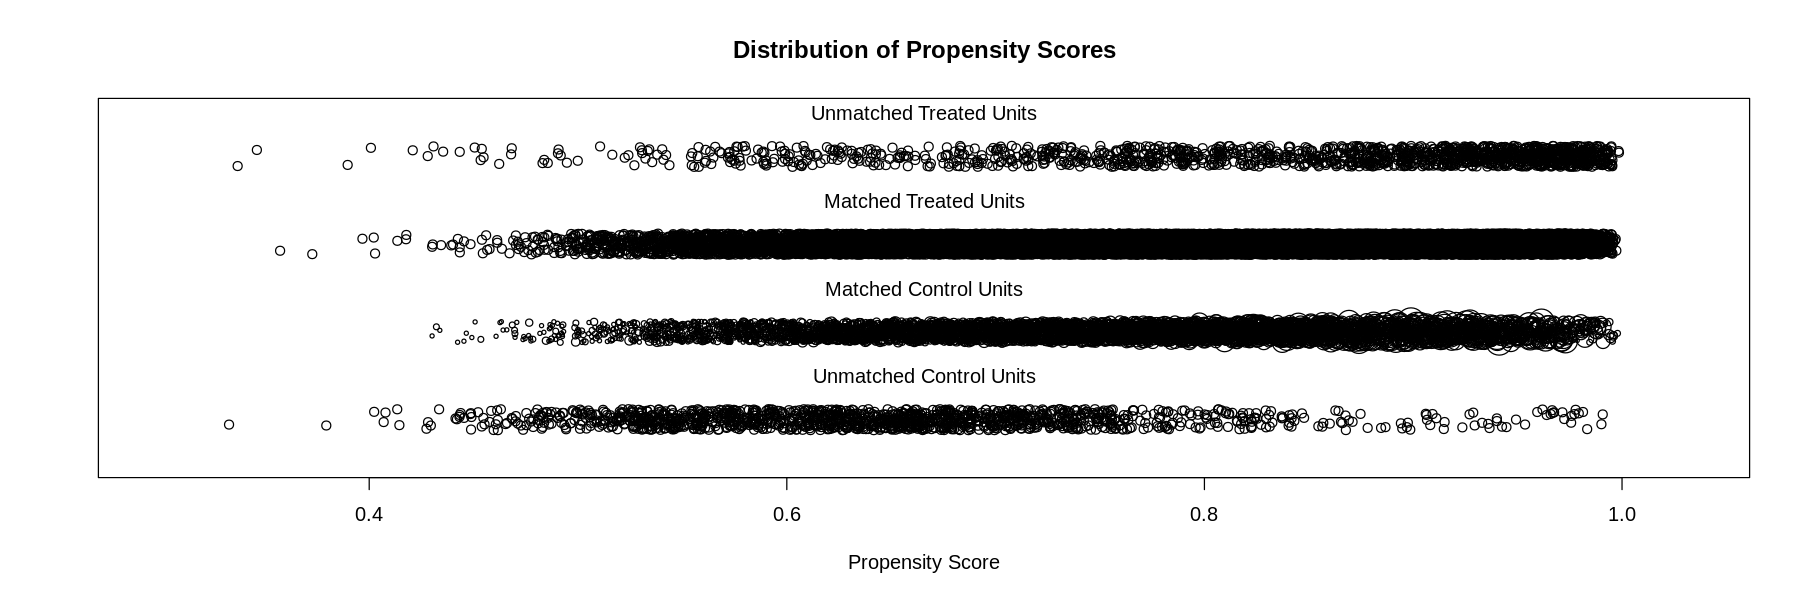

In [533]:
plot(summary(m.out.ex.ps, var.order="unmatched"))
plot(m.out.ex.ps, type = "jitter", interactive = FALSE)
summary(m.out.ex.ps, var.order="unmatched")

In [537]:
write.csv(paired_matches, 'data/experiment/pairs-final.csv')

In [536]:
names(df_exp)

[1] "treated_id"                    "Q_score_max_m28"              
 [3] "Q_score_max_m22"               "Q_score_max_m21"              
 [5] "Q_score_max_m15"               "Q_score_max_m14"              
 [7] "Q_score_max_m13"               "Q_score_max_m12"              
 [9] "Q_score_max_m11"               "Q_score_max_m10"              
[11] "Q_score_max_m9"                "Q_score_max_m8"               
[13] "Q_score_max_m7"                "Q_score_max_m6"               
[15] "Q_score_max_m5"                "Q_score_max_m4"               
[17] "Q_score_max_m3"                "Q_score_max_m2"               
[19] "Q_score_max_m1"                "Q_score_last_m28"             
[21] "Q_score_last_m22"              "Q_score_last_m21"             
[23] "Q_score_last_m15"              "Q_score_last_m14"             
[25] "Q_score_last_m13"              "Q_score_last_m12"             
[27] "Q_score_last_m11"              "Q_score_last_m10"             
[29] "Q_score_last_m9"               "Q_score_last_m8"              
[31] "Q_score_last_m7"               "Q_score_last_m6"              
[33] "Q_score_last_m5"               "Q_score_last_m4"              
[35] "Q_score_last_m3"               "Q_score_last_m2"              
[37] "Q_score_last_m1"               "type"                         
[39] "request_timestamp"             "duration_days"                
[41] "revisions_productive_168H"     "revisions_productive_1H"      
[43] "revisions_productive_24H"      "identity_reverts_168H"        
[45] "identity_reverts_1H"           "identity_reverts_24H"         
[47] "is_STEM"                       "is_Culture"                   
[49] "is_HandS"                      "is_Geo"                       
[51] "Q_score"                       "Max_revision_text_bytes"      
[53] "page_age"                      "day_of_request"               
[55] "week_of_request"               "year_of_request"              
[57] "Topics"                        "Q_score_quantile"             
[59] "Max_revision_text_bytes_log"   "page_size_quantile"           
[61] "treated"                       "revisions_productive_1H_log"  
[63] "revisions_productive_24H_log"  "revisions_productive_168H_log"
[65] "identity_reverts_1H_log"       "identity_reverts_24H_log"     
[67] "identity_reverts_168H_log"     "page_age_log"                 
[69] "page_size_log"

# DiD Computations

In [267]:
source('matching.r')
library('fwildclusterboot')

In [519]:
head(df_matched_data_w[c('treated', 'request_diff_week', 'treated_id')])

treated request_diff_week treated_id
1 TRUE     6                53838     
2 TRUE    13                53838     
3 TRUE    -3                53838     
4 TRUE    -9                53838     
5 TRUE    -8                53838     
6 TRUE    11                53838

In [319]:

df_matched_data_w_5 <- merge_pairs_with_did(paired_matches_5, df_week_data)
data_sets_weekly_5 <- create_dataset_by_duration_labels(df_matched_data_w_5, show_plots=FALSE, target_var='articlequality_last_norm')

df_matched_data_w_1 <- merge_pairs_with_did(paired_matches_1, df_week_data)
data_sets_weekly_1 <- create_dataset_by_duration_labels(df_matched_data_w_1, show_plots=FALSE, target_var='articlequality_last_norm')

Retrieve protection with duration ( Protected for 07 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 01-06 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 08-92 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 01-06 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 08-92 Days ) and topic ( ) and quality ( )


Retrieve protection with duration ( Protected for 07 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 01-06 Days ) and topic ( ) and quality ( )


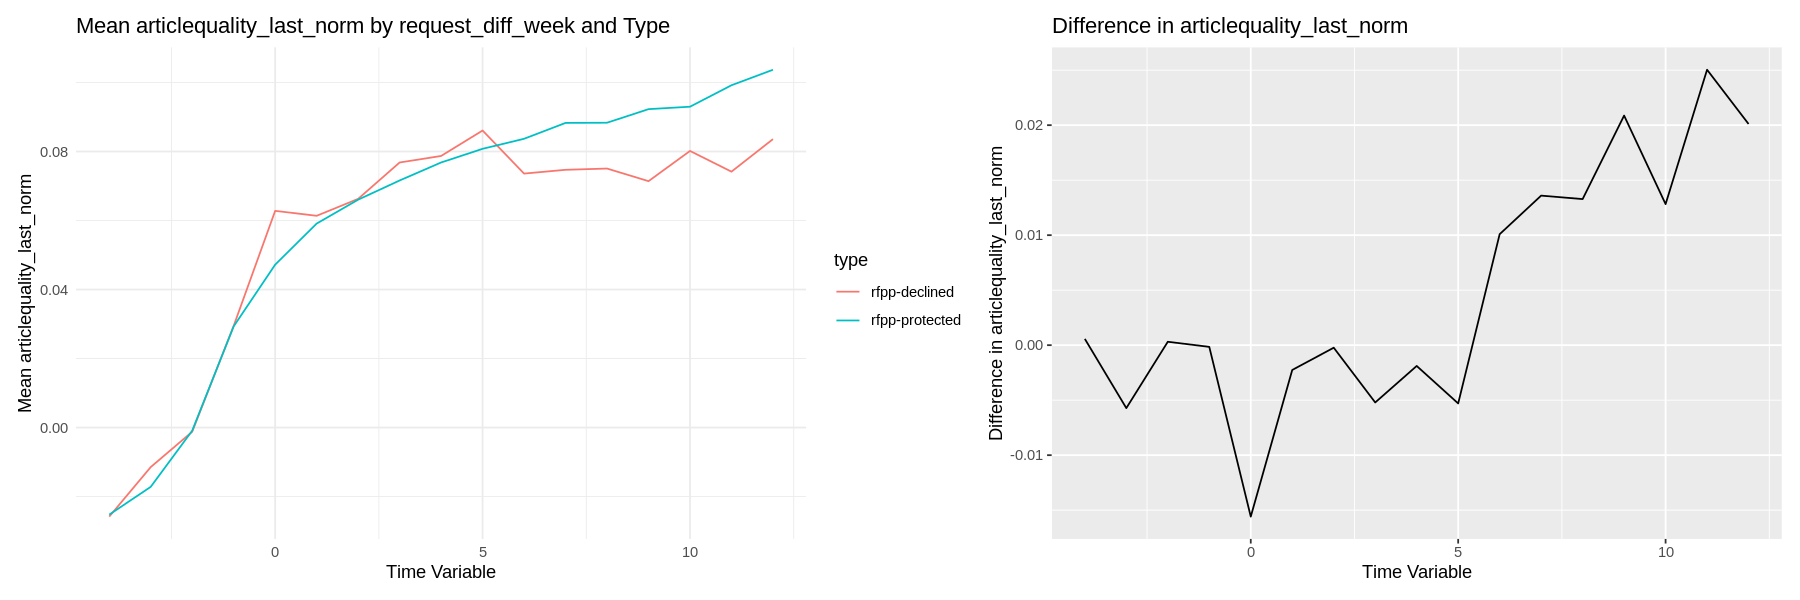

Retrieve protection with duration ( Protected for 08-92 Days ) and topic ( ) and quality ( )


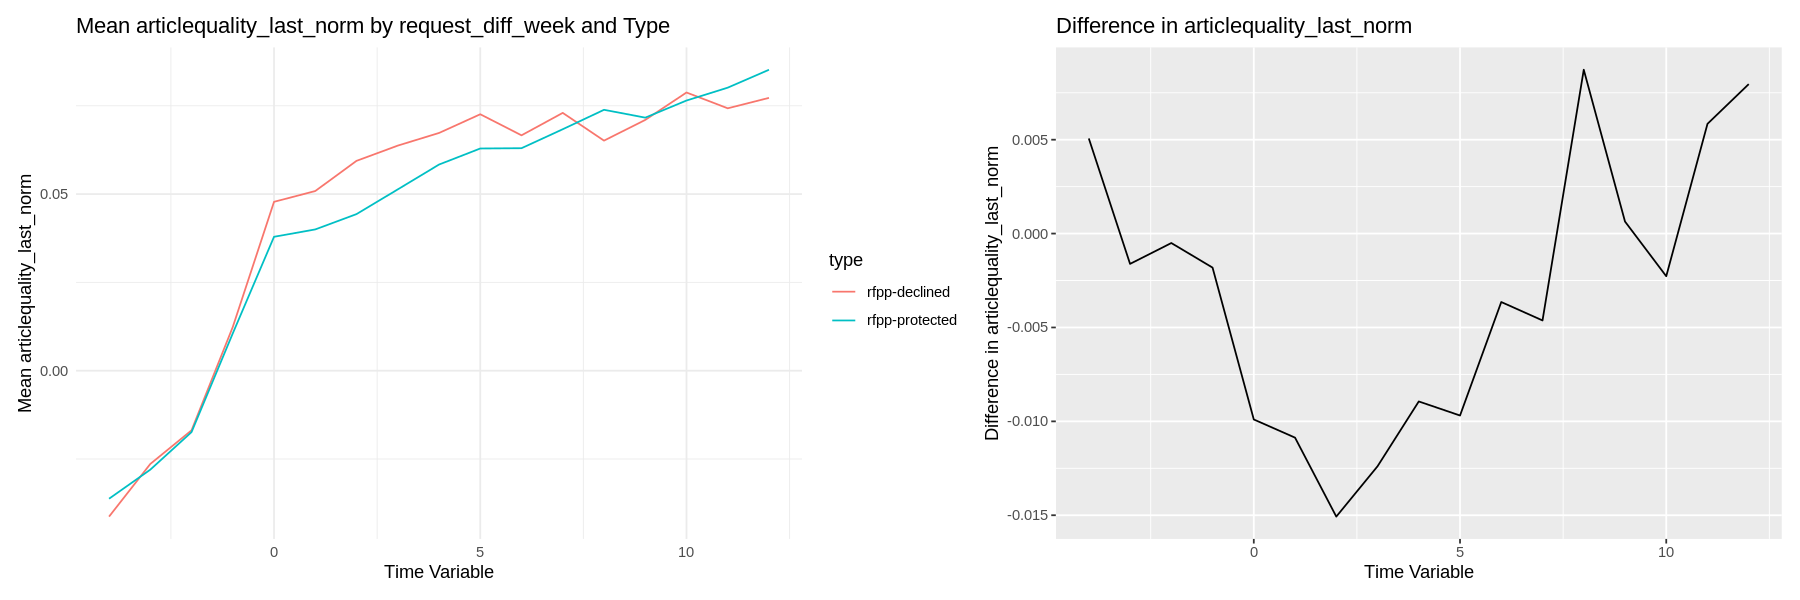

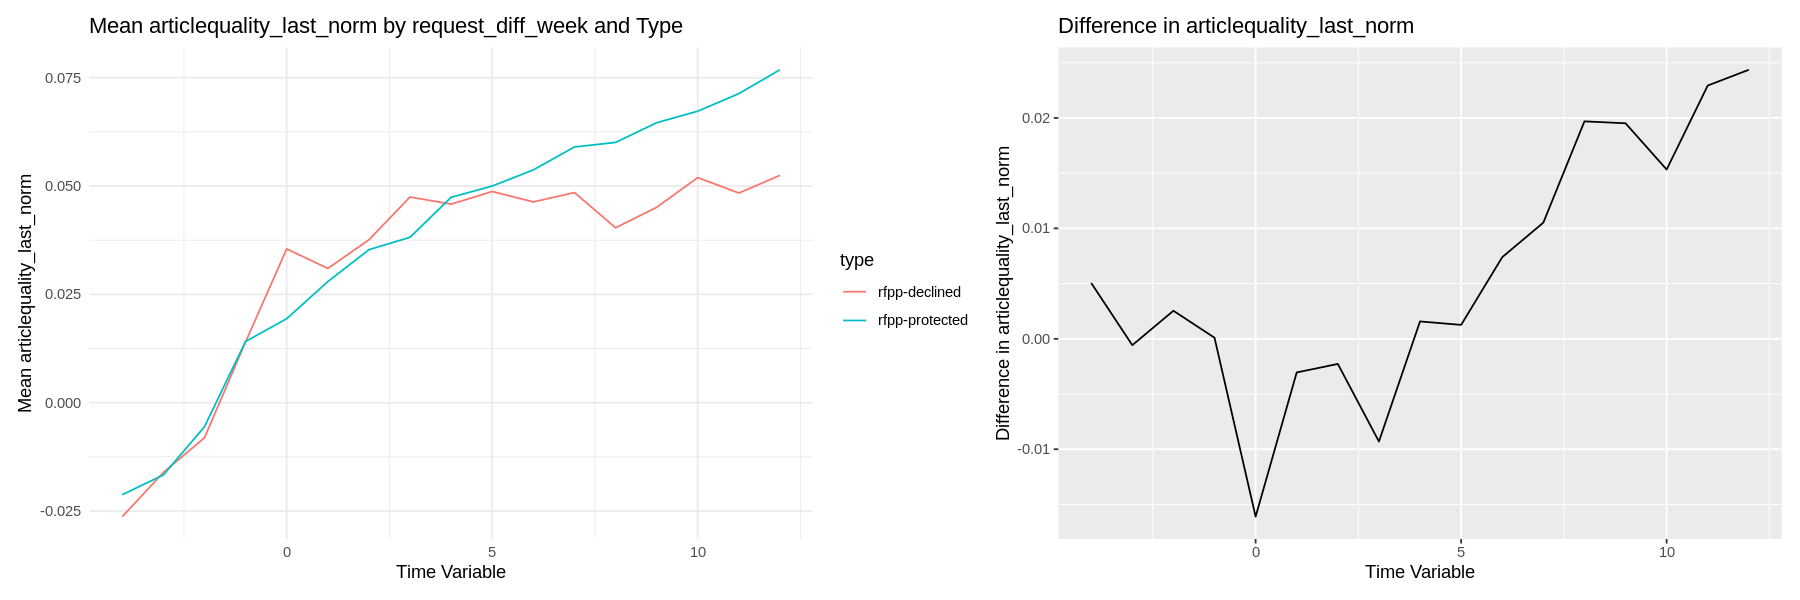

In [480]:
df_matched_data_w_last <- merge_pairs_with_did(paired_matches_last, df_week_data)
data_sets_weekly_last <- create_dataset_by_duration_labels(df_matched_data_w_last, show_plots=TRUE, target_var='articlequality_last_norm')

Retrieve protection with duration ( Protected for 07 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 01-06 Days ) and topic ( ) and quality ( )


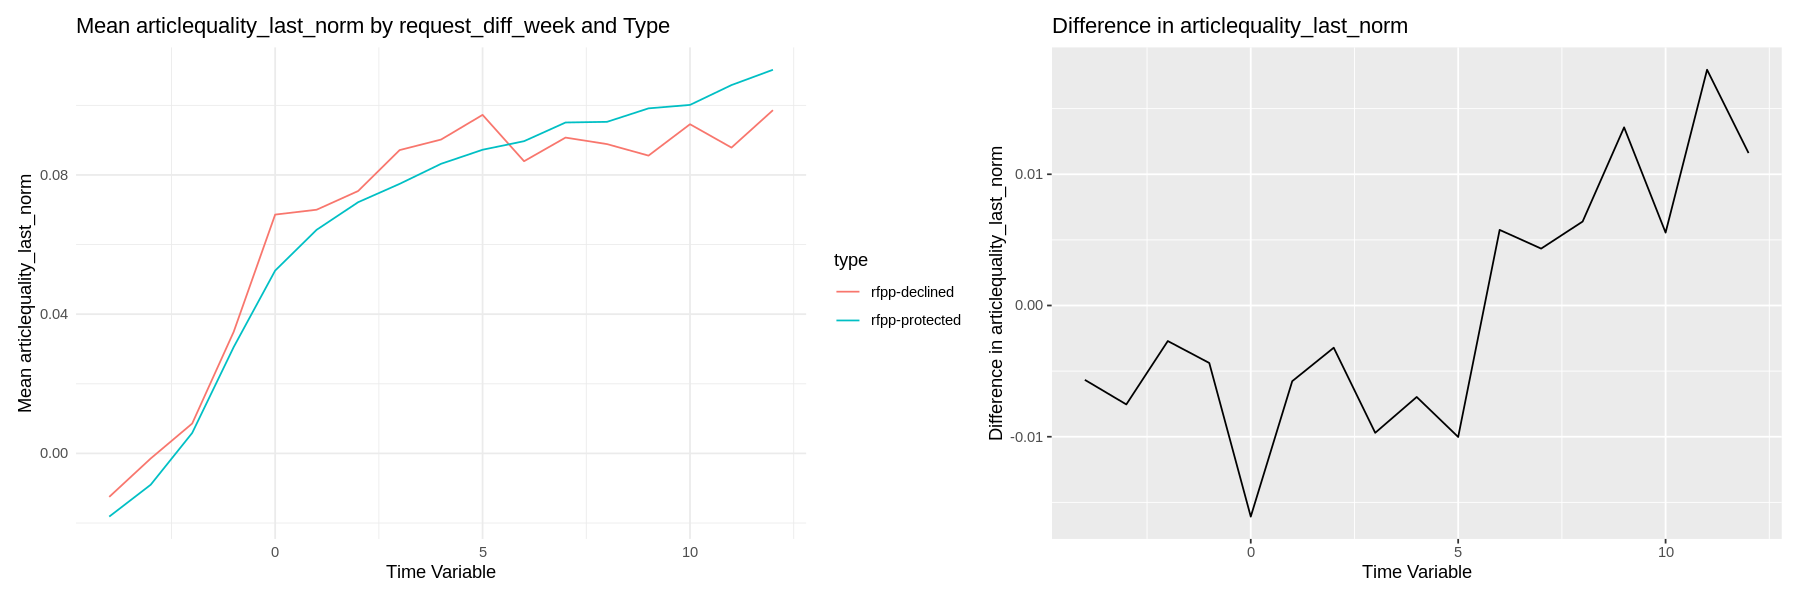

Retrieve protection with duration ( Protected for 08-92 Days ) and topic ( ) and quality ( )


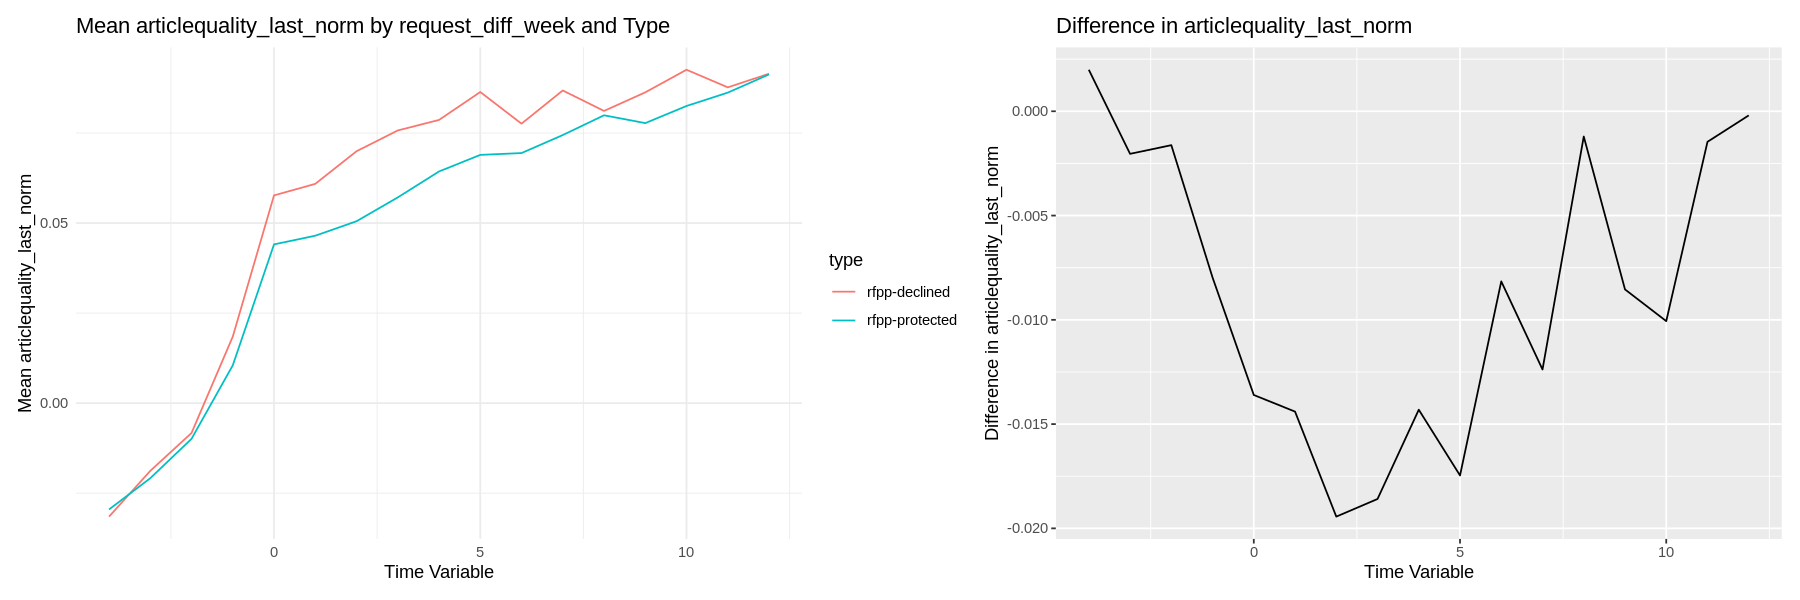

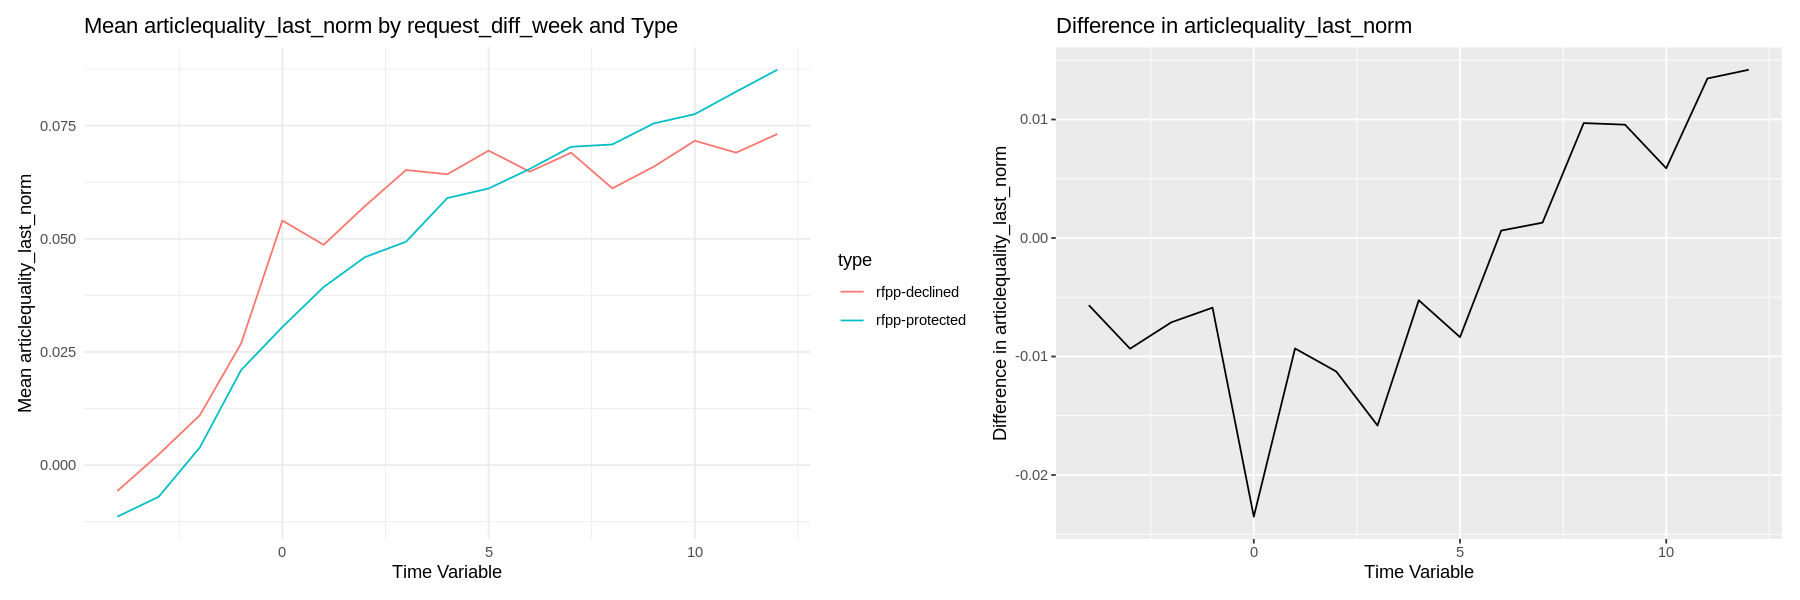

In [499]:
df_matched_data_w <- merge_pairs_with_did(paired_matches, df_week_data)
data_sets_weekly <- create_dataset_by_duration_labels(df_matched_data_w, show_plots=TRUE, target_var='articlequality_last_norm')

In [473]:
etable(did_weekly_high)

Protected for 08-92 Days
1  Dependent Var.:                  articlequality_last_norm
2                                                           
3  treated x request_diff_week = -4 -0.0144 (0.0155)        
4  treated x request_diff_week = -3 -0.0203 (0.0155)        
5  treated x request_diff_week = -2 -0.0139 (0.0152)        
6  treated x request_diff_week = 0  -0.0059 (0.0140)        
7  treated x request_diff_week = 1  0.0329* (0.0148)        
8  treated x request_diff_week = 2  0.0240. (0.0138)        
9  treated x request_diff_week = 3  0.0086 (0.0148)         
10 treated x request_diff_week = 4  0.0378* (0.0152)        
11 treated x request_diff_week = 5  0.0367* (0.0153)        
12 treated x request_diff_week = 6  0.0487*** (0.0148)      
13 treated x request_diff_week = 7  0.0462*** (0.0140)      
14 treated x request_diff_week = 8  0.0621*** (0.0152)      
15 treated x request_diff_week = 9  0.0488** (0.0153)       
16 treated x request_diff_week = 10 0.0407** (0.0143)       
17 treated x request_diff_week = 11 0.0577*** (0.0156)      
18 treated x request_diff_week = 12 0.0456** (0.0143)       
19 Fixed-Effects:                   ------------------------
20 request_diff_week                Yes                     
21 treated_id                       Yes                     
22 ________________________________ ________________________
23 S.E. type                        Heteroskedasticity-robu.
24 Observations                     56,916                  
25 R2                               0.72274                 
26 Within R2                        0.00185                 
   Protected for 07 Days    Protected for 01-06 Days
1  articlequality_last_norm articlequality_last_norm
2                                                   
3  -0.0137 (0.0137)         0.0108 (0.0138)         
4  -0.0155 (0.0140)         0.0043 (0.0135)         
5  -0.0050 (0.0134)         0.0133 (0.0132)         
6  0.0142 (0.0122)          0.0233. (0.0121)        
7  0.0222. (0.0126)         0.0306* (0.0127)        
8  0.0164 (0.0121)          0.0114 (0.0129)         
9  0.0041 (0.0124)          0.0144 (0.0127)         
10 0.0154 (0.0122)          0.0414** (0.0127)       
11 0.0125 (0.0117)          0.0457*** (0.0123)      
12 0.0456*** (0.0130)       0.0532*** (0.0132)      
13 0.0360** (0.0129)        0.0295* (0.0121)        
14 0.0401** (0.0128)        0.0507*** (0.0122)      
15 0.0652*** (0.0137)       0.0376** (0.0129)       
16 0.0282* (0.0134)         0.0269* (0.0122)        
17 0.0529*** (0.0137)       0.0411** (0.0137)       
18 0.0400** (0.0123)        0.0540*** (0.0133)      
19 ------------------------ ------------------------
20 Yes                      Yes                     
21 Yes                      Yes                     
22 ________________________ ________________________
23 Heteroskedasticity-robu. Heteroskedasticity-robu.
24 71,468                   74,562                  
25 0.72275                  0.75990                 
26 0.00144                  0.00086

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


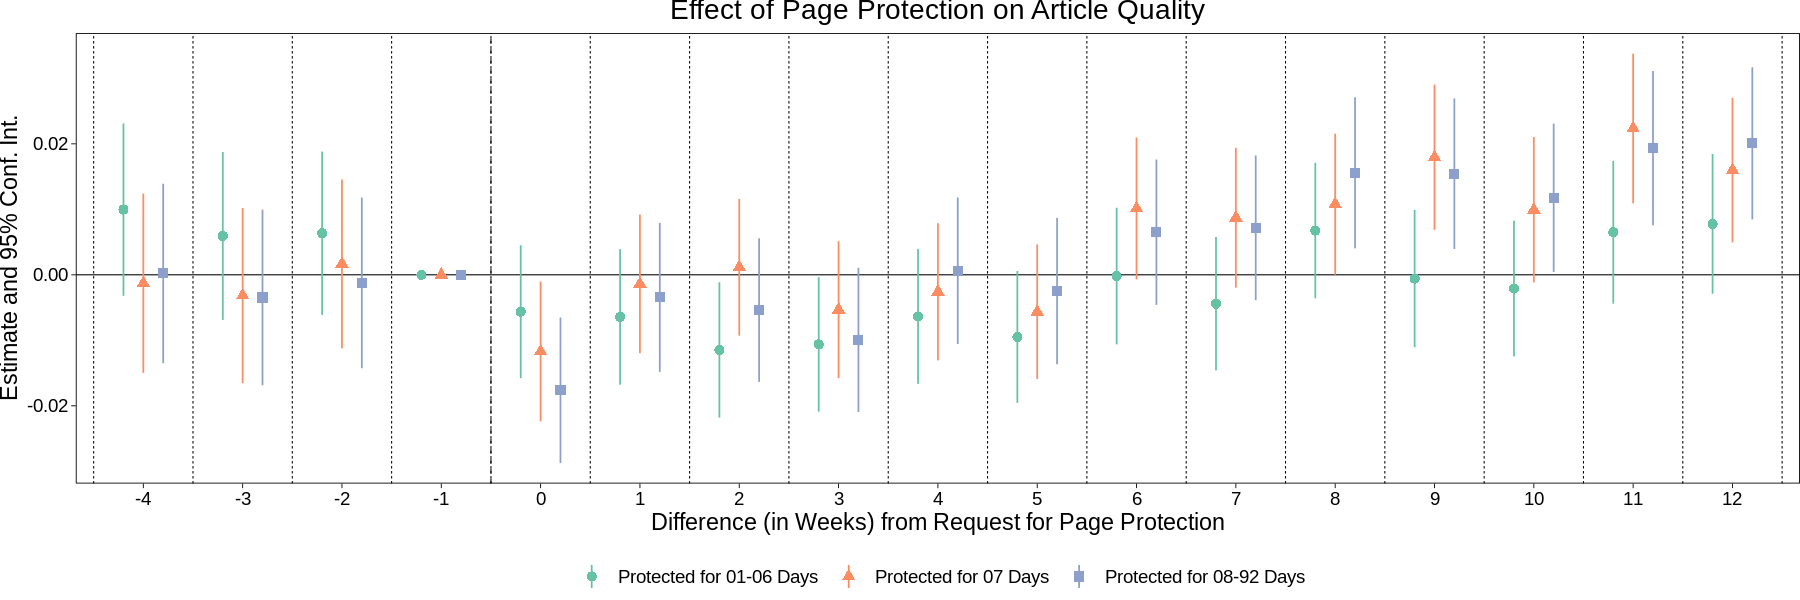

In [493]:
did_weekly <- fit_did(data_sets_weekly, 'articlequality_last_norm', 'request_diff_week')
plot_ggiplot(did_weekly, -4, 12, title='Effect of Page Protection on Article Quality')

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


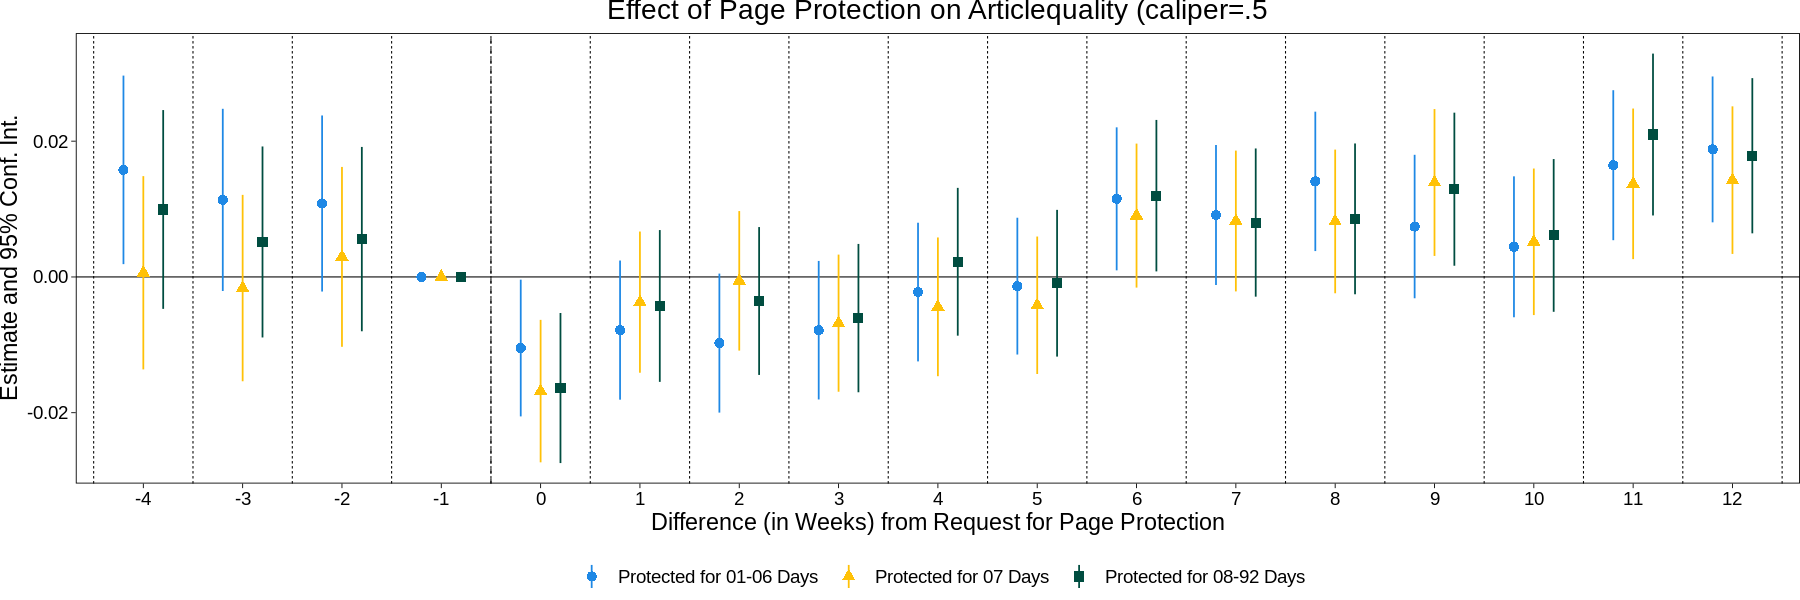

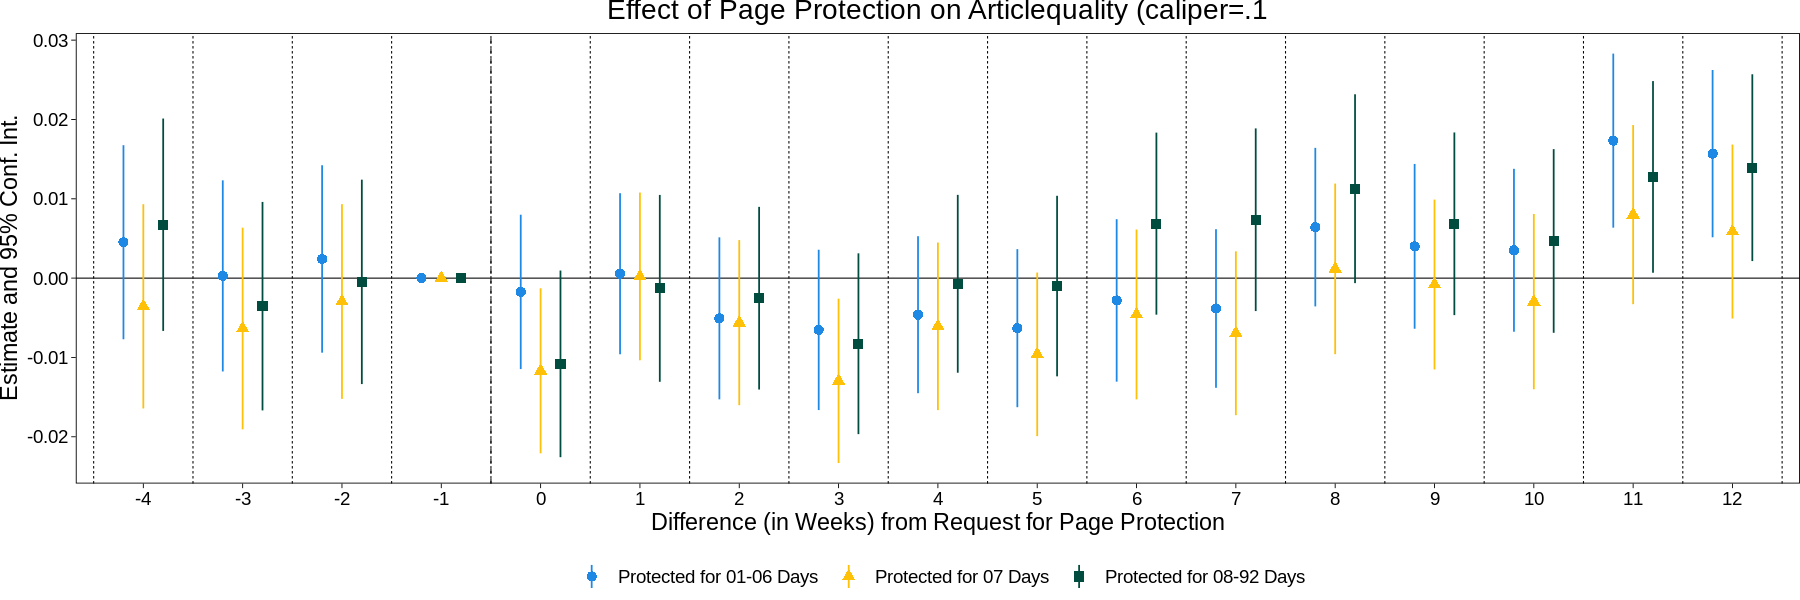

In [503]:
source('matching.r')

did_weekly <- fit_did(data_sets_weekly, 'articlequality_last_norm', 'request_diff_week')
p<-plot_ggiplot(did_weekly, -4, 12, title='Effect of Page Protection on Article Quality')
ggsave("figures/did_weekly.pdf", plot=p, width=7, height=3.5)

did_weekly5 <- fit_did(data_sets_weekly_5, 'articlequality_last_norm', 'request_diff_week')
plot_ggiplot(did_weekly5, -4, 12, title='Effect of Page Protection on Articlequality (caliper=.5')

did_weekly1 <- fit_did(data_sets_weekly_1, 'articlequality_last_norm', 'request_diff_week')
plot_ggiplot(did_weekly1, -4, 12, title='Effect of Page Protection on Articlequality (caliper=.1')


Retrieve protection with duration ( Protected for 08-92 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 01-06 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 08-92 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 01-06 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 01-06 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 08-92 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( Protected for 08-92 Days ) and topic ( ) and q

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


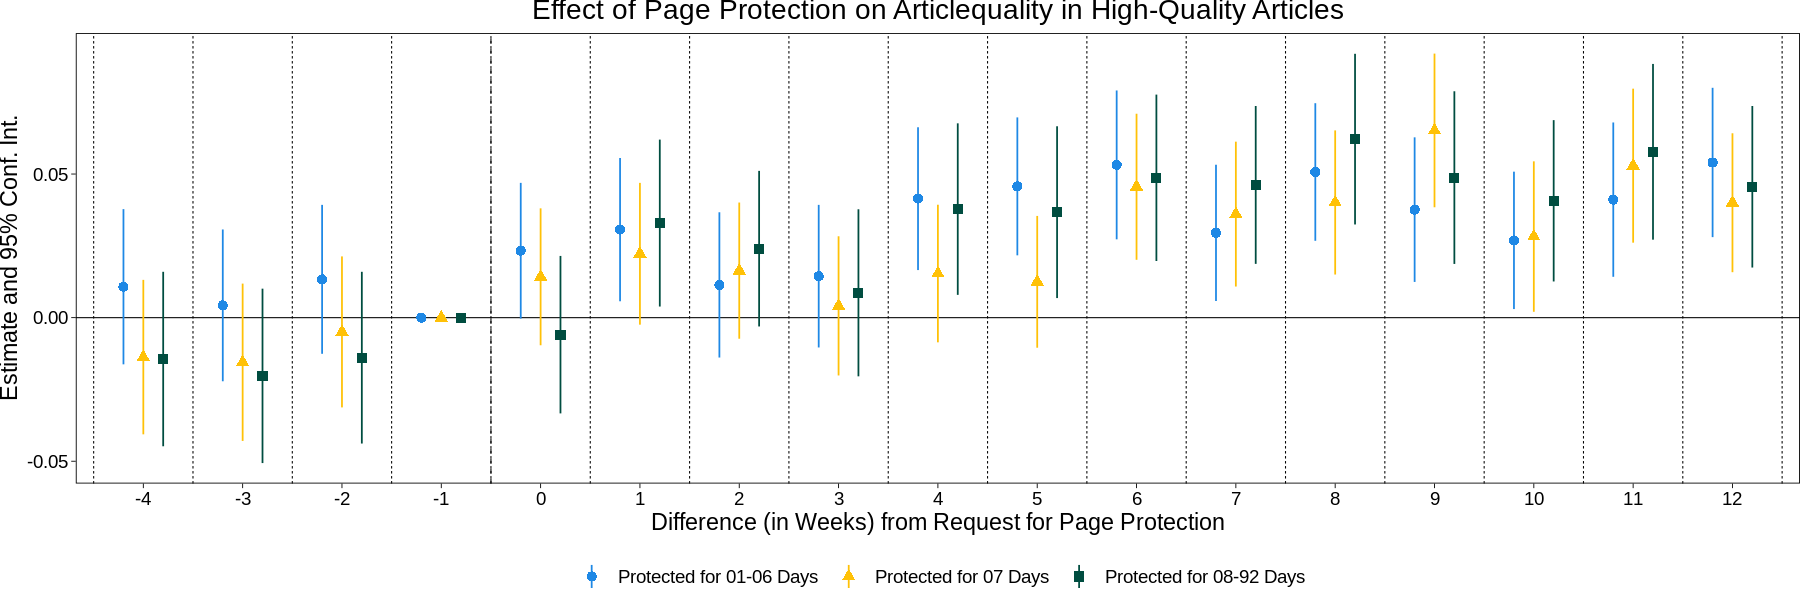

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


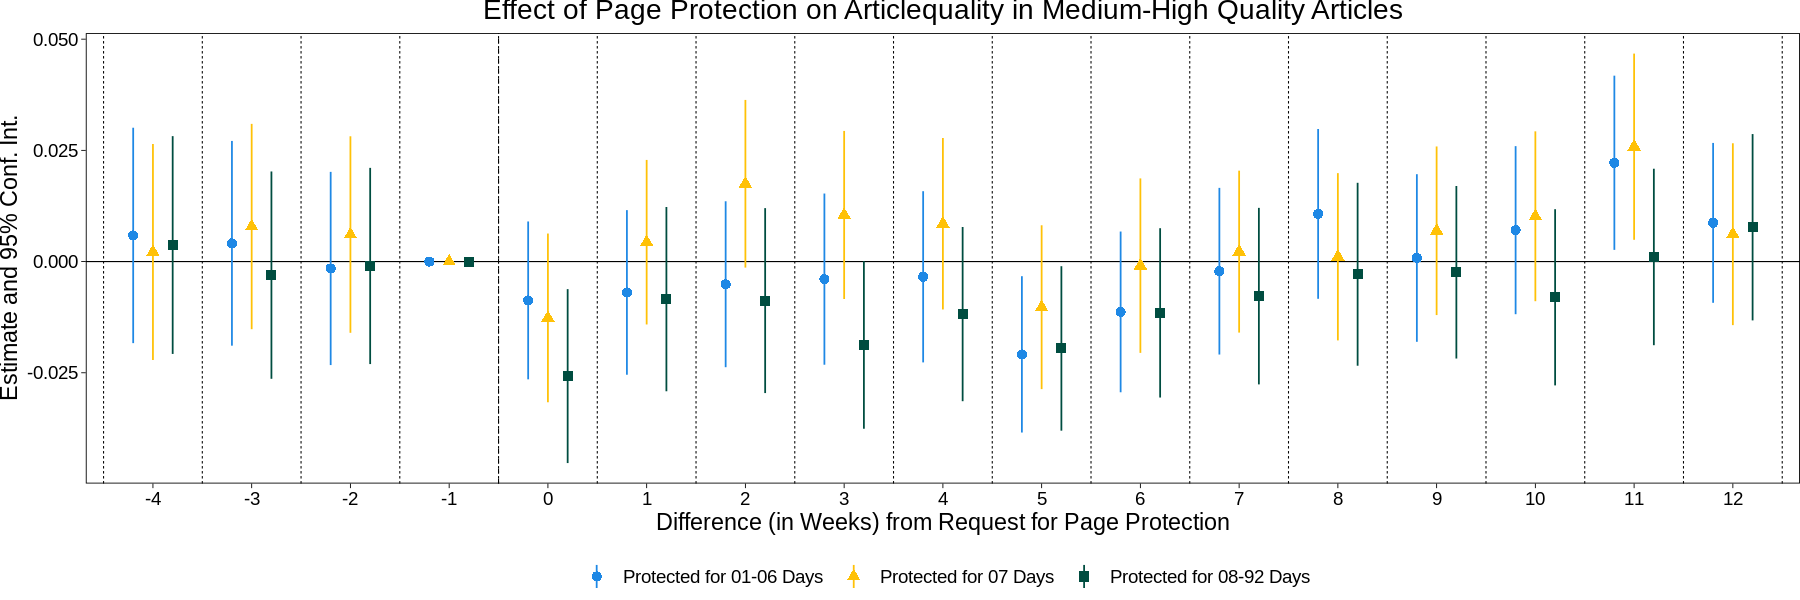

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


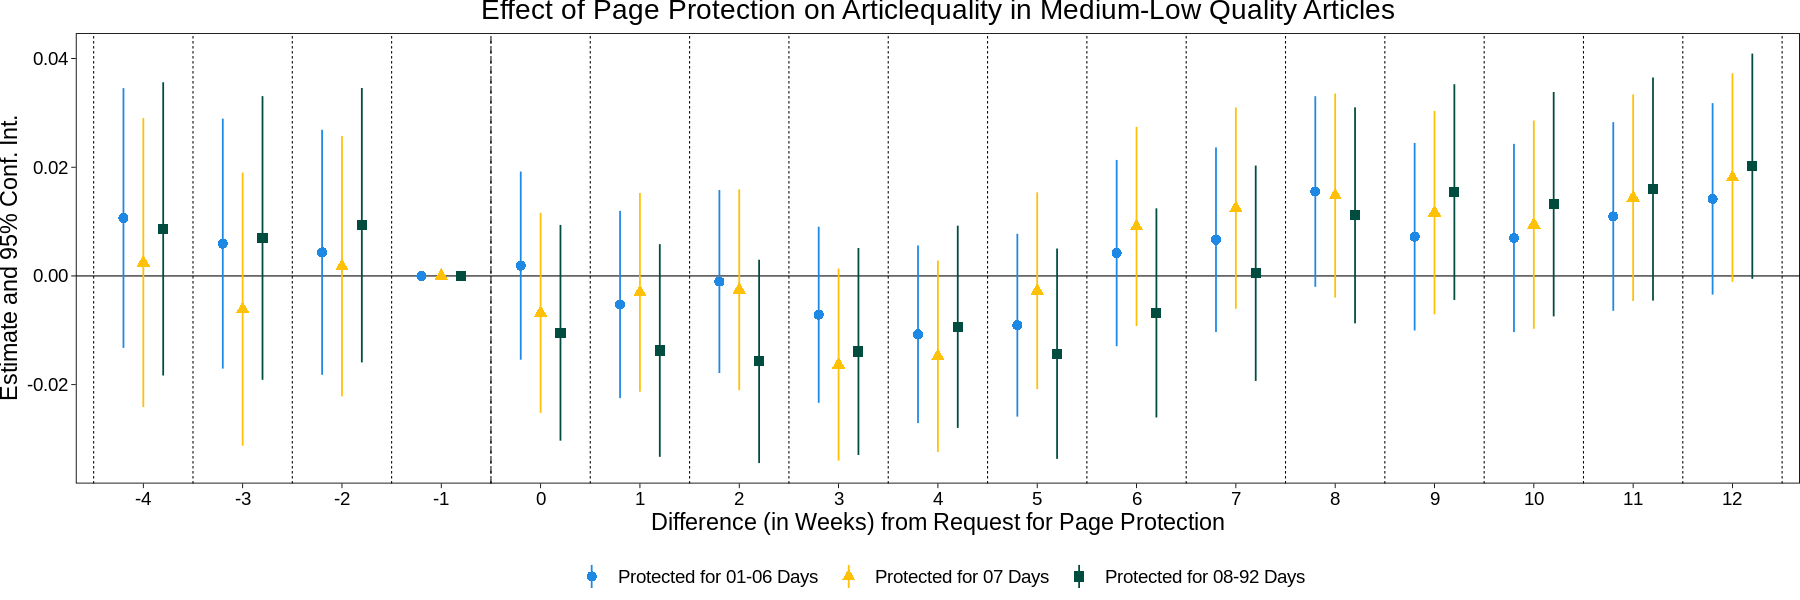

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


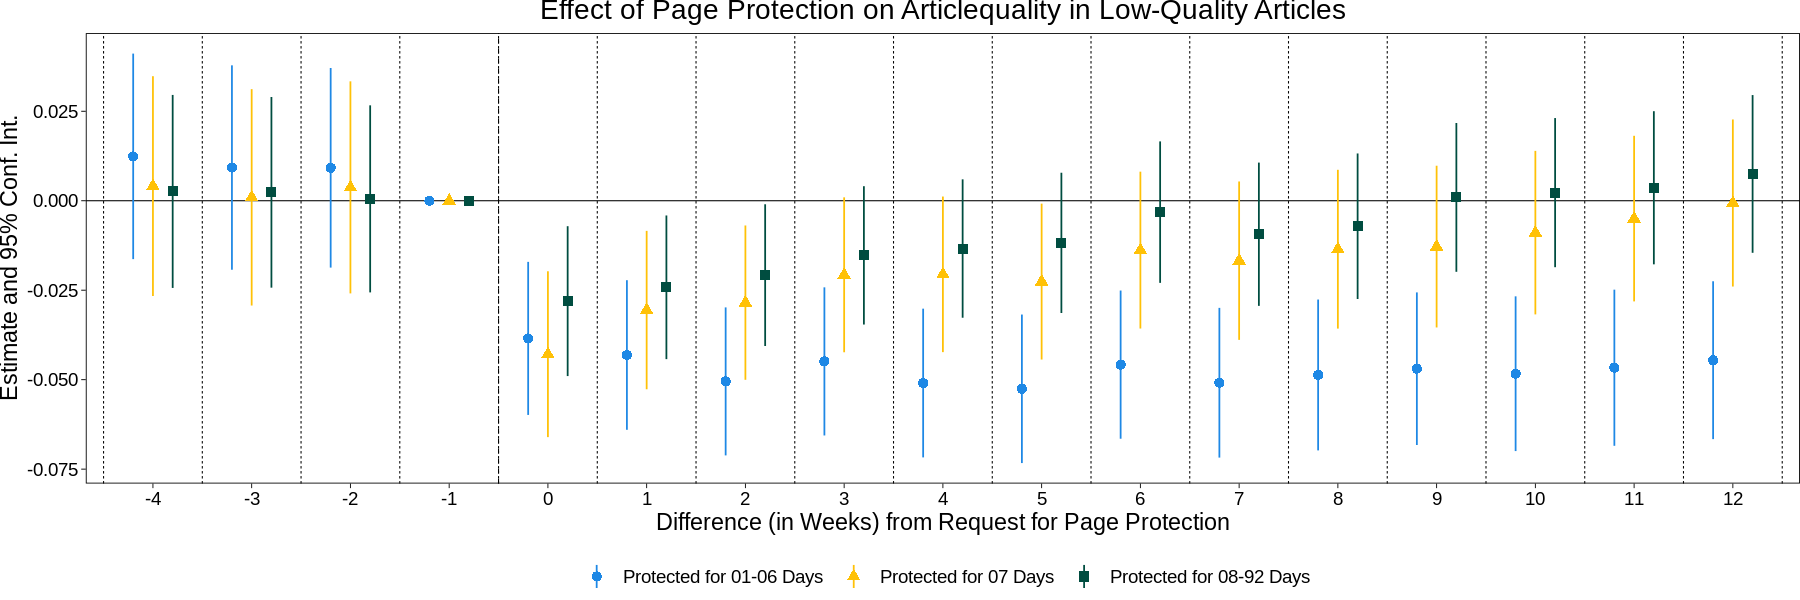

In [502]:
source('matching.r')
data_sets_weekly_high <- create_dataset_by_duration_labels(
    filter(df_matched_data_w, (Q_score_quantile == 'high')), 
    target_var = "articlequality_last_norm", show_plots=FALSE)


data_sets_weekly_mediumhigh <- create_dataset_by_duration_labels(
    filter(df_matched_data_w, (Q_score_quantile == 'medium-high')), 
    target_var = "articlequality_last_norm", show_plots=FALSE)

data_sets_weekly_mediumlow <- create_dataset_by_duration_labels(
    filter(df_matched_data_w, (Q_score_quantile == 'medium-low')), 
    target_var = "articlequality_last_norm", show_plots=FALSE)

data_sets_weekly_low <- create_dataset_by_duration_labels(
    filter(df_matched_data_w, (Q_score_quantile == 'low')), 
    target_var = "articlequality_last_norm", show_plots=FALSE)

did_weekly_high <- fit_did(data_sets_weekly_high, 'articlequality_last_norm', 'request_diff_week')
plot_ggiplot(did_weekly_high, -4, 12, title='Effect of Page Protection on Articlequality in High-Quality Articles')
p<-plot_ggiplot(did_weekly_high, -4, 12, title='Effect of Page Protection on Articlequality in High-Quality Articles')
#ggsave("figures/did_weekly-high.pdf", plot=p, width=7, height=3.5)

did_weekly_mediumhigh <- fit_did(data_sets_weekly_mediumhigh, 'articlequality_last_norm', 'request_diff_week')
plot_ggiplot(did_weekly_mediumhigh, -4, 12, title='Effect of Page Protection on Articlequality in Medium-High Quality Articles')

did_weekly_mediumlow <- fit_did(data_sets_weekly_mediumlow, 'articlequality_last_norm', 'request_diff_week')
plot_ggiplot(did_weekly_mediumlow, -4, 12, title='Effect of Page Protection on Articlequality in Medium-Low Quality Articles')

did_weekly_low <- fit_did(data_sets_weekly_low, 'articlequality_last_norm', 'request_diff_week')
plot_ggiplot(did_weekly_low, -4, 12, title='Effect of Page Protection on Articlequality in Low-Quality Articles')
p<-plot_ggiplot(did_weekly_low, -4, 12, title='Effect of Page Protection on Articlequality in Low-Quality Articles')
#ggsave("figures/did_weekly-low.pdf", plot=p, width=7, height=3.5)

In [457]:
source('matching.r')

In [458]:
export_table(did_weekly_high, 'did-all')
export_table(did_weekly_high, 'did-high')
export_table(did_weekly_low, 'did-low')

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


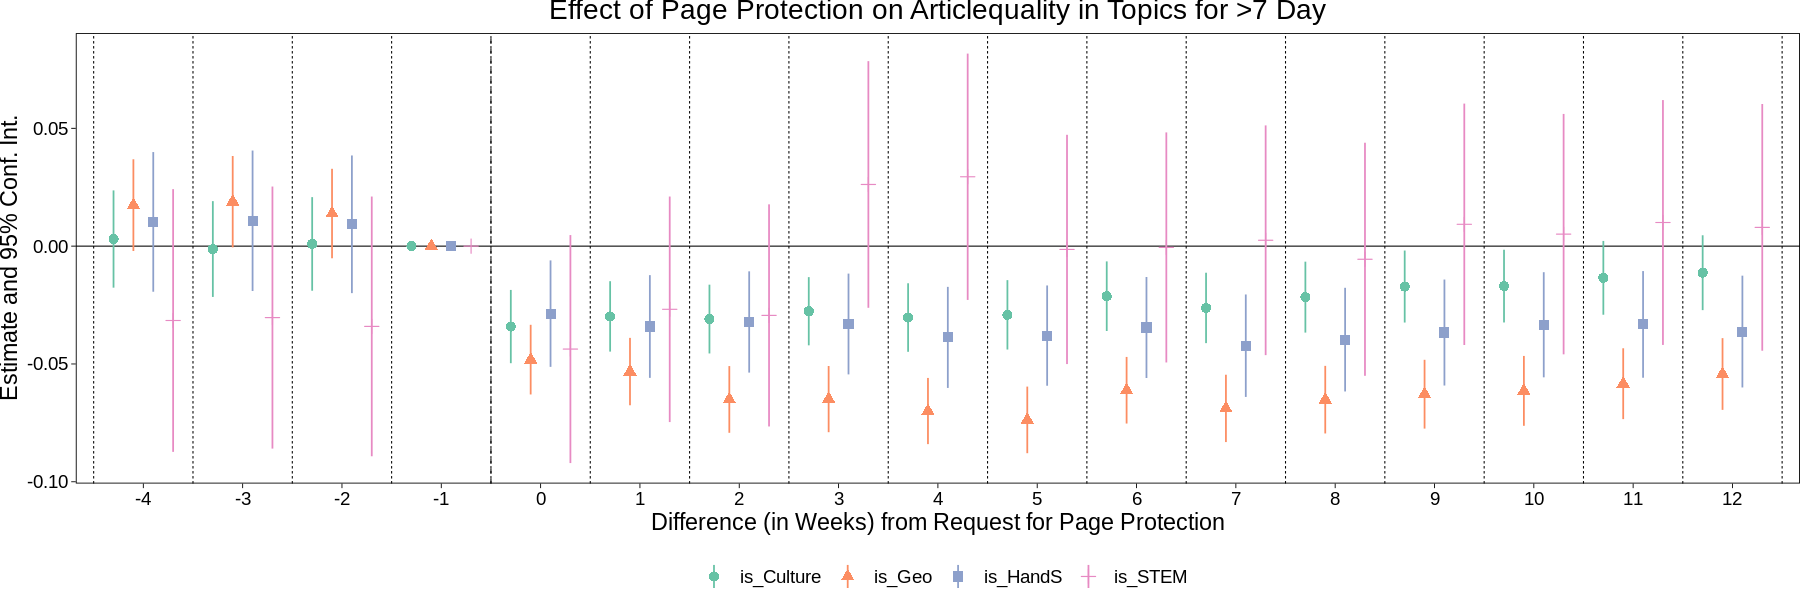

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


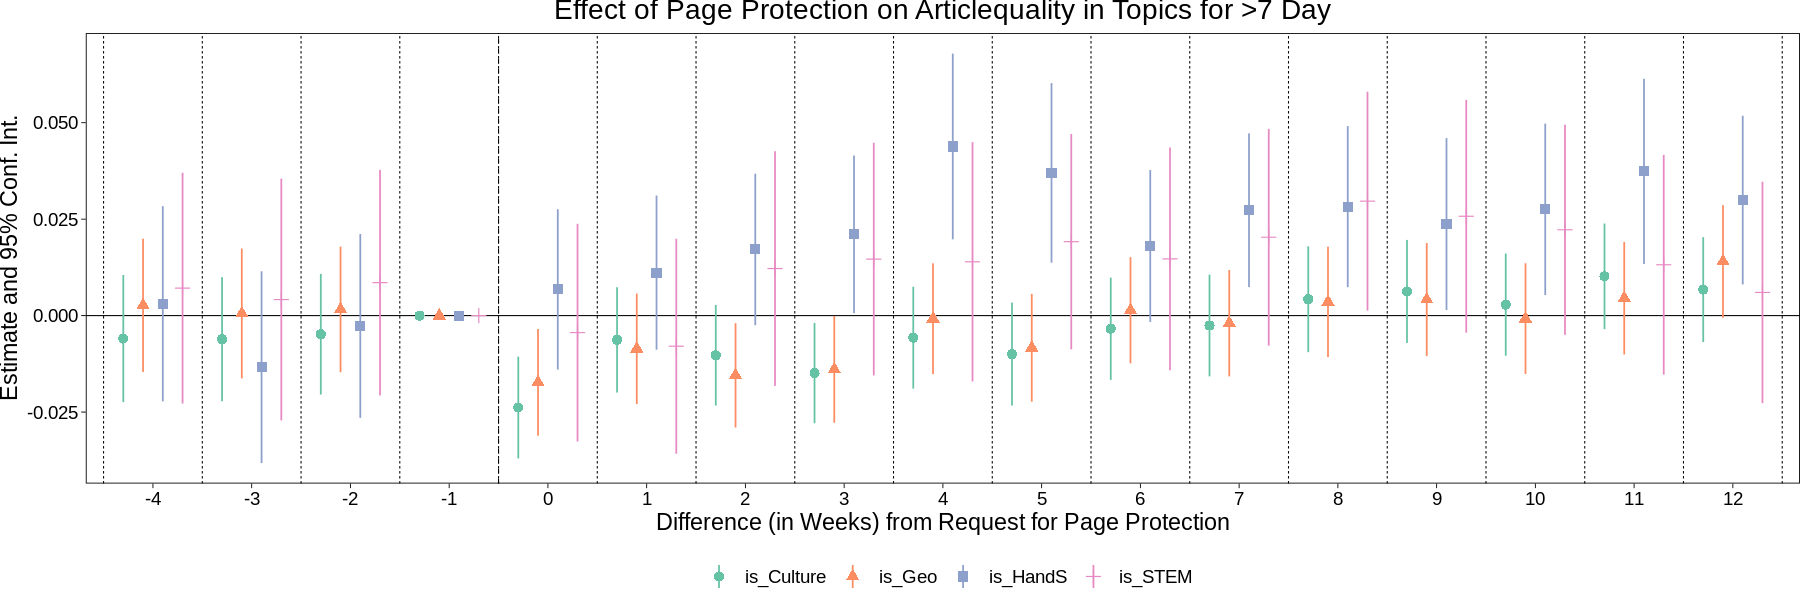

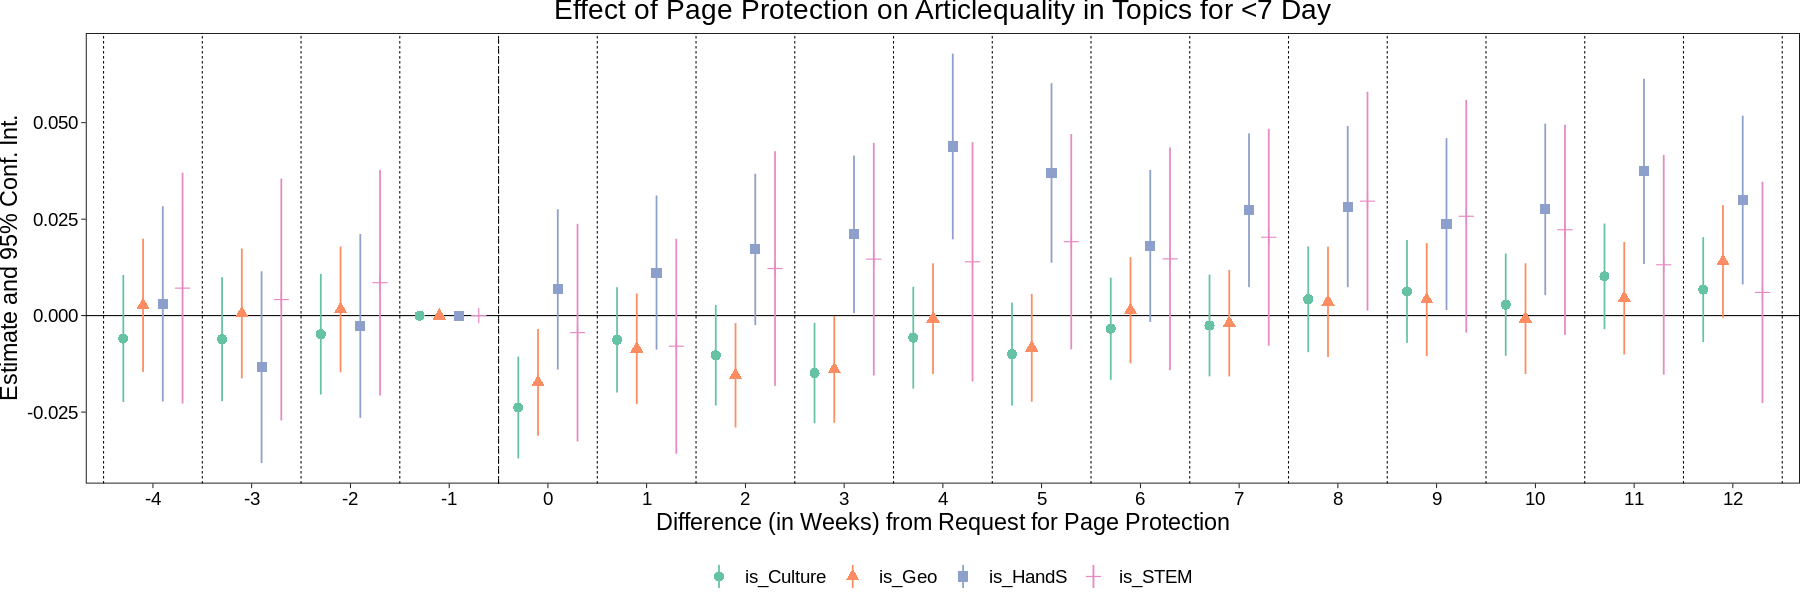

In [485]:
topics <-  c('is_STEM', 'is_Geo', 'is_HandS', 'is_Culture')
data_sets_weekly_topic <- create_dataset_by_duration_and_topics(
    filter(df_matched_data_w, duration_label == 'Protected for 07 Days'), rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")
topics <-  c('is_STEM', 'is_Geo', 'is_HandS', 'is_Culture')
did_list_topic <- fit_did(data_sets_weekly_topic, 'articlequality_last_norm', 'request_diff_week')

plot_ggiplot(did_list_topic_low, -4, 12, title_var='Articlequality in Topics for >7 Day')

data_sets_weekly_topic <- create_dataset_by_duration_and_topics(
    filter(df_matched_data_w, duration_label == 'Protected for 08-92 Days'), rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")
topics <-  c('is_STEM', 'is_Geo', 'is_HandS', 'is_Culture')
did_list_topic <- fit_did(data_sets_weekly_topic, 'articlequality_last_norm', 'request_diff_week')

plot_ggiplot(did_list_topic, -4, 12, title_var='Articlequality in Topics for >7 Day')

data_sets_weekly_topic <- create_dataset_by_duration_and_topics(
    filter(df_matched_data_w, duration_label == 'Protected for 01-06 Days'), rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")
did_list_topic_low <- fit_did(data_sets_weekly_topic, 'articlequality_last_norm', 'request_diff_week')

plot_ggiplot(did_list_topic, -4, 12, title_var='Articlequality in Topics for <7 Day')

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Estimate     Std. Error  t value    Pr(>|t|)   
is_STEM     0.002732373 0.007367753  0.3708557 0.710746055
is_Geo     -0.008225885 0.003060389 -2.6878561 0.007191477
is_HandS    0.015719262 0.004874712  3.2246546 0.001261475
is_Culture -0.002037706 0.003019541 -0.6748397 0.499777888

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


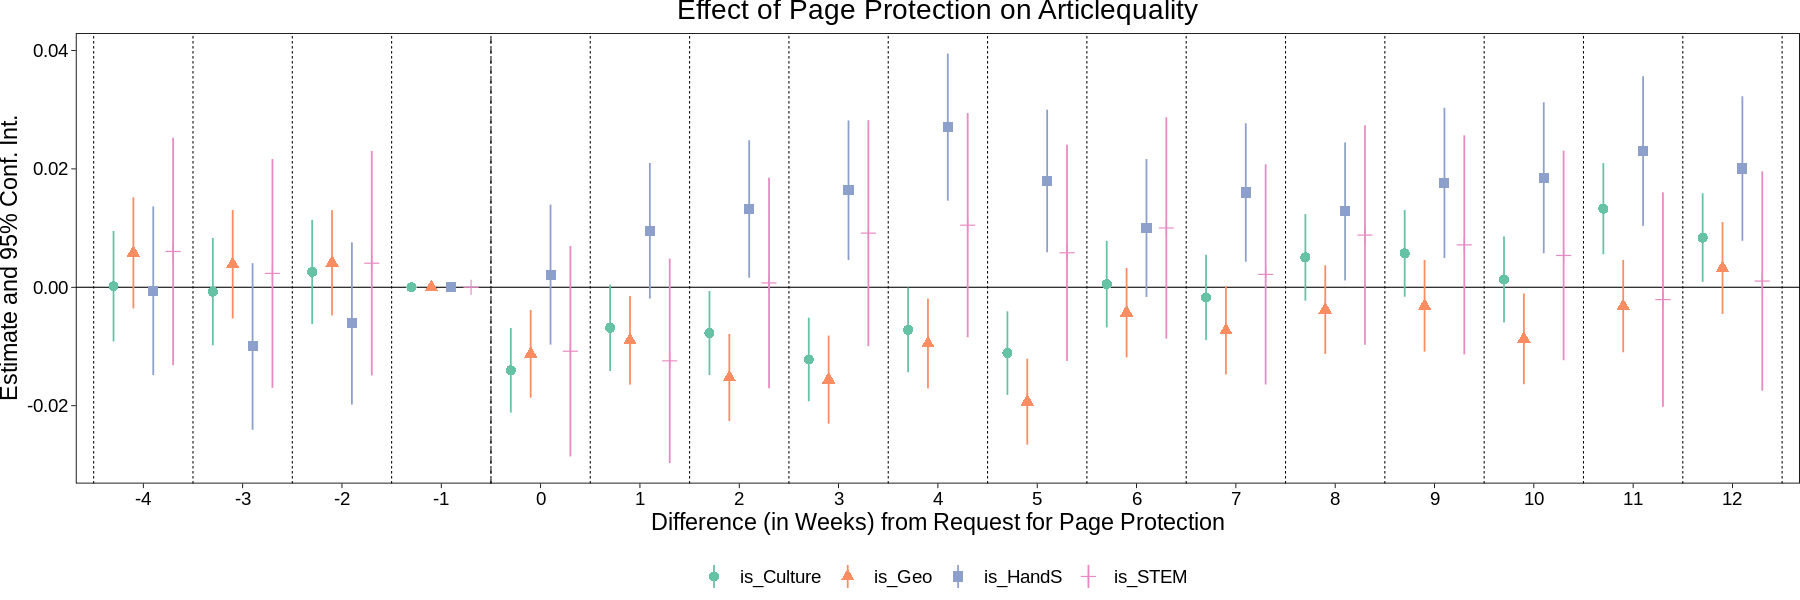

Estimate     Std. Error  t value     Pr(>|t|)    
is_STEM    -0.001299566 0.022463550 -0.05785223 9.538674e-01
is_Geo     -0.062091585 0.006527102 -9.51288700 1.885925e-21
is_HandS   -0.035433255 0.009980087 -3.55039530 3.851380e-04
is_Culture -0.023837738 0.006735371 -3.53918723 4.014867e-04

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


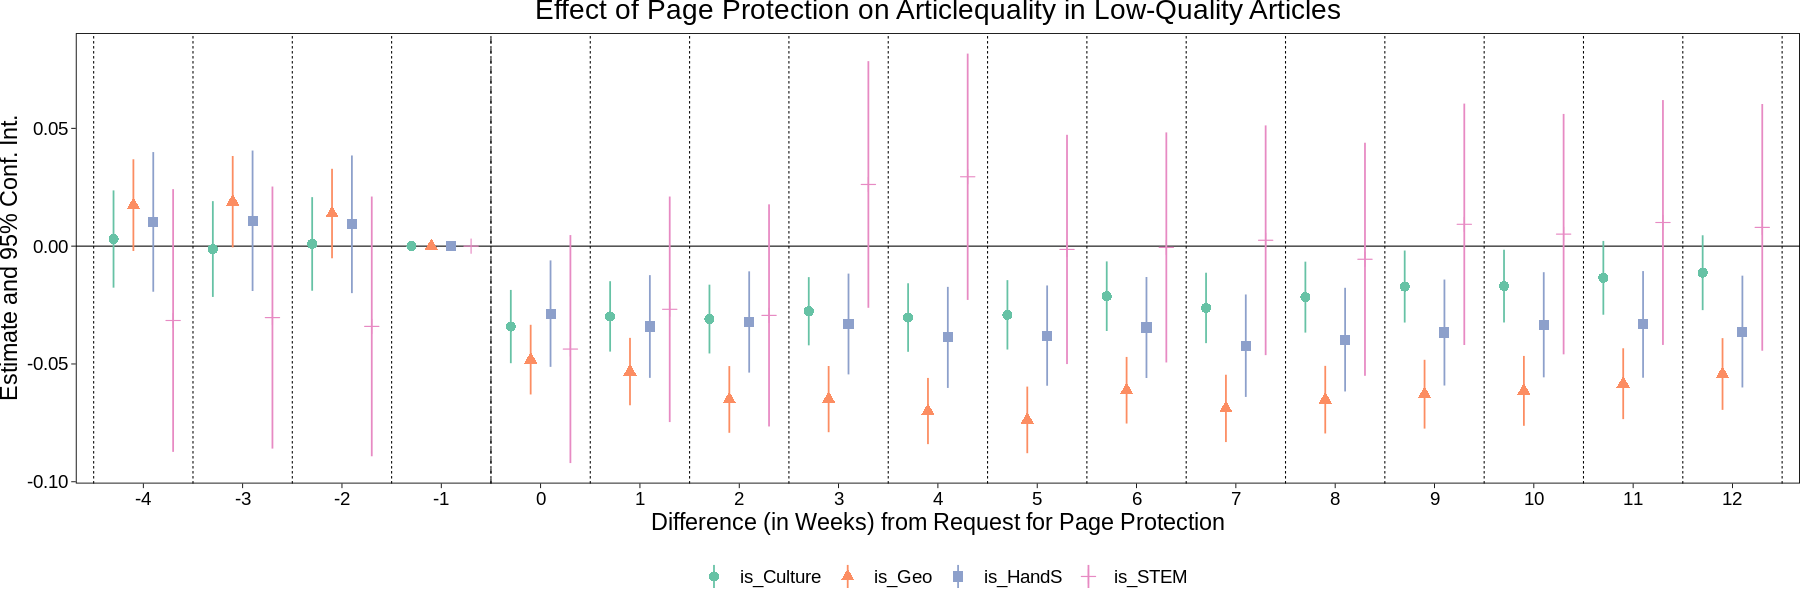

Estimate      Std. Error  t value    Pr(>|t|)    
is_STEM     0.0135799515 0.014124960  0.9614152 0.3363593301
is_Geo     -0.0008098341 0.005429828 -0.1491454 0.8814391068
is_HandS    0.0273029436 0.008200499  3.3294247 0.0008710006
is_Culture -0.0054089752 0.005390901 -1.0033526 0.3156923294

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


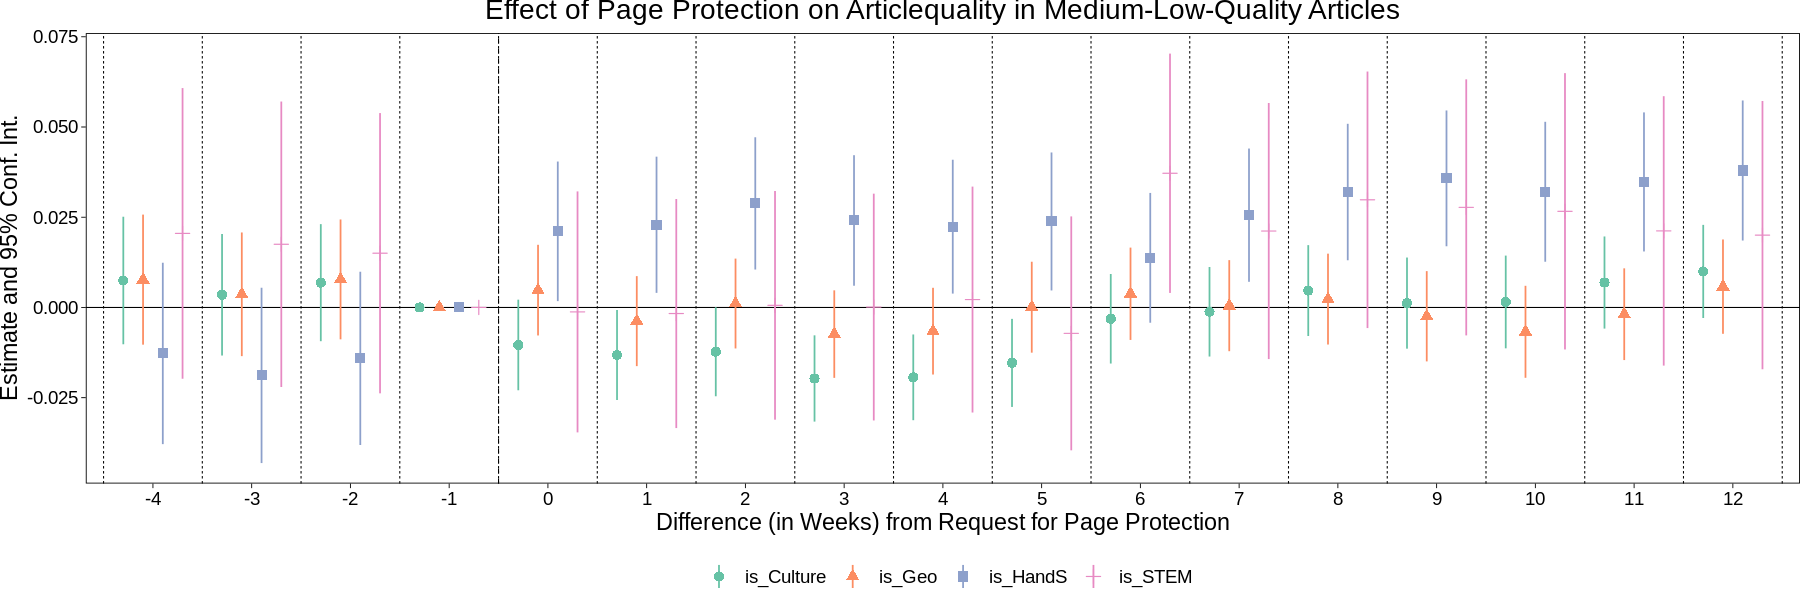

Estimate     Std. Error  t value    Pr(>|t|)  
is_STEM    -0.019073461 0.009582036 -1.9905436 0.04654219
is_Geo      0.004920912 0.005310224  0.9266863 0.35409126
is_HandS    0.006997600 0.007834581  0.8931683 0.37177156
is_Culture -0.002248394 0.005535947 -0.4061443 0.68463717

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


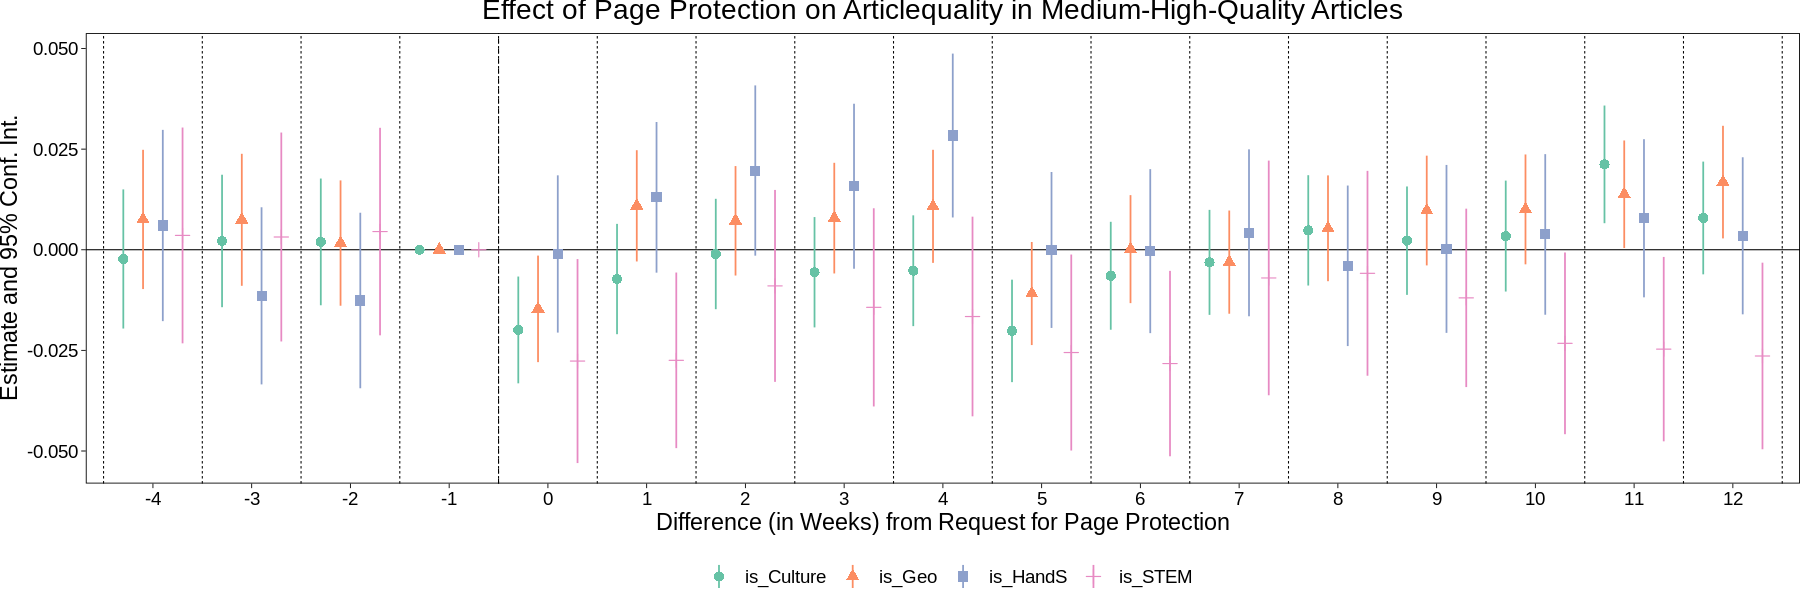

Estimate   Std. Error  t value  Pr(>|t|)    
is_STEM    0.02001339 0.015336274 1.304971 1.919152e-01
is_Geo     0.02587025 0.006824681 3.790689 1.503027e-04
is_HandS   0.05072838 0.011519669 4.403632 1.066699e-05
is_Culture 0.02386429 0.006159167 3.874597 1.068489e-04

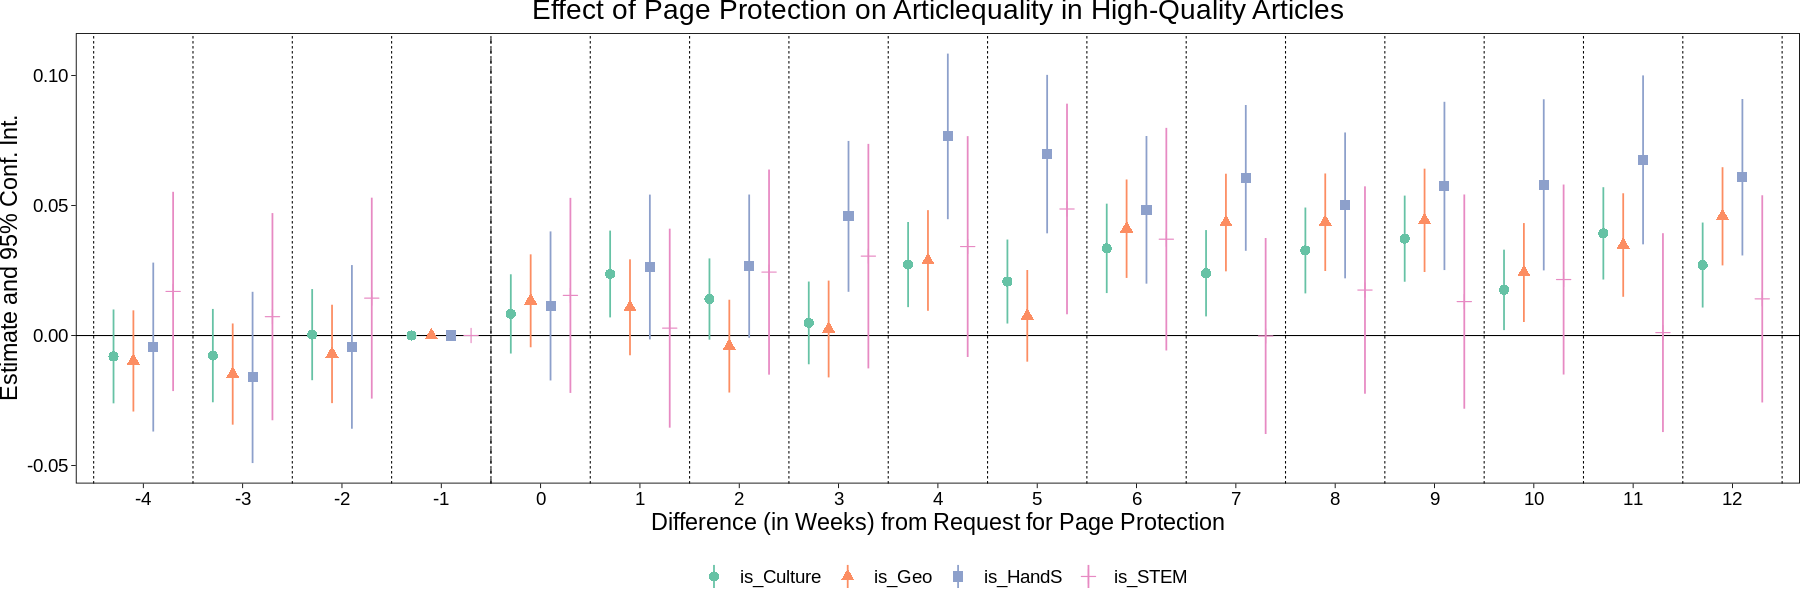

In [487]:
source("matching.r")
rel_durations <- c(unique(df_matched_data_w$duration_label))

topics <-  c('is_STEM', 'is_Geo', 'is_HandS', 'is_Culture')
data_sets_weekly_topic <- create_dataset_by_duration_and_topics(
    df_matched_data_w, rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")

did_list_topic <- fit_did(data_sets_weekly_topic, 'articlequality_last_norm',
                          'request_diff_week')
plot_ggiplot(did_list_topic, -4, 12, title_var='Articlequality')
aggregate_att(did_list_topic, topics)

data_sets_weekly_topic_low <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w, (Q_score_quantile == 'low')), 
    rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")

did_list_topic_low <- fit_did(data_sets_weekly_topic_low, 'articlequality_last_norm', 'request_diff_week')

plot_ggiplot(did_list_topic_low, -4, 12, title_var='Articlequality in Low-Quality Articles')
aggregate_att(did_list_topic_low, topics)


data_sets_weekly_topic_mediumlow <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w, (Q_score_quantile == 'medium-low')), 
    rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")

did_list_topic_ml <- fit_did(data_sets_weekly_topic_mediumlow, 'articlequality_last_norm', 'request_diff_week')
plot_ggiplot(did_list_topic_ml, -4, 12, title_var='Articlequality in Medium-Low-Quality Articles')
aggregate_att(did_list_topic_ml, topics)

data_sets_weekly_topic_mediumhigh<- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w, (Q_score_quantile == 'medium-high')), 
    rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")

did_list_topic_mh <- fit_did(data_sets_weekly_topic_mediumhigh, 'articlequality_last_norm', 'request_diff_week')
plot_ggiplot(did_list_topic_mh, -4, 12, title_var='Articlequality in Medium-High-Quality Articles')
aggregate_att(did_list_topic_mh, topics)


data_sets_weekly_topic_high <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w, (Q_score_quantile == 'high')), 
    rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")

did_list_topic_high <- fit_did(data_sets_weekly_topic_high, 'articlequality_last_norm',
                               'request_diff_week')
plot_ggiplot(did_list_topic_high, -4, 12, title_var='Articlequality in High-Quality Articles')
aggregate_att(did_list_topic_high, topics)

list_models <- list('all'=did_list_topic, 'high'=did_list_topic_high, 'low'=did_list_topic_low)

write.csv(extract_start_end_coefs_for_models(list_models), 'data/experiment/weekly_all_bytopic.csv')

In [488]:
etable(did_list_topic_high)

is_STEM                 
1  Dependent Var.:                  articlequality_last_norm
2                                                           
3  treated x request_diff_week = -4 0.0169 (0.0196)         
4  treated x request_diff_week = -3 0.0072 (0.0203)         
5  treated x request_diff_week = -2 0.0144 (0.0197)         
6  treated x request_diff_week = 0  0.0154 (0.0191)         
7  treated x request_diff_week = 1  0.0028 (0.0195)         
8  treated x request_diff_week = 2  0.0244 (0.0201)         
9  treated x request_diff_week = 3  0.0305 (0.0220)         
10 treated x request_diff_week = 4  0.0342 (0.0217)         
11 treated x request_diff_week = 5  0.0487* (0.0207)        
12 treated x request_diff_week = 6  0.0370. (0.0218)        
13 treated x request_diff_week = 7  -0.0002 (0.0192)        
14 treated x request_diff_week = 8  0.0175 (0.0204)         
15 treated x request_diff_week = 9  0.0131 (0.0210)         
16 treated x request_diff_week = 10 0.0215 (0.0186)         
17 treated x request_diff_week = 11 0.0011 (0.0195)         
18 treated x request_diff_week = 12 0.0141 (0.0203)         
19 Fixed-Effects:                   ------------------------
20 request_diff_week                Yes                     
21 treated_id                       Yes                     
22 ________________________________ ________________________
23 S.E. type                        Heteroskedasticity-robu.
24 Observations                     25,262                  
25 R2                               0.81890                 
26 Within R2                        0.00067                 
   is_Geo                   is_HandS                 is_Culture              
1  articlequality_last_norm articlequality_last_norm articlequality_last_norm
2                                                                            
3  -0.0098 (0.0099)         -0.0045 (0.0166)         -0.0080 (0.0092)        
4  -0.0148 (0.0099)         -0.0161 (0.0168)         -0.0077 (0.0092)        
5  -0.0071 (0.0097)         -0.0044 (0.0161)         0.0003 (0.0089)         
6  0.0134 (0.0091)          0.0114 (0.0146)          0.0083 (0.0078)         
7  0.0109 (0.0094)          0.0263. (0.0142)         0.0237** (0.0085)       
8  -0.0041 (0.0091)         0.0267. (0.0141)         0.0140. (0.0080)        
9  0.0025 (0.0095)          0.0458** (0.0148)        0.0048 (0.0081)         
10 0.0289** (0.0099)        0.0766*** (0.0163)       0.0273** (0.0084)       
11 0.0076 (0.0090)          0.0698*** (0.0155)       0.0208* (0.0082)        
12 0.0411*** (0.0097)       0.0483*** (0.0145)       0.0335*** (0.0088)      
13 0.0435*** (0.0096)       0.0606*** (0.0143)       0.0240** (0.0085)       
14 0.0436*** (0.0096)       0.0500*** (0.0143)       0.0327*** (0.0084)      
15 0.0443*** (0.0101)       0.0575*** (0.0165)       0.0372*** (0.0084)      
16 0.0242* (0.0097)         0.0580*** (0.0168)       0.0175* (0.0079)        
17 0.0348*** (0.0102)       0.0675*** (0.0166)       0.0393*** (0.0091)      
18 0.0459*** (0.0096)       0.0609*** (0.0154)       0.0271** (0.0083)       
19 ------------------------ ------------------------ ------------------------
20 Yes                      Yes                      Yes                     
21 Yes                      Yes                      Yes                     
22 ________________________ ________________________ ________________________
23 Heteroskedasticity-robu. Heteroskedasticity-robu. Heteroskedasticity-robu.
24 125,596                  53,040                   148,512                 
25 0.73985                  0.77429                  0.74177                 
26 0.00124                  0.00243                  0.00072

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Estimate     Std. Error  t value   Pr(>|t|)   
is_STEM    -0.009655232 0.007706741 -1.252829 0.210271908
is_Geo     -0.009572993 0.003066794 -3.121499 0.001799436
is_HandS    0.011063016 0.004971847  2.225132 0.026073659
is_Culture -0.004421943 0.002973584 -1.487075 0.136995581

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


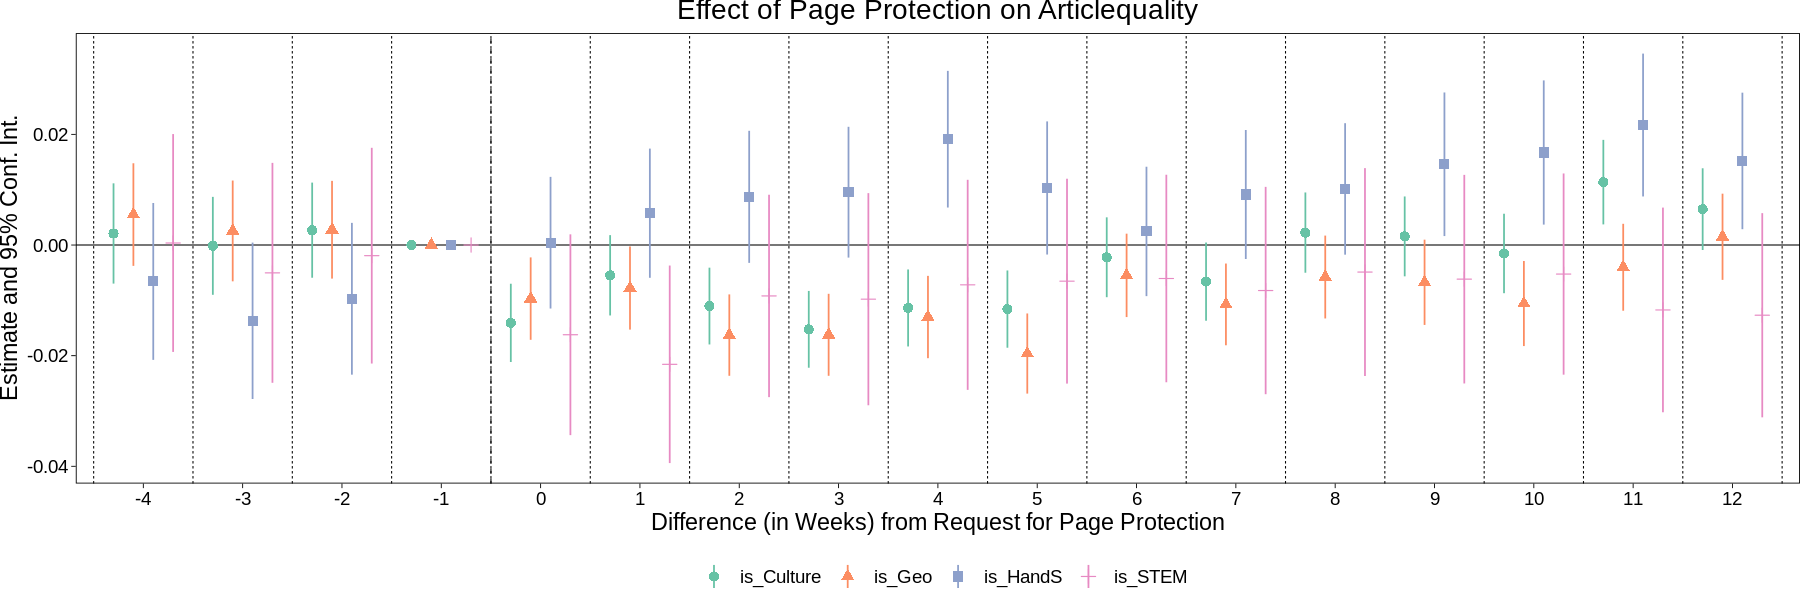

Estimate     Std. Error  t value    Pr(>|t|)    
is_STEM     0.005174888 0.022728848  0.2276793 8.199001e-01
is_Geo     -0.066717380 0.006678461 -9.9899331 1.722623e-23
is_HandS   -0.038272131 0.009847504 -3.8864803 1.018970e-04
is_Culture -0.036209052 0.006663212 -5.4341734 5.514195e-08

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


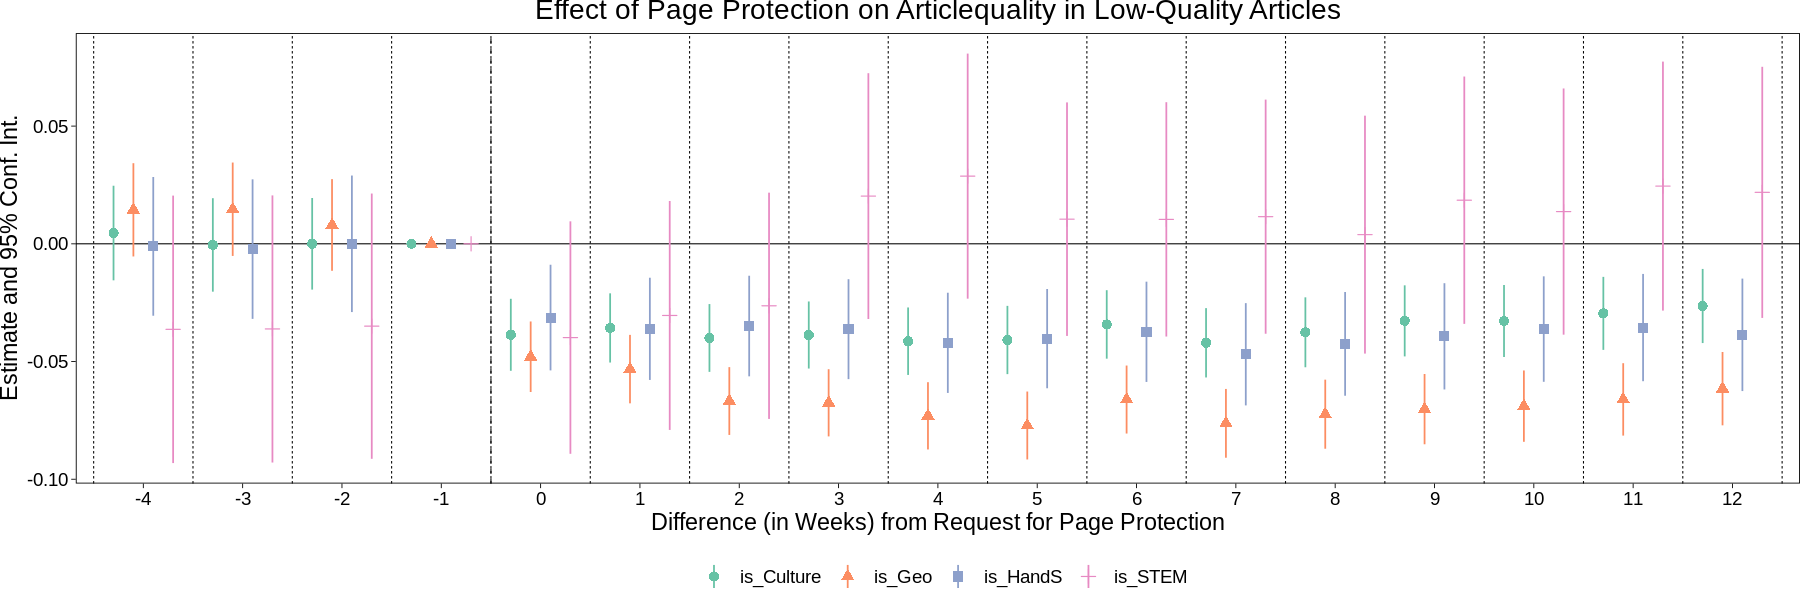

Estimate      Std. Error  t value     Pr(>|t|)  
is_STEM    -0.0015178144 0.015067288 -0.10073574 0.91976167
is_Geo      0.0001002259 0.005482089  0.01828243 0.98541357
is_HandS    0.0193849862 0.008213358  2.36017802 0.01827081
is_Culture -0.0031353365 0.005325336 -0.58875844 0.55602421

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


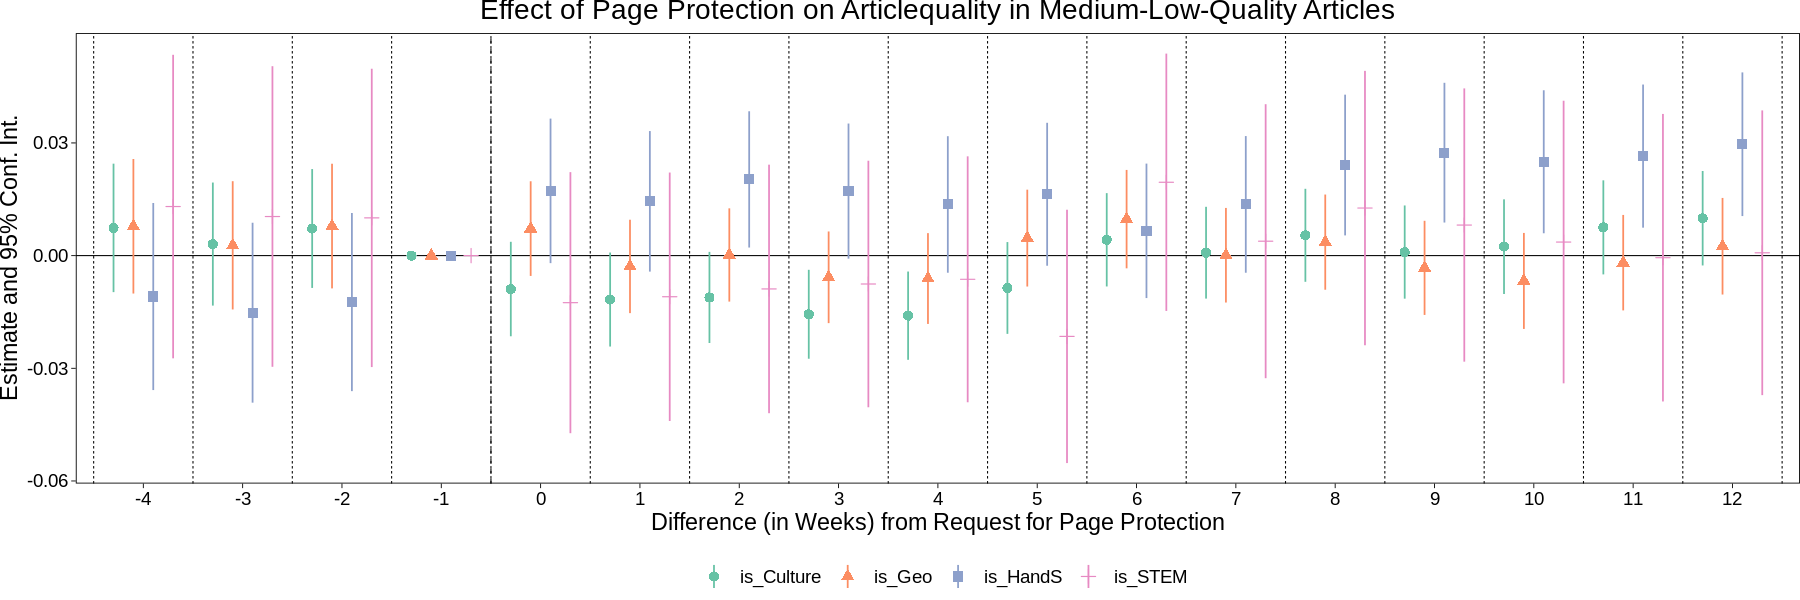

Estimate     Std. Error  t value    Pr(>|t|)   
is_STEM    -0.034721431 0.010706619 -3.2429873 0.001184458
is_Geo      0.001204048 0.005244366  0.2295889 0.818411600
is_HandS    0.002143512 0.008155039  0.2628451 0.792671102
is_Culture -0.005450395 0.005365372 -1.0158465 0.309704238

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


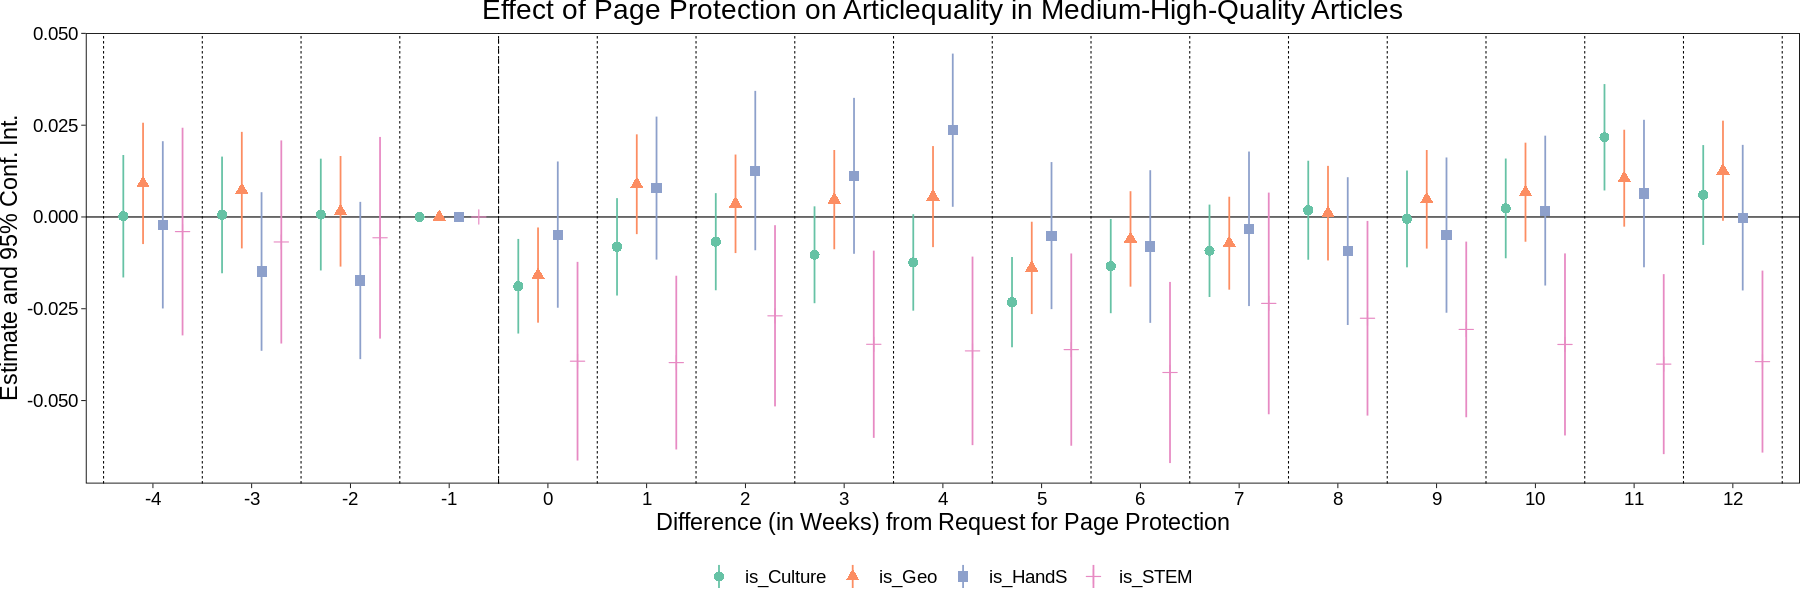

Estimate    Std. Error  t value   Pr(>|t|)    
is_STEM    0.004850186 0.015948362 0.3041181 7.610407e-01
is_Geo     0.027578103 0.006724535 4.1011168 4.114341e-05
is_HandS   0.047441618 0.011915511 3.9815009 6.857999e-05
is_Culture 0.027201619 0.006099753 4.4594623 8.222926e-06

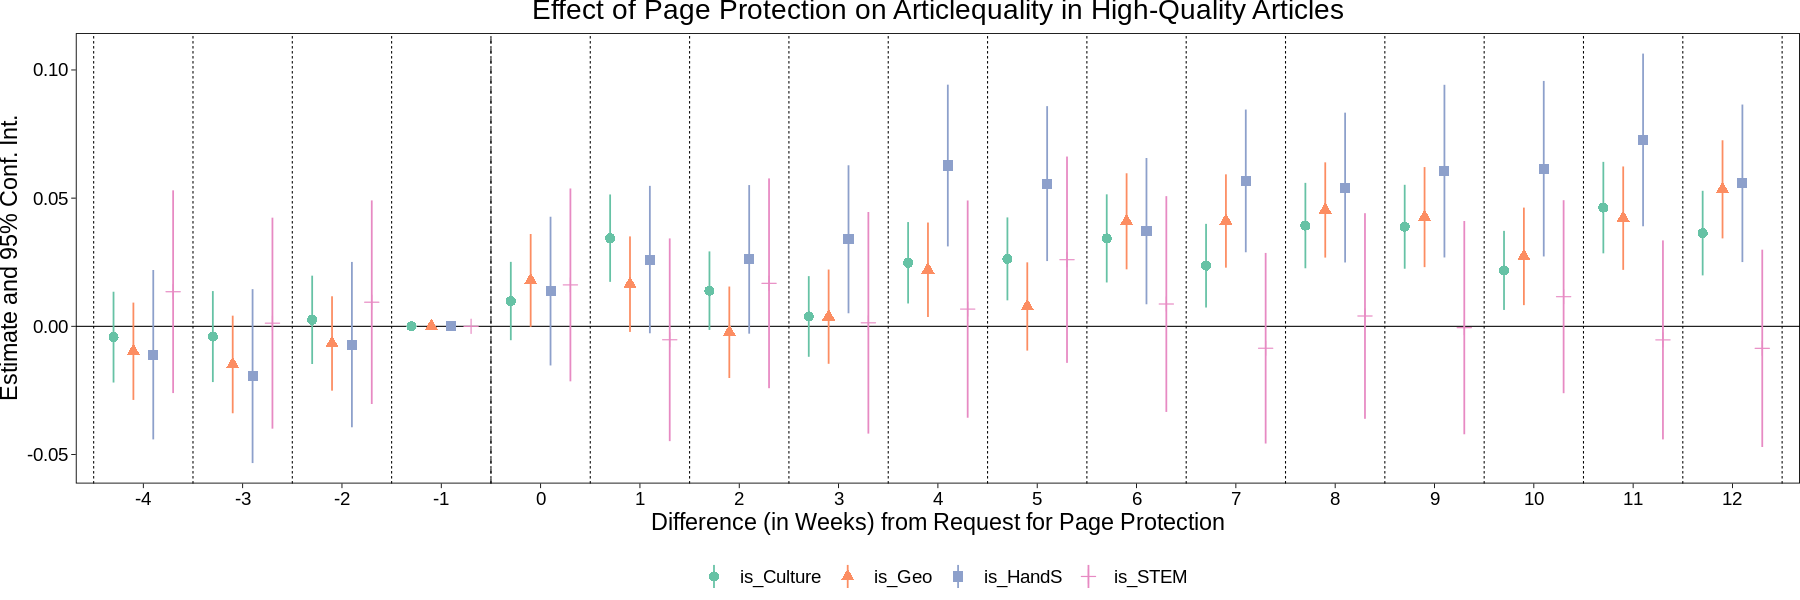

In [461]:
source("matching.r")
rel_durations <- c(unique(df_matched_data_w$duration_label))

topics <-  c('is_STEM', 'is_Geo', 'is_HandS', 'is_Culture')
data_sets_weekly_topic <- create_dataset_by_duration_and_topics(
    df_matched_data_w, rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")

did_list_topic <- fit_did(data_sets_weekly_topic, 'articlequality_last_norm',
                          'request_diff_week')
plot_ggiplot(did_list_topic, -4, 12, title_var='Articlequality')
aggregate_att(did_list_topic, topics)

data_sets_weekly_topic_low <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w, (Q_score_quantile == 'low')), 
    rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")

did_list_topic_low <- fit_did(data_sets_weekly_topic_low, 'articlequality_last_norm', 'request_diff_week')

plot_ggiplot(did_list_topic_low, -4, 12, title_var='Articlequality in Low-Quality Articles')
aggregate_att(did_list_topic_low, topics)


data_sets_weekly_topic_mediumlow <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w, (Q_score_quantile == 'medium-low')), 
    rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")

did_list_topic_ml <- fit_did(data_sets_weekly_topic_mediumlow, 'articlequality_last_norm', 'request_diff_week')
plot_ggiplot(did_list_topic_ml, -4, 12, title_var='Articlequality in Medium-Low-Quality Articles')
aggregate_att(did_list_topic_ml, topics)

data_sets_weekly_topic_mediumhigh<- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w, (Q_score_quantile == 'medium-high')), 
    rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")

did_list_topic_mh <- fit_did(data_sets_weekly_topic_mediumhigh, 'articlequality_last_norm', 'request_diff_week')
plot_ggiplot(did_list_topic_mh, -4, 12, title_var='Articlequality in Medium-High-Quality Articles')
aggregate_att(did_list_topic_mh, topics)


data_sets_weekly_topic_high <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w, (Q_score_quantile == 'high')), 
    rel_durations, topics, show_plots=FALSE, 
    target_var = "articlequality_last_norm")

did_list_topic_high <- fit_did(data_sets_weekly_topic_high, 'articlequality_last_norm',
                               'request_diff_week')
plot_ggiplot(did_list_topic_high, -4, 12, title_var='Articlequality in High-Quality Articles')
aggregate_att(did_list_topic_high, topics)

list_models <- list('all'=did_list_topic, 'high'=did_list_topic_high, 'low'=did_list_topic_low)

write.csv(extract_start_end_coefs_for_models(list_models), 'data/experiment/weekly_all_bytopic.csv')

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Estimate     Std. Error  t value    Pr(>|t|)  
is_STEM    -0.009299078 0.008618097 -1.0790175 0.28058452
is_Geo     -0.005997532 0.003187461 -1.8816015 0.05989081
is_HandS    0.003885012 0.005518692  0.7039733 0.48145055
is_Culture -0.005540993 0.003002332 -1.8455633 0.06495621

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


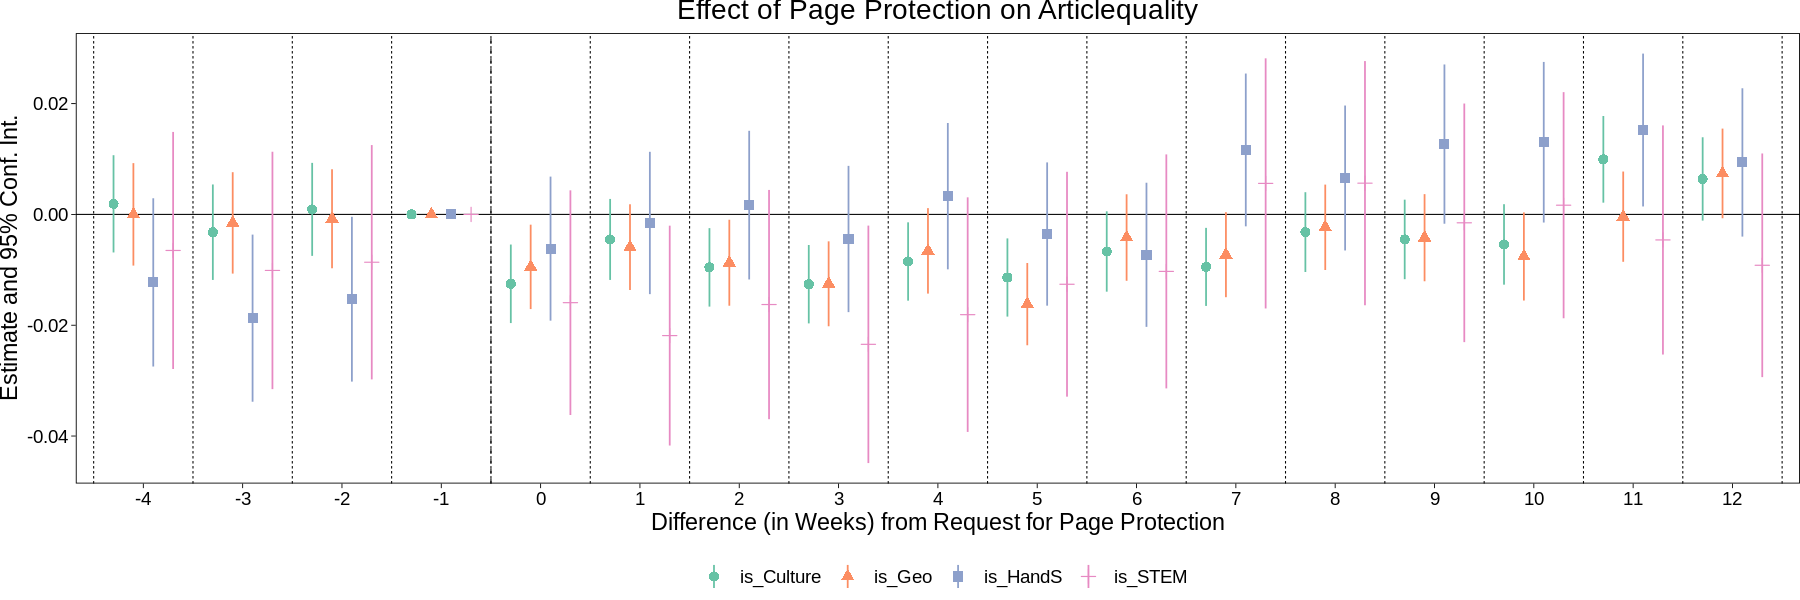

Estimate    Std. Error  t value    Pr(>|t|)    
is_STEM     0.02703210 0.028776242  0.9393895 3.475643e-01
is_Geo     -0.06471735 0.006655932 -9.7232583 2.452918e-22
is_HandS   -0.06456933 0.010729596 -6.0178711 1.790897e-09
is_Culture -0.03310222 0.006336646 -5.2239335 1.754477e-07

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


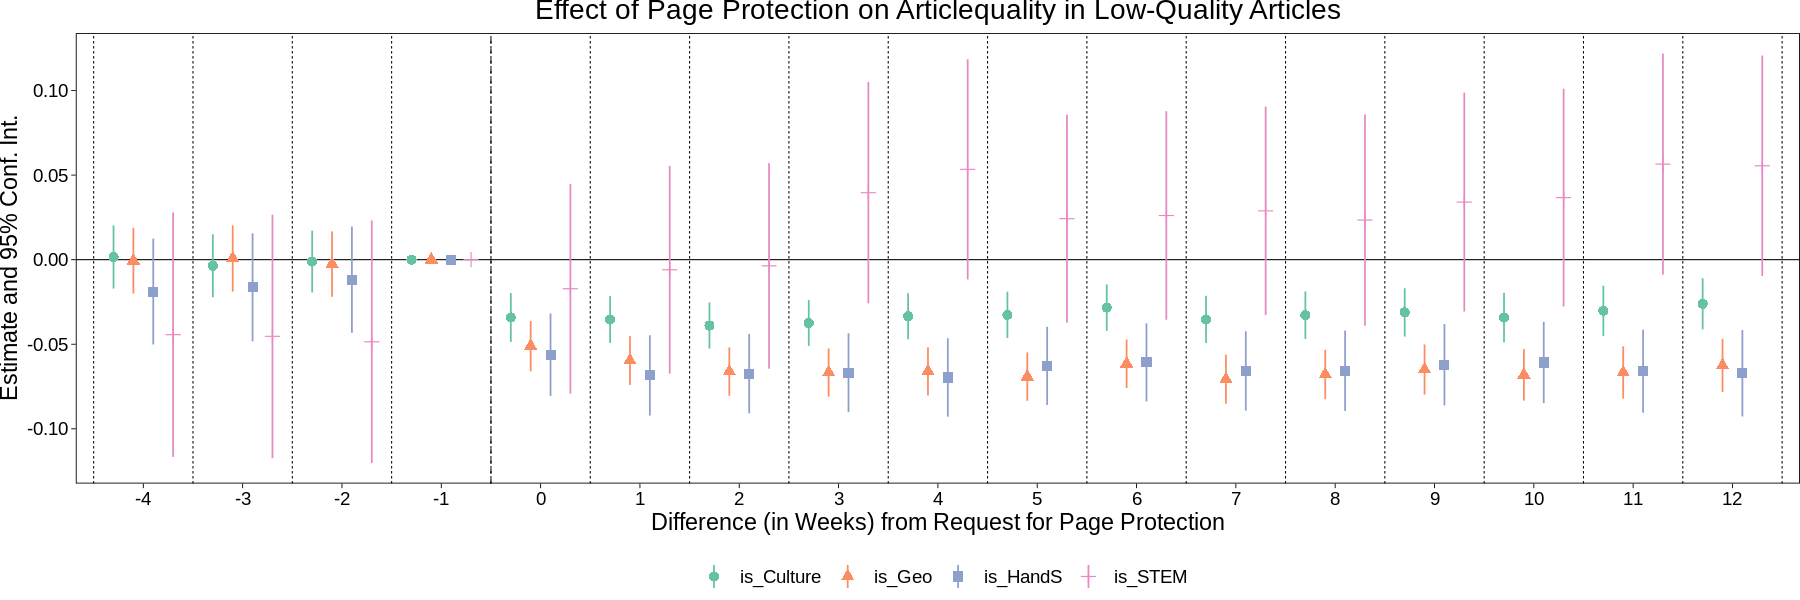

Estimate     Std. Error  t value    Pr(>|t|) 
is_STEM    -0.023184248 0.016000514 -1.4489689 0.1473743
is_Geo      0.005979371 0.005782891  1.0339761 0.3011496
is_HandS    0.010418853 0.008328860  1.2509339 0.2109669
is_Culture  0.005281559 0.005473268  0.9649735 0.3345598

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


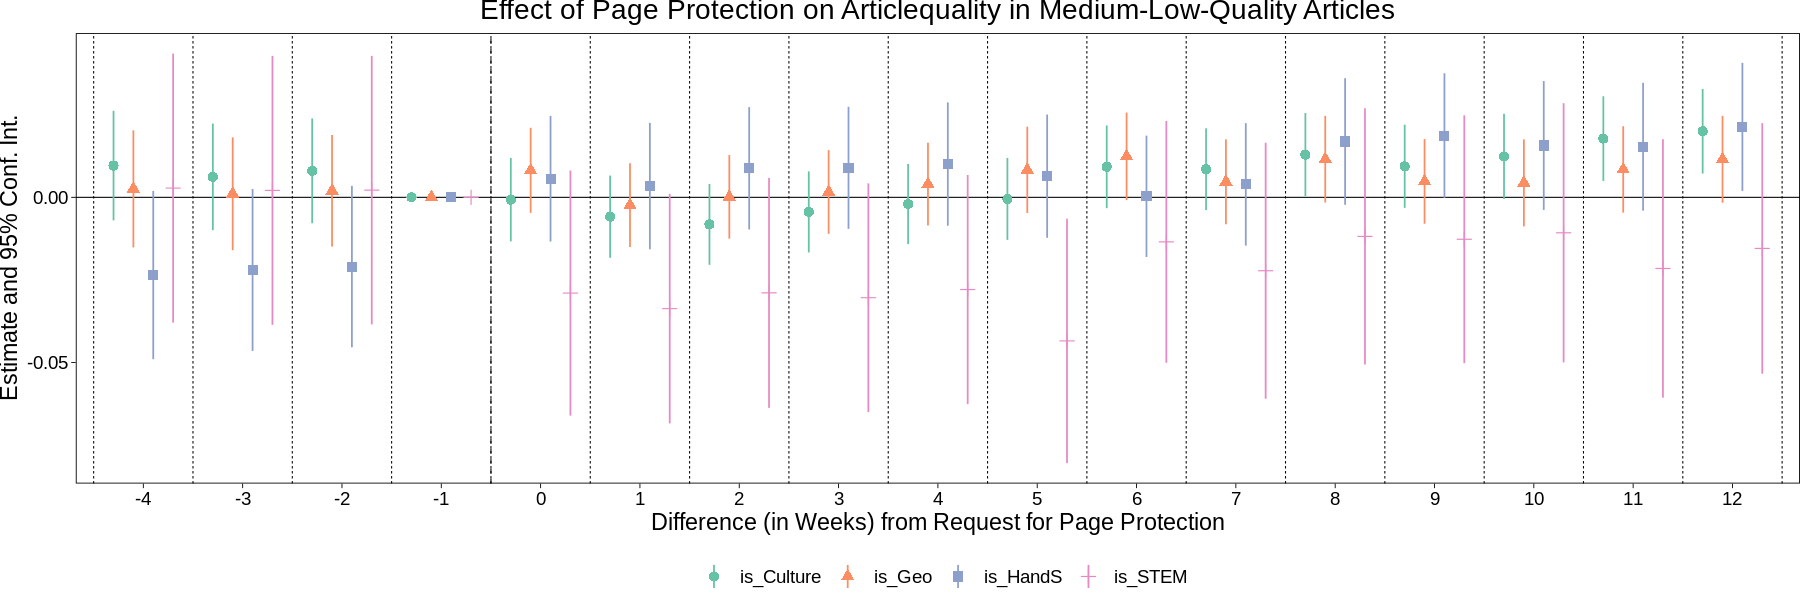

Estimate      Std. Error  t value     Pr(>|t|)  
is_STEM    -0.0055860955 0.010278749 -0.54346063 0.58681843
is_Geo     -0.0004246973 0.005526858 -0.07684245 0.93874902
is_HandS   -0.0100598202 0.008122321 -1.23854009 0.21552285
is_Culture -0.0120900601 0.005676132 -2.12998232 0.03317496

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


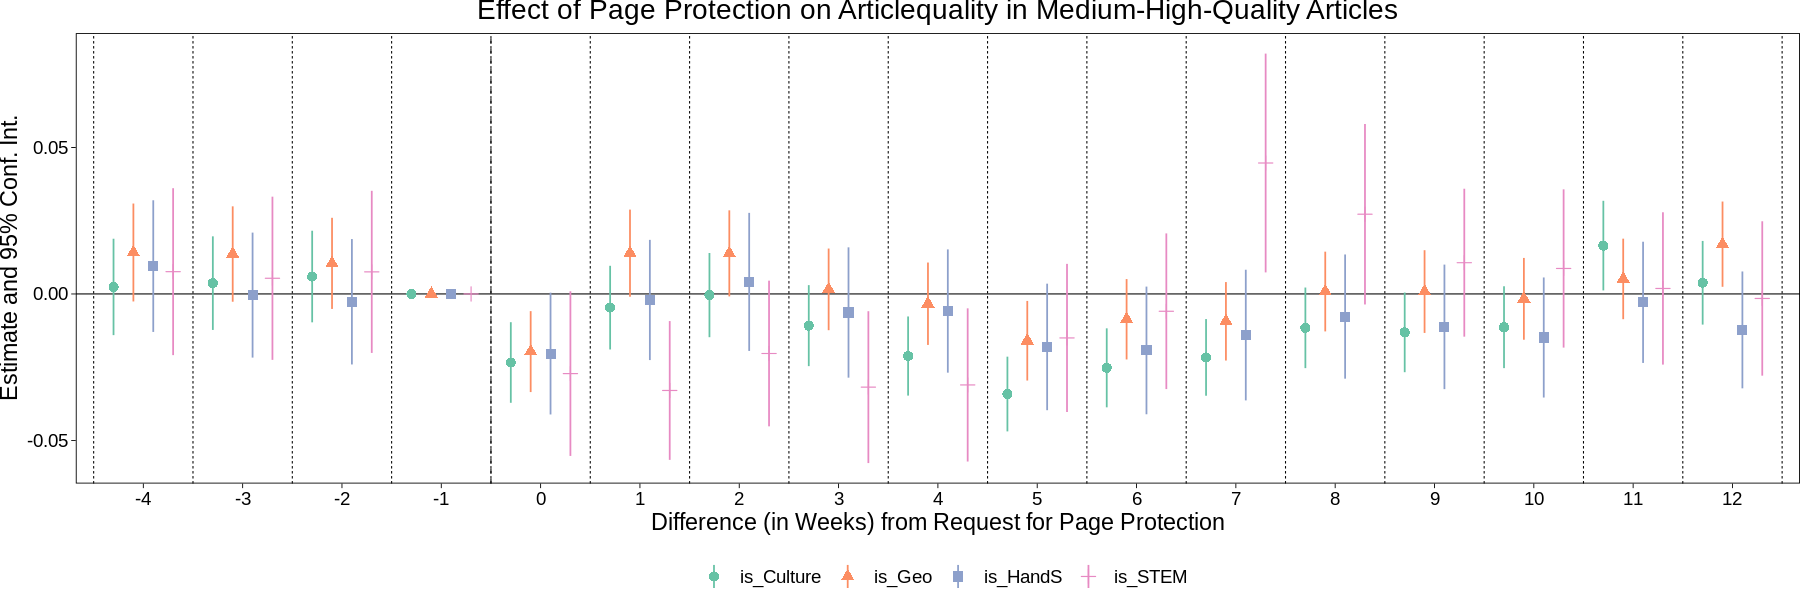

Estimate    Std. Error  t value   Pr(>|t|)    
is_STEM    -0.01909085 0.019811826 -0.963609 3.352554e-01
is_Geo      0.03303213 0.007265462  4.546459 5.461643e-06
is_HandS    0.05611916 0.014348265  3.911216 9.198146e-05
is_Culture  0.01627221 0.006383201  2.549224 1.079748e-02

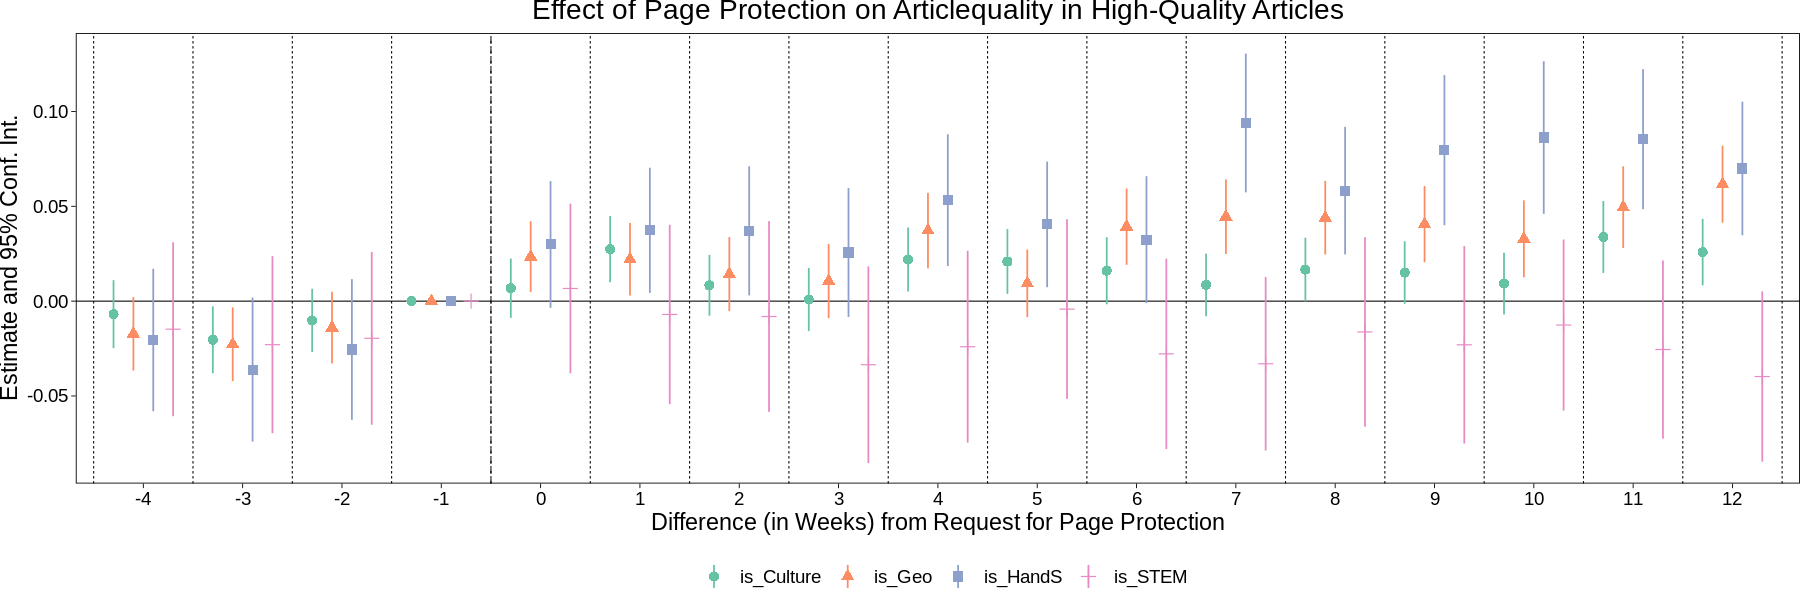

In [425]:
source("matching.r")
rel_durations <- c(unique(df_matched_data_w_1$duration_label))

topics <-  c('is_STEM', 'is_Geo', 'is_HandS', 'is_Culture')
data_sets_weekly_topic <- create_dataset_by_duration_and_topics(
    df_matched_data_w_1, rel_durations, topics, show_plots=FALSE)

did_list_topic <- fit_did(data_sets_weekly_topic, 'articlequality_last', 'request_diff_week')
plot_ggiplot(did_list_topic, -4, 12, title_var='Articlequality')
aggregate_att(did_list_topic, topics)

data_sets_weekly_topic_low <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w_1, (Q_score_quantile == 'low')), 
    rel_durations, topics, show_plots=FALSE)

did_list_topic_low <- fit_did(data_sets_weekly_topic_low, 'articlequality_last', 'request_diff_week')

plot_ggiplot(did_list_topic_low, -4, 12, title_var='Articlequality in Low-Quality Articles')
aggregate_att(did_list_topic_low, topics)



data_sets_weekly_topic_mediumlow <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w_1, (Q_score_quantile == 'medium-low')), 
    rel_durations, topics, show_plots=FALSE)

did_list_topic_ml <- fit_did(data_sets_weekly_topic_mediumlow, 'articlequality_last', 'request_diff_week')
plot_ggiplot(did_list_topic_ml, -4, 12, title_var='Articlequality in Medium-Low-Quality Articles')
aggregate_att(did_list_topic_ml, topics)

data_sets_weekly_topic_mediumhigh<- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w_1, (Q_score_quantile == 'medium-high')), 
    rel_durations, topics, show_plots=FALSE)

did_list_topic_mh <- fit_did(data_sets_weekly_topic_mediumhigh, 'articlequality_last', 'request_diff_week')
plot_ggiplot(did_list_topic_mh, -4, 12, title_var='Articlequality in Medium-High-Quality Articles')
aggregate_att(did_list_topic_mh, topics)


data_sets_weekly_topic_high <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w_1, (Q_score_quantile == 'high')), 
    rel_durations, topics, show_plots=FALSE)

did_list_topic_high <- fit_did(data_sets_weekly_topic_high, 'articlequality_last', 'request_diff_week')
plot_ggiplot(did_list_topic_high, -4, 12, title_var='Articlequality in High-Quality Articles')
aggregate_att(did_list_topic_high, topics)

list_models_1 <- list('all'=did_list_topic, 'high'=did_list_topic_high, 'low'=did_list_topic_low)

write.csv(extract_start_end_coefs_for_models(list_models_1), 'data/experiment/weekly_all_bytopic_1.csv')

In [517]:
names(did_list_topic)

[1] "is_STEM"    "is_Geo"     "is_HandS"   "is_Culture"

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Estimate     Std. Error  t value    Pr(>|t|)    
is_STEM     0.007631208 0.006191499  1.2325300 2.177551e-01
is_Geo     -0.006692097 0.002939506 -2.2766064 2.281016e-02
is_HandS    0.020231713 0.004530063  4.4660998 7.970742e-06
is_Culture -0.001095851 0.002855002 -0.3838355 7.011005e-01

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


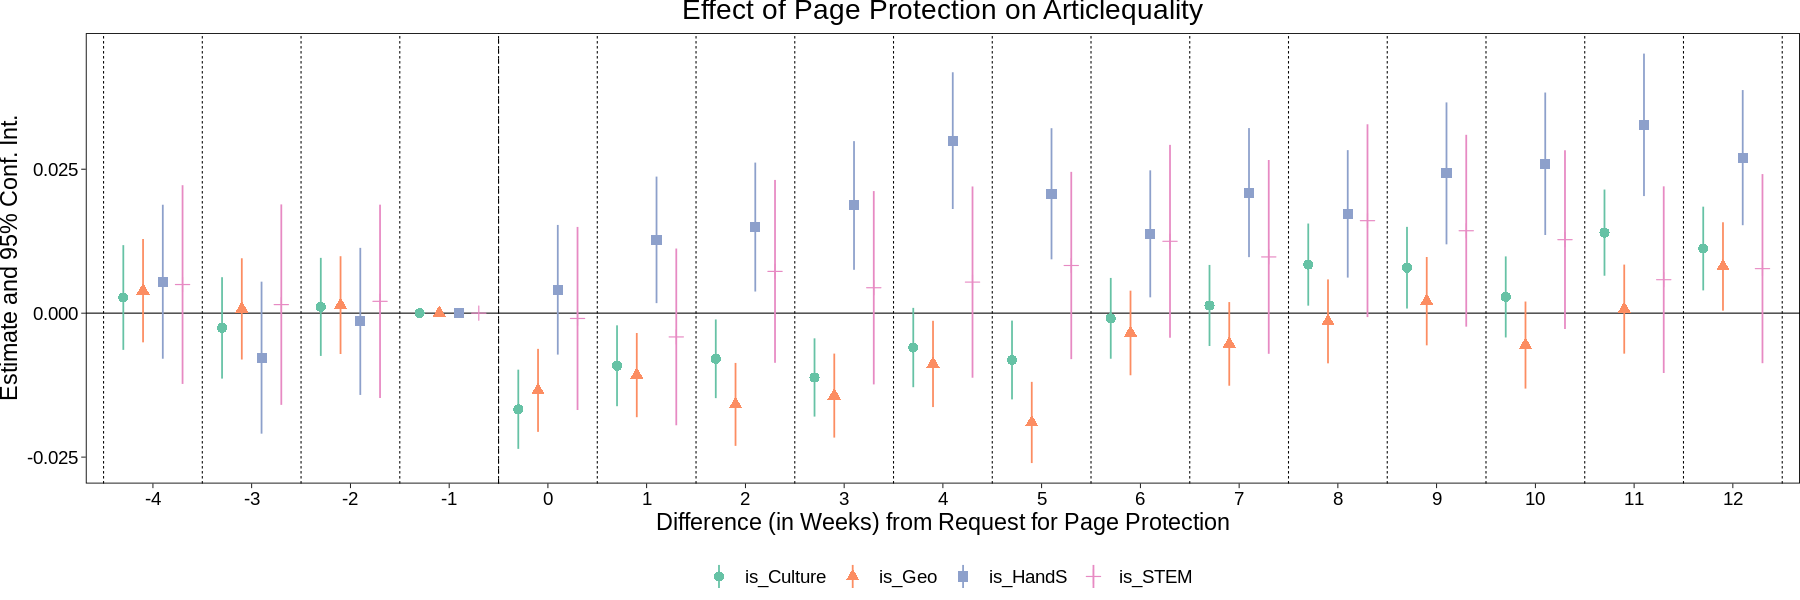

Estimate    Std. Error  t value   Pr(>|t|)    
is_STEM     0.04602773 0.015557177  2.958617 3.096642e-03
is_Geo     -0.05522769 0.006322357 -8.735300 2.459438e-18
is_HandS   -0.01379351 0.009351403 -1.475020 1.402156e-01
is_Culture -0.01976537 0.006650656 -2.971943 2.959699e-03

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


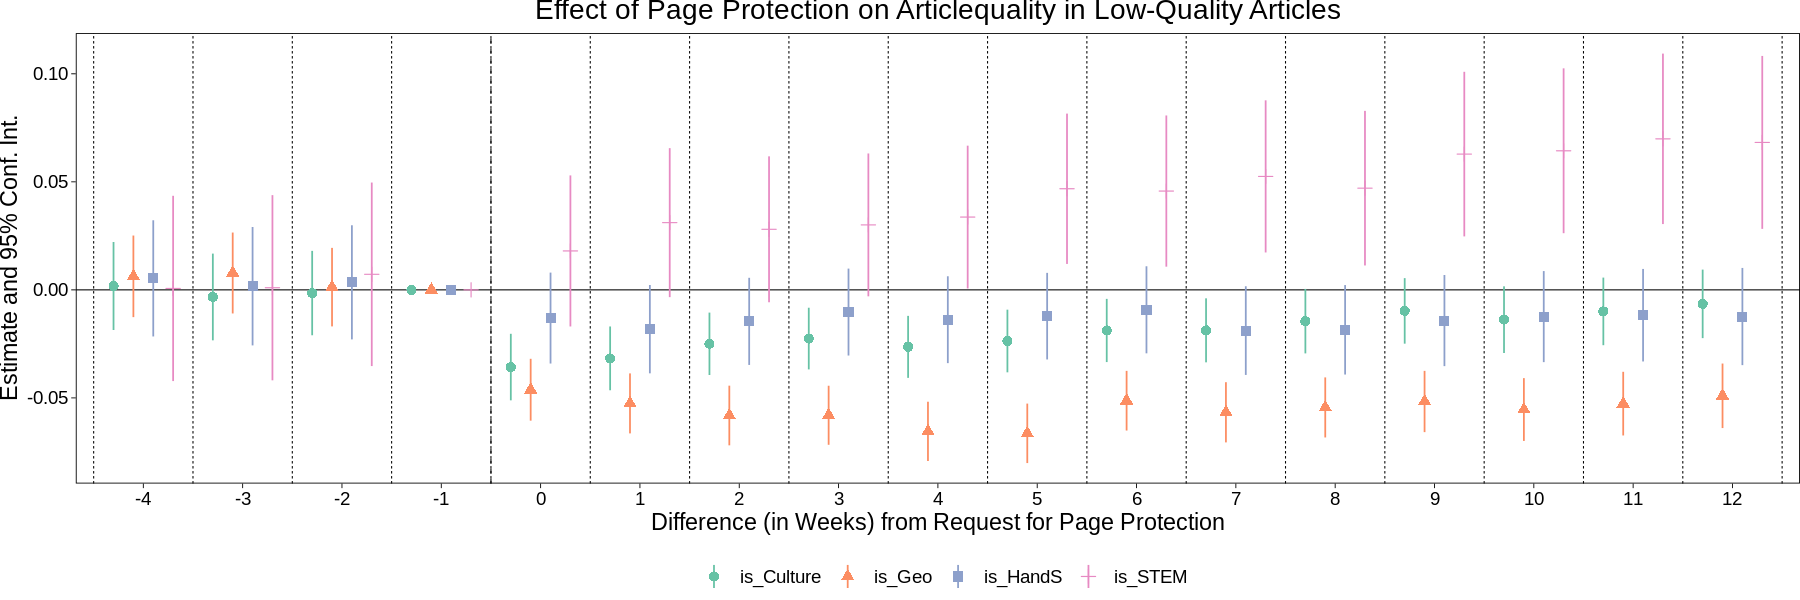

Estimate      Std. Error  t value     Pr(>|t|)  
is_STEM     0.0184994433 0.012655971  1.46171662 0.14384069
is_Geo     -0.0017535336 0.005344174 -0.32812058 0.74282104
is_HandS    0.0164047603 0.007749404  2.11690606 0.03427367
is_Culture -0.0004128591 0.005221685 -0.07906627 0.93698002

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


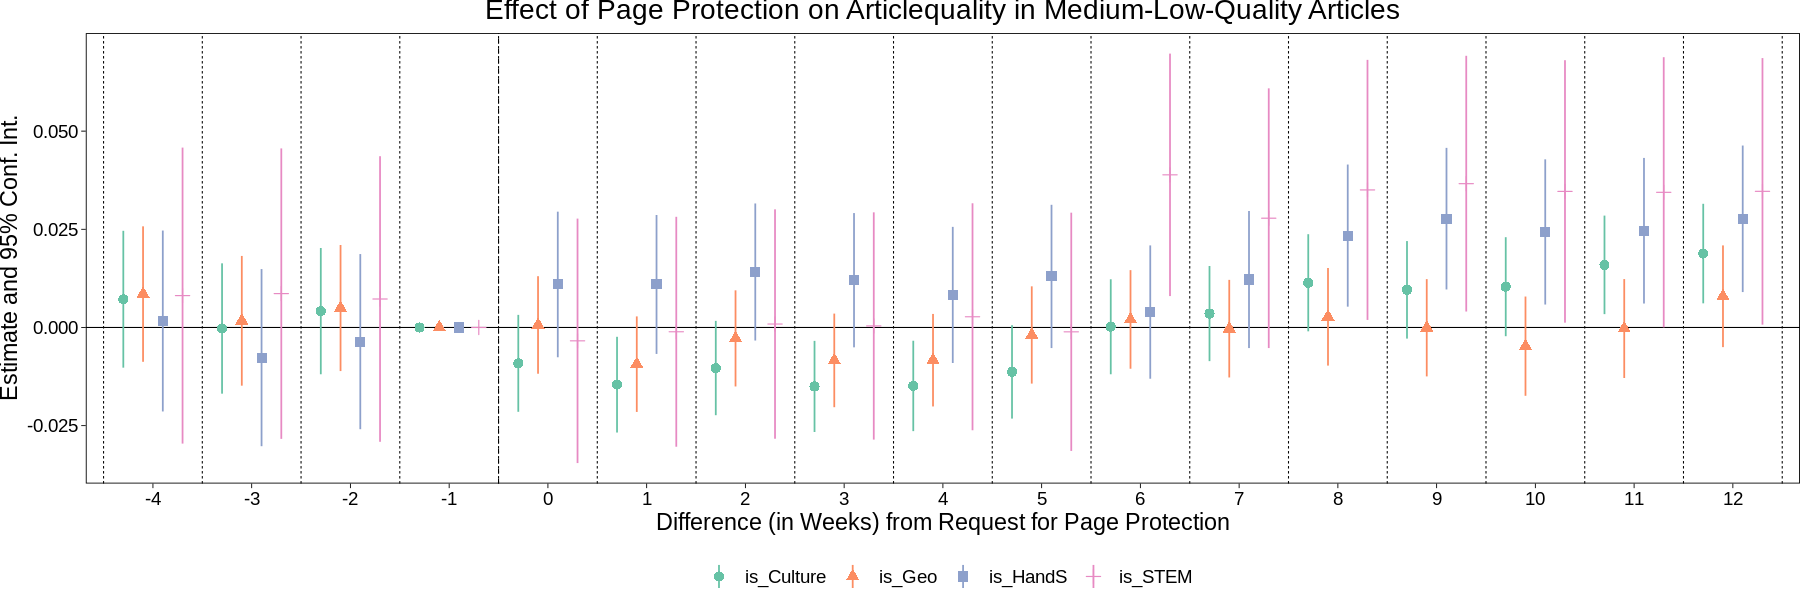

Estimate      Std. Error  t value      Pr(>|t|) 
is_STEM    -1.192382e-02 0.009321289 -1.279202482 0.2008378
is_Geo      3.081662e-03 0.005069251  0.607912795 0.5432464
is_HandS    7.812559e-03 0.006952508  1.123703677 0.2611444
is_Culture  4.421551e-05 0.005033170  0.008784823 0.9929908

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


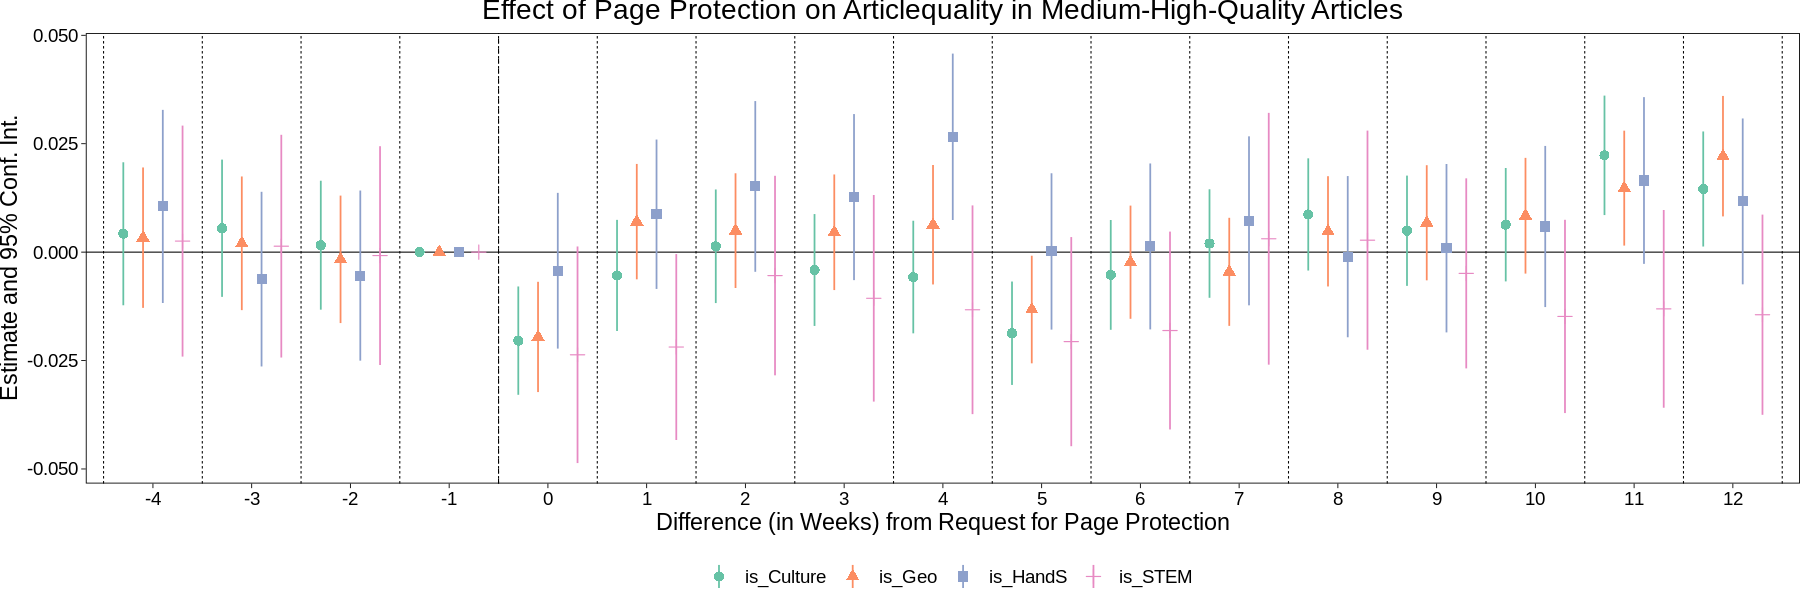

Estimate    Std. Error  t value   Pr(>|t|)    
is_STEM    0.003035836 0.012703250 0.2389811 8.111223e-01
is_Geo     0.028305380 0.006354136 4.4546383 8.411037e-06
is_HandS   0.059656836 0.010761229 5.5436822 2.976442e-08
is_Culture 0.016148914 0.005477755 2.9480897 3.197963e-03

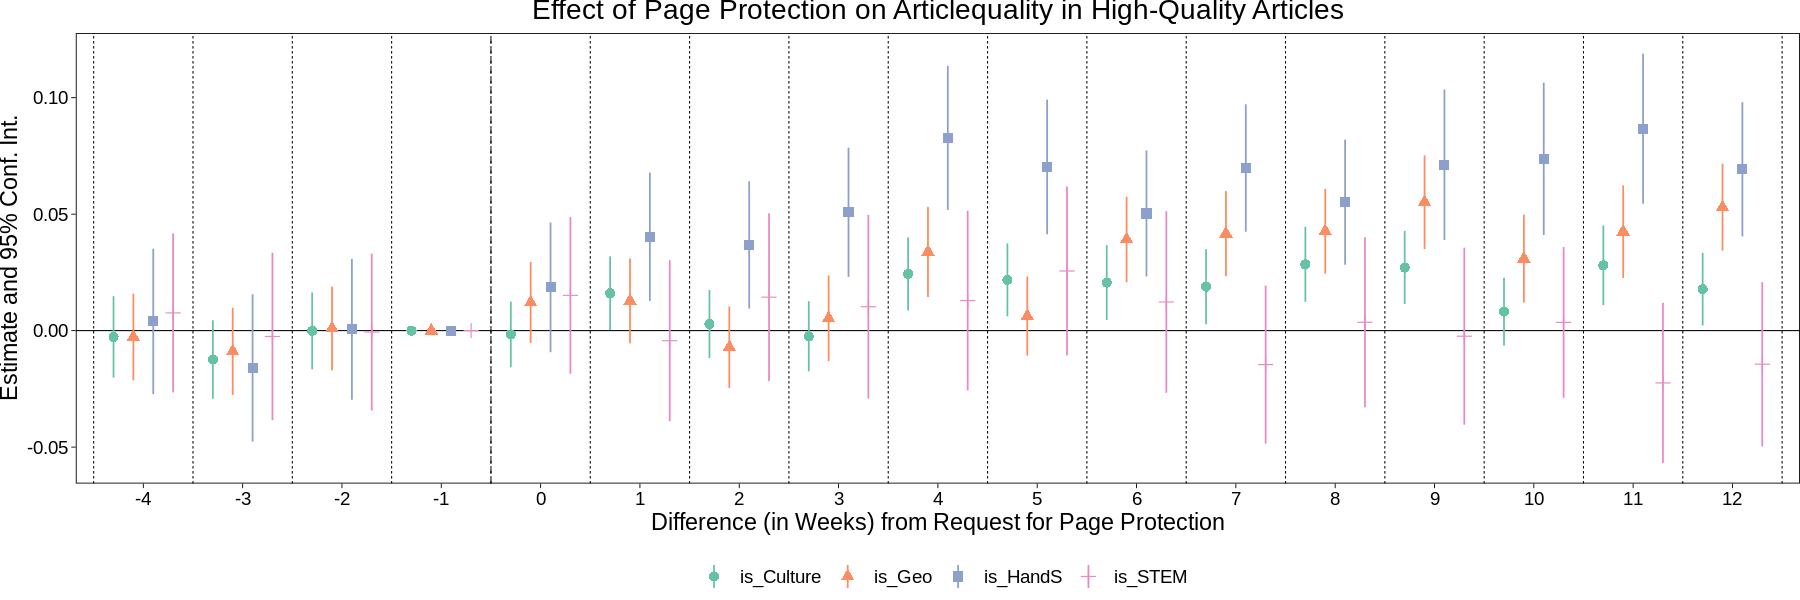

In [ ]:
source("matching.r")
rel_durations <- c(unique(df_matched_data_w_1$duration_label))

topics <-  c('is_STEM', 'is_Geo', 'is_HandS', 'is_Culture')
data_sets_weekly_topic <- create_dataset_by_duration_and_topics(
    df_matched_data_w_last, rel_durations, topics, show_plots=FALSE)

did_list_topic <- fit_did(data_sets_weekly_topic, 'articlequality_last', 'request_diff_week')
plot_ggiplot(did_list_topic, -4, 12, title_var='Articlequality')
aggregate_att(did_list_topic, topics)

data_sets_weekly_topic_low <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w_last, (Q_score_quantile == 'low')), 
    rel_durations, topics, show_plots=FALSE)

did_list_topic_low <- fit_did(data_sets_weekly_topic_low, 'articlequality_last', 'request_diff_week')

plot_ggiplot(did_list_topic_low, -4, 12, title_var='Articlequality in Low-Quality Articles')
aggregate_att(did_list_topic_low, topics)



data_sets_weekly_topic_mediumlow <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w_last, (Q_score_quantile == 'medium-low')), 
    rel_durations, topics, show_plots=FALSE)

did_list_topic_ml <- fit_did(data_sets_weekly_topic_mediumlow, 'articlequality_last', 'request_diff_week')
plot_ggiplot(did_list_topic_ml, -4, 12, title_var='Articlequality in Medium-Low-Quality Articles')
aggregate_att(did_list_topic_ml, topics)

data_sets_weekly_topic_mediumhigh<- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w_last, (Q_score_quantile == 'medium-high')), 
    rel_durations, topics, show_plots=FALSE)

did_list_topic_mh <- fit_did(data_sets_weekly_topic_mediumhigh, 'articlequality_last', 'request_diff_week')
plot_ggiplot(did_list_topic_mh, -4, 12, title_var='Articlequality in Medium-High-Quality Articles')
aggregate_att(did_list_topic_mh, topics)


data_sets_weekly_topic_high <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w_last, (Q_score_quantile == 'high')), 
    rel_durations, topics, show_plots=FALSE)

did_list_topic_high <- fit_did(data_sets_weekly_topic_high, 'articlequality_last', 'request_diff_week')
plot_ggiplot(did_list_topic_high, -4, 12, title_var='Articlequality in High-Quality Articles')
aggregate_att(did_list_topic_high, topics)

list_models_1 <- list('all'=did_list_topic, 'high'=did_list_topic_high, 'low'=did_list_topic_low)

#write.csv(extract_start_end_coefs_for_models(list_models_1), 'data/experiment/weekly_all_bytopic_1.csv')

In [475]:
etable(did_list_topic_low)

is_STEM                 
1  Dependent Var.:                  articlequality_last_norm
2                                                           
3  treated x request_diff_week = -4 -0.0363 (0.0290)        
4  treated x request_diff_week = -3 -0.0362 (0.0290)        
5  treated x request_diff_week = -2 -0.0350 (0.0288)        
6  treated x request_diff_week = 0  -0.0398 (0.0252)        
7  treated x request_diff_week = 1  -0.0304 (0.0248)        
8  treated x request_diff_week = 2  -0.0263 (0.0245)        
9  treated x request_diff_week = 3  0.0203 (0.0266)         
10 treated x request_diff_week = 4  0.0288 (0.0266)         
11 treated x request_diff_week = 5  0.0105 (0.0253)         
12 treated x request_diff_week = 6  0.0104 (0.0254)         
13 treated x request_diff_week = 7  0.0115 (0.0254)         
14 treated x request_diff_week = 8  0.0039 (0.0258)         
15 treated x request_diff_week = 9  0.0185 (0.0268)         
16 treated x request_diff_week = 10 0.0137 (0.0267)         
17 treated x request_diff_week = 11 0.0245 (0.0270)         
18 treated x request_diff_week = 12 0.0219 (0.0272)         
19 Fixed-Effects:                   ------------------------
20 request_diff_week                Yes                     
21 treated_id                       Yes                     
22 ________________________________ ________________________
23 S.E. type                        Heteroskedasticity-robu.
24 Observations                     10,676                  
25 R2                               0.89580                 
26 Within R2                        0.00454                 
   is_Geo                   is_HandS                 is_Culture              
1  articlequality_last_norm articlequality_last_norm articlequality_last_norm
2                                                                            
3  0.0144 (0.0101)          -0.0011 (0.0150)         0.0046 (0.0103)         
4  0.0147 (0.0101)          -0.0022 (0.0151)         -0.0005 (0.0101)        
5  0.0080 (0.0099)          3.48e-6 (0.0148)         4.73e-7 (0.0099)        
6  -0.0480*** (0.0076)      -0.0313** (0.0115)       -0.0386*** (0.0078)     
7  -0.0532*** (0.0074)      -0.0361** (0.0111)       -0.0357*** (0.0075)     
8  -0.0668*** (0.0074)      -0.0349** (0.0109)       -0.0400*** (0.0073)     
9  -0.0675*** (0.0073)      -0.0363*** (0.0108)      -0.0387*** (0.0073)     
10 -0.0731*** (0.0073)      -0.0421*** (0.0109)      -0.0414*** (0.0073)     
11 -0.0772*** (0.0074)      -0.0403*** (0.0108)      -0.0408*** (0.0074)     
12 -0.0662*** (0.0074)      -0.0374*** (0.0109)      -0.0343*** (0.0074)     
13 -0.0763*** (0.0075)      -0.0469*** (0.0111)      -0.0420*** (0.0075)     
14 -0.0724*** (0.0075)      -0.0425*** (0.0112)      -0.0376*** (0.0076)     
15 -0.0702*** (0.0076)      -0.0393*** (0.0115)      -0.0327*** (0.0077)     
16 -0.0689*** (0.0077)      -0.0362** (0.0114)       -0.0328*** (0.0078)     
17 -0.0661*** (0.0078)      -0.0356** (0.0116)       -0.0295*** (0.0079)     
18 -0.0615*** (0.0079)      -0.0386** (0.0122)       -0.0264** (0.0080)      
19 ------------------------ ------------------------ ------------------------
20 Yes                      Yes                      Yes                     
21 Yes                      Yes                      Yes                     
22 ________________________ ________________________ ________________________
23 Heteroskedasticity-robu. Heteroskedasticity-robu. Heteroskedasticity-robu.
24 125,902                  36,074                   146,234                 
25 0.88265                  0.90293                  0.86026                 
26 0.00673                  0.00245                  0.00135

# Size

Retrieve protection with duration ( 07 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( 22-35 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( 36-92 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( 01-06 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( 08-21 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( 22-35 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( 08-21 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( 07 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( 01-06 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( 36-92 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( 07 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( 01-06 Days ) and topic ( ) and quality ( )
Retrieve protection with duration ( 08-21 Days ) and topic ( 

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


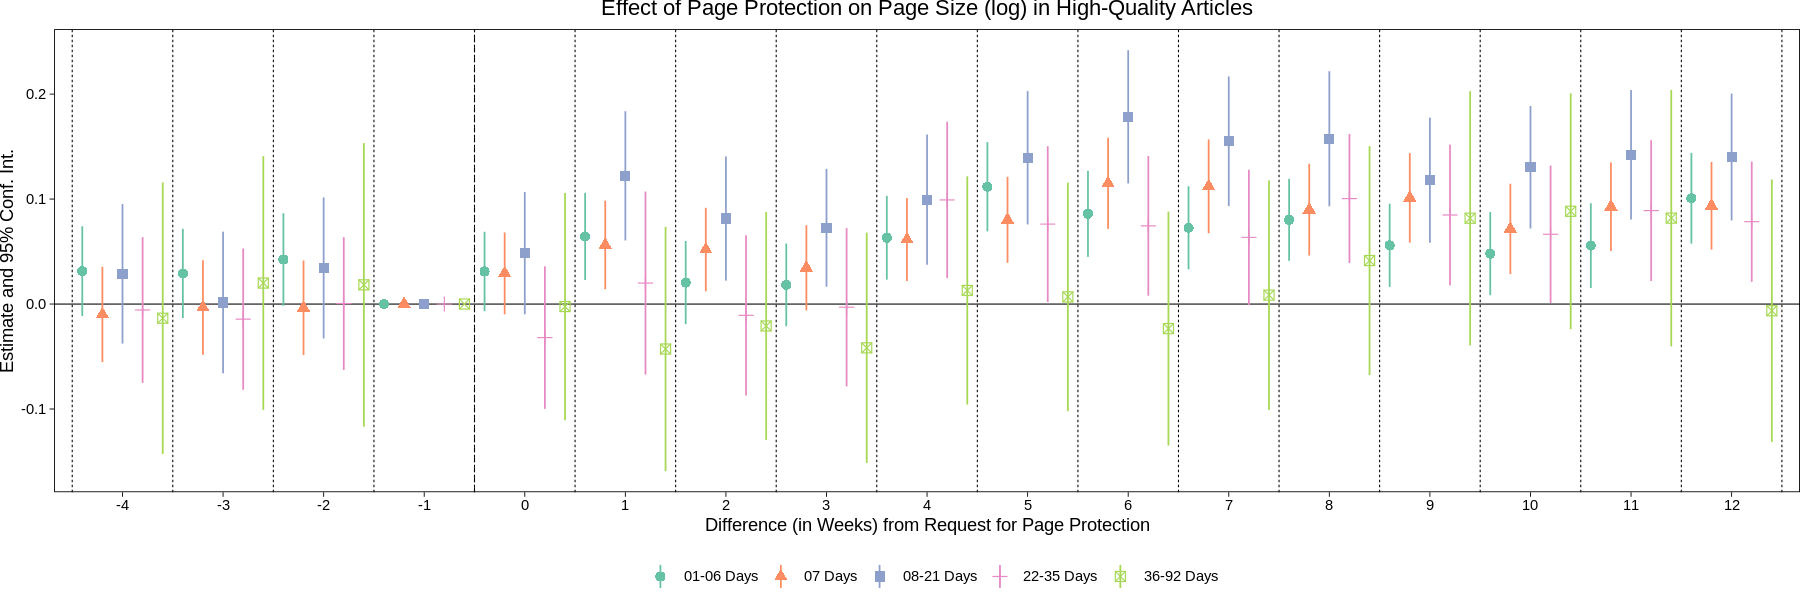

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


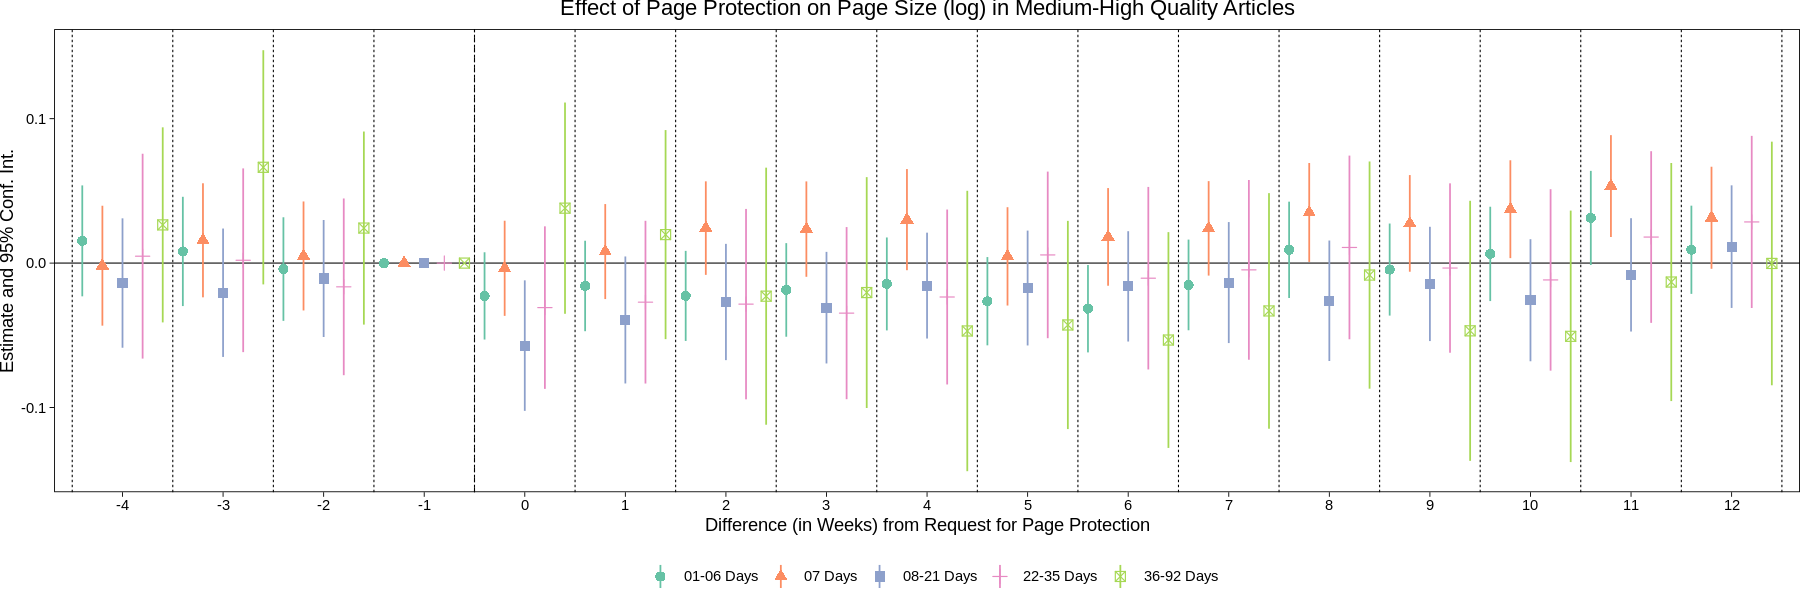

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


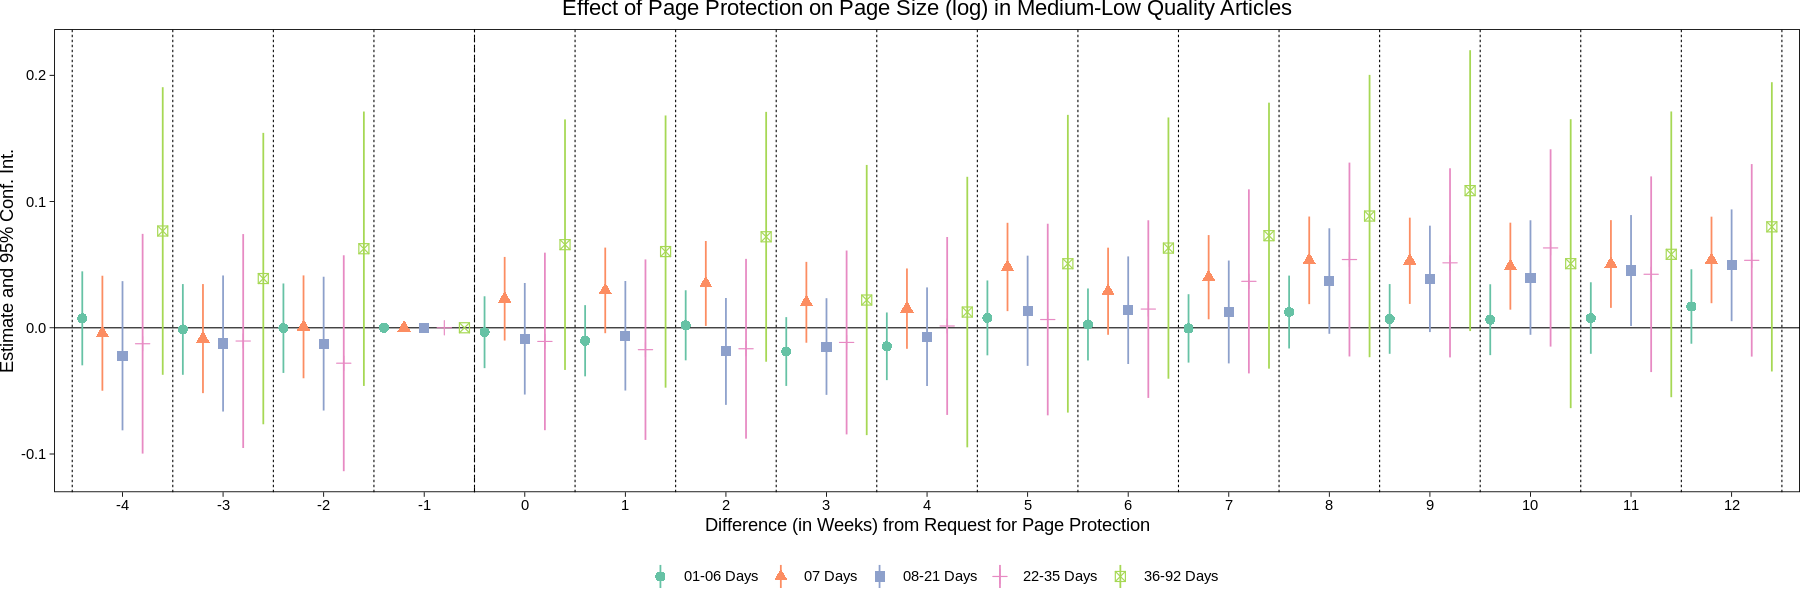

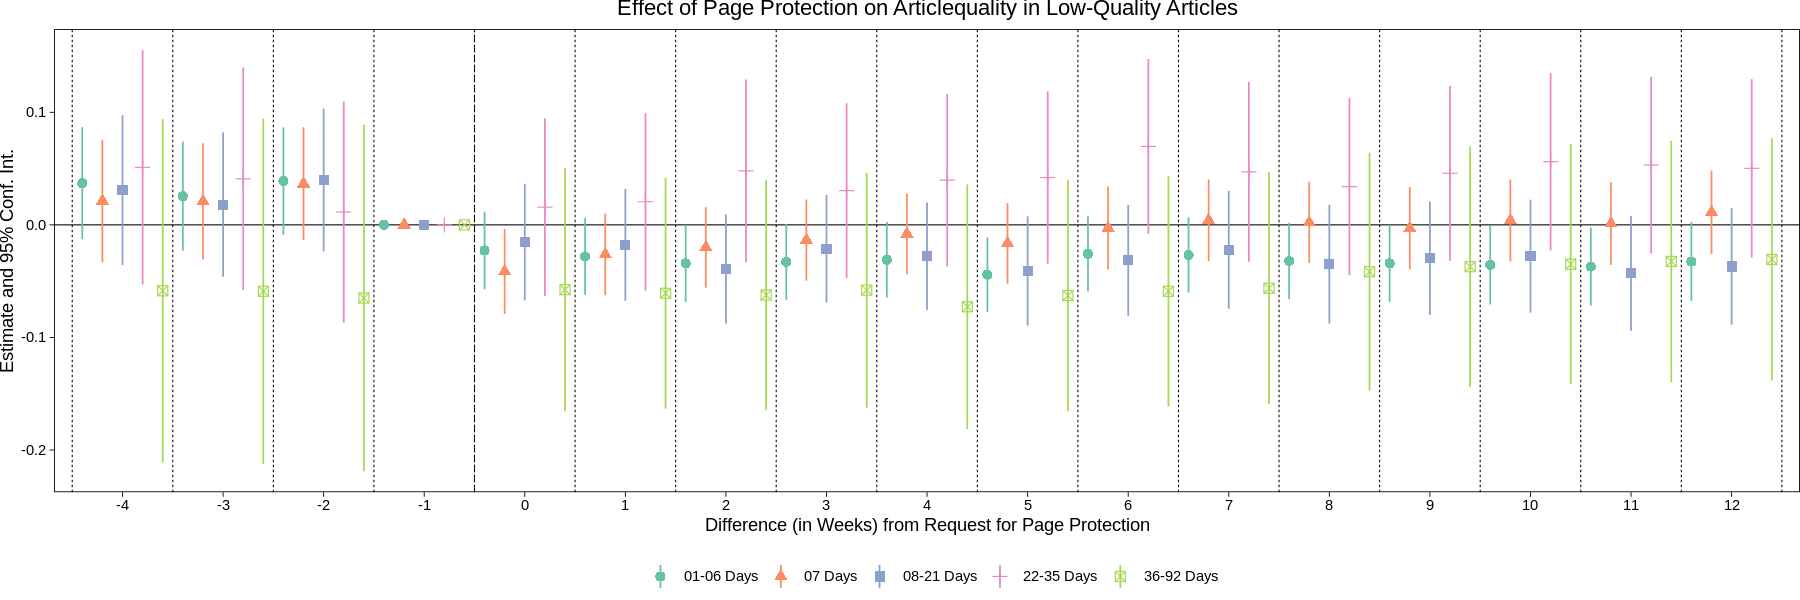

In [456]:
source('matching.r')
data_sets_weekly_high <- create_dataset_by_duration_labels(
    filter(df_matched_data_w, (Q_score_quantile == 'high')), 
    target_var = "page_size_last_log", show_plots=FALSE)


data_sets_weekly_mediumhigh <- create_dataset_by_duration_labels(
    filter(df_matched_data_w, (Q_score_quantile == 'medium-high')), 
    target_var = "page_size_last_log", show_plots=FALSE)

data_sets_weekly_mediumlow <- create_dataset_by_duration_labels(
    filter(df_matched_data_w, (Q_score_quantile == 'medium-low')), 
    target_var = "page_size_last_log", show_plots=FALSE)

data_sets_weekly_low <- create_dataset_by_duration_labels(
    filter(df_matched_data_w, (Q_score_quantile == 'low')), 
    target_var = "page_size_last_log", show_plots=FALSE)

did_weekly_high <- fit_did(data_sets_weekly_high, 'page_size_last_log', 'request_diff_week')
plot_ggiplot(did_weekly_high, -4, 12, title='Effect of Page Protection on Page Size (log) in High-Quality Articles')
#ggsave("figures/did_weekly-high.pdf", width=5, height=2, scale=1.8, title='Effect of Page Protection on Articlequality')

did_weekly_mediumhigh <- fit_did(data_sets_weekly_mediumhigh, 'page_size_last_log', 'request_diff_week')
plot_ggiplot(did_weekly_mediumhigh, -4, 12, title='Effect of Page Protection on Page Size (log) in Medium-High Quality Articles')

did_weekly_mediumlow <- fit_did(data_sets_weekly_mediumlow, 'page_size_last_log', 'request_diff_week')
plot_ggiplot(did_weekly_mediumlow, -4, 12, title='Effect of Page Protection on Page Size (log) in Medium-Low Quality Articles')

did_weekly_low <- fit_did(data_sets_weekly_low, 'page_size_last_log', 'request_diff_week')
plot_ggiplot(did_weekly_low, -4, 12, title='Effect of Page Protection on Articlequality in Low-Quality Articles')
#ggsave("figures/did_weekly-low.pdf", width=5, height=2, scale=1.8, title='Effect of Page Protection on Articlequality')

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Estimate    Std. Error  t value  Pr(>|t|)    
is_STEM    0.017691875 0.009875085 1.791567 0.0732064505
is_Geo     0.004015525 0.004911860 0.817516 0.4136339912
is_HandS   0.022126525 0.007270996 3.043122 0.0023417178
is_Culture 0.018457748 0.004578127 4.031724 0.0000553761

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


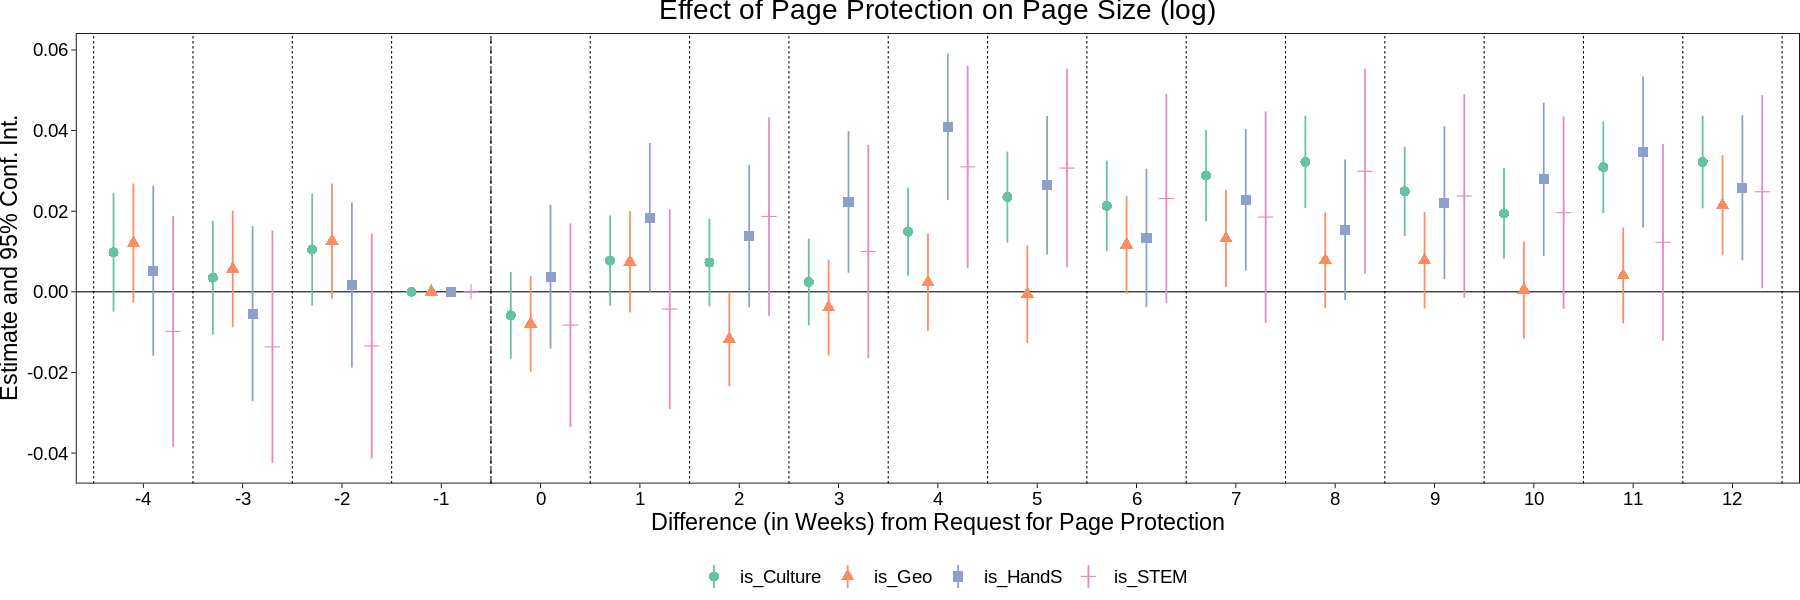

Estimate    Std. Error t value    Pr(>|t|)    
is_STEM     0.08280070 0.03927837  2.1080482 3.504881e-02
is_Geo     -0.09034672 0.01129086 -8.0017552 1.237040e-15
is_HandS   -0.04068018 0.01612705 -2.5224806 1.165722e-02
is_Culture -0.01120974 0.01123803 -0.9974825 3.185320e-01

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


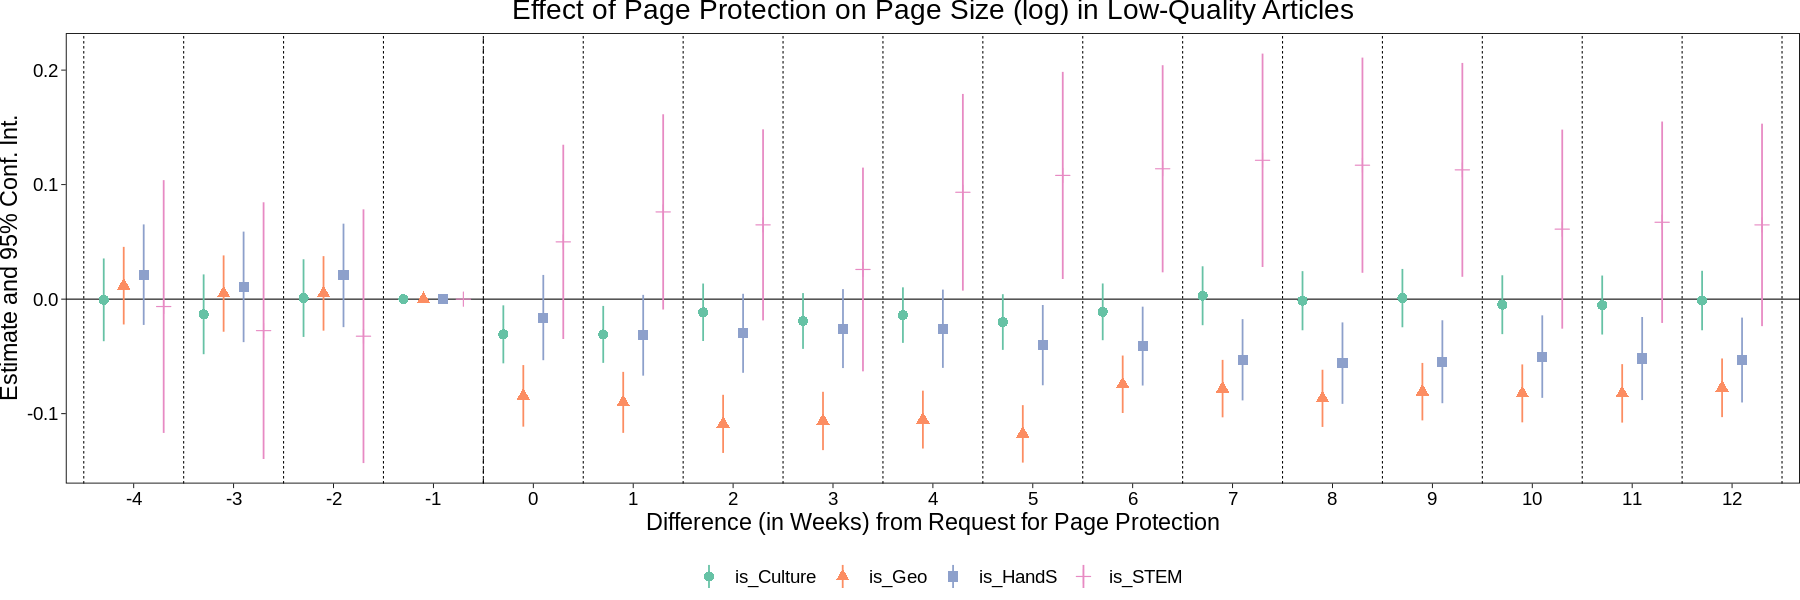

Estimate     Std. Error  t value    Pr(>|t|)   
is_STEM     0.005023036 0.013192036  0.3807627 0.703384918
is_Geo      0.024381265 0.008270169  2.9480975 0.003197948
is_HandS   -0.004446929 0.009379517 -0.4741106 0.635423491
is_Culture  0.018528857 0.008210921  2.2566113 0.024033775

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


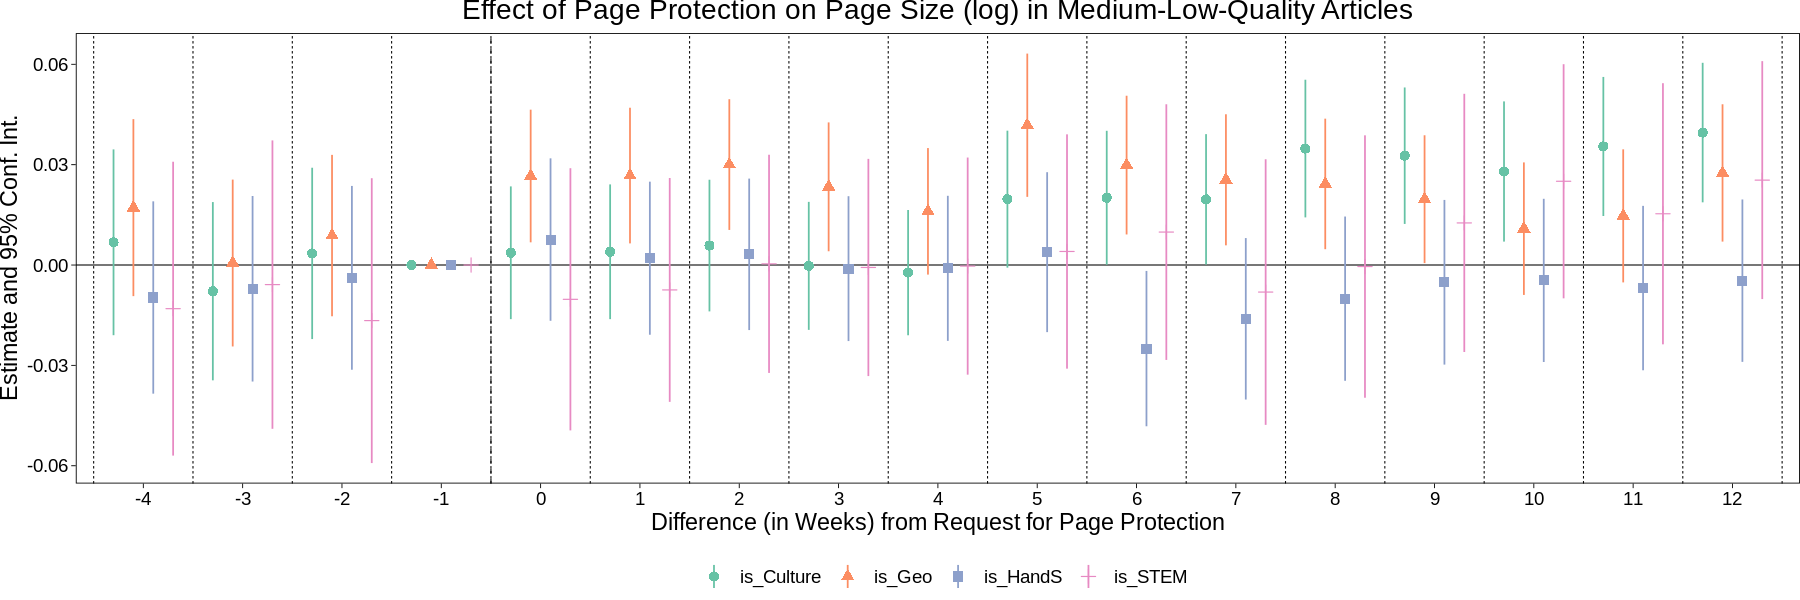

Estimate     Std. Error  t value    Pr(>|t|)  
is_STEM    -0.004790821 0.014168928 -0.3381216 0.73527441
is_Geo      0.015837496 0.008814877  1.7966780 0.07238921
is_HandS   -0.009244783 0.009029782 -1.0238102 0.30593012
is_Culture  0.012914167 0.008252771  1.5648280 0.11762548

Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_STEM ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Geo ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_HandS ) and quality ( )
Retrieve protection with duration ( Protected for 07 Days Protected for 01-06 Days Protected for 08-92 Days ) and topic ( is_Culture ) and quality ( )


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


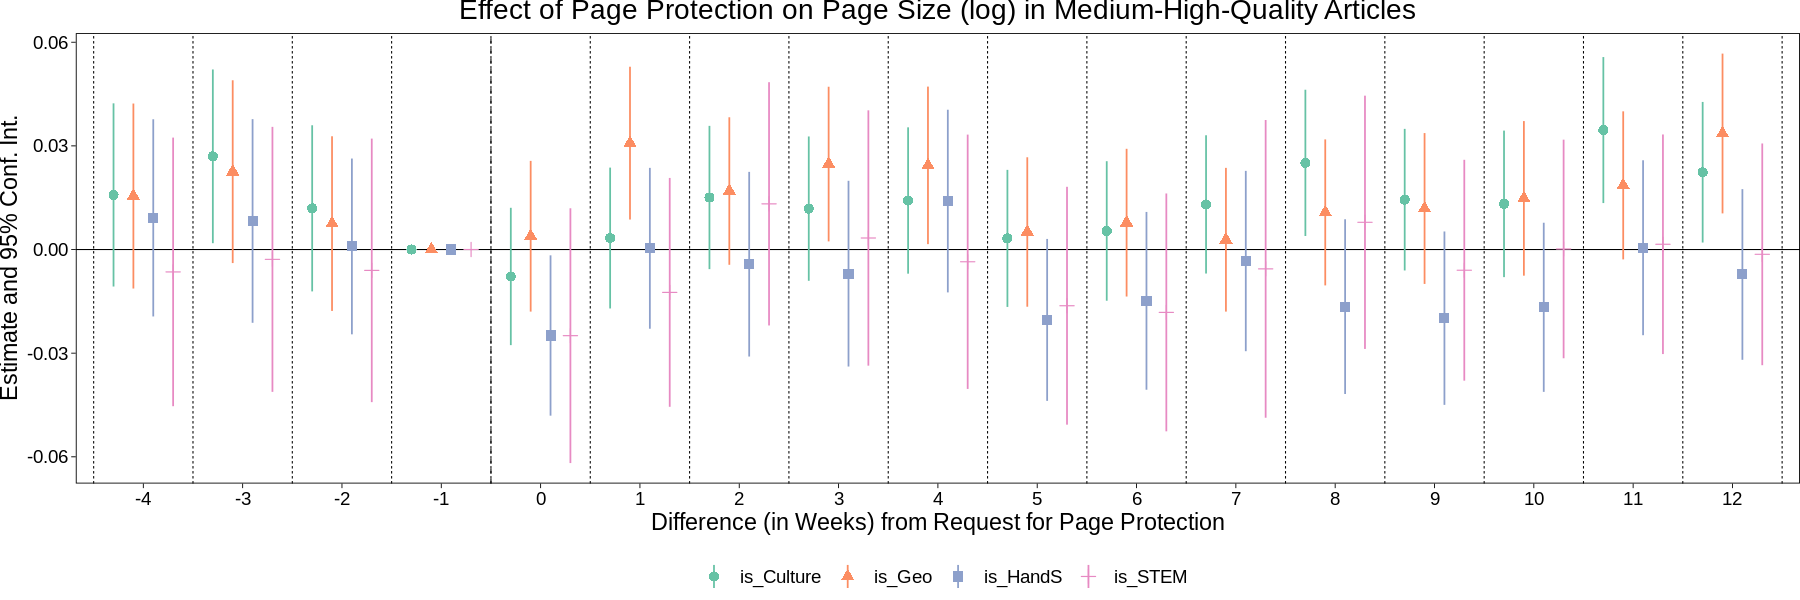

Estimate   Std. Error  t value   Pr(>|t|)    
is_STEM    0.01771441 0.017858408 0.9919366 3.212385e-01
is_Geo     0.06810670 0.010460336 6.5109480 7.497051e-11
is_HandS   0.11902641 0.019192626 6.2016739 5.629470e-10
is_Culture 0.05433358 0.008497808 6.3938346 1.622758e-10

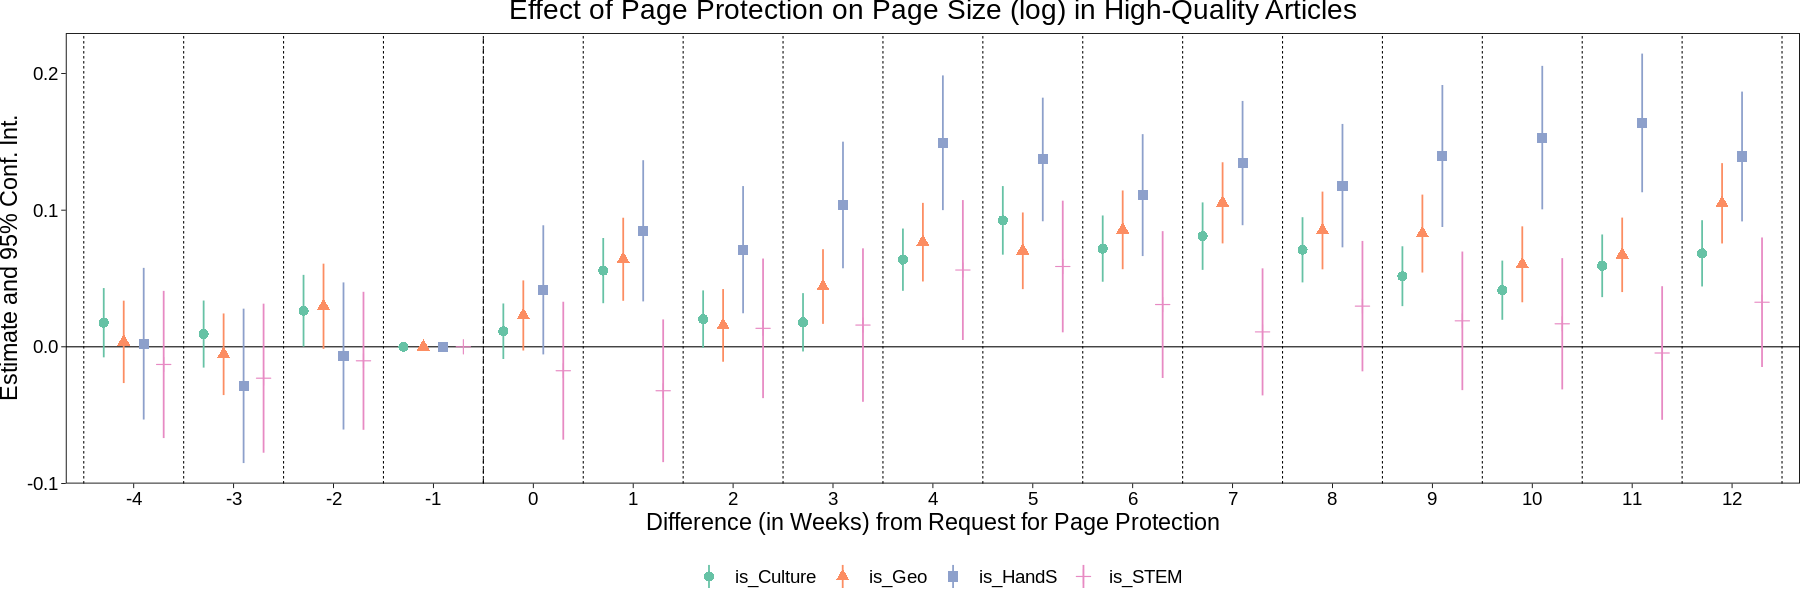

In [481]:
source("matching.r")
rel_durations <- c(unique(df_matched_data_w$duration_label))

topics <-  c('is_STEM', 'is_Geo', 'is_HandS', 'is_Culture')
data_sets_weekly_topic <- create_dataset_by_duration_and_topics(
    df_matched_data_w_last, rel_durations, topics, show_plots=FALSE)

did_list_topic <- fit_did(data_sets_weekly_topic, 'page_size_last_log', 'request_diff_week')
plot_ggiplot(did_list_topic, -4, 12, title_var='Page Size (log)')
aggregate_att(did_list_topic, topics)

data_sets_weekly_topic_low <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w_last, (Q_score_quantile == 'low')), 
    rel_durations, topics, show_plots=FALSE)

did_list_topic_low <- fit_did(data_sets_weekly_topic_low, 'page_size_last_log', 'request_diff_week')

plot_ggiplot(did_list_topic_low, -4, 12, title_var='Page Size (log) in Low-Quality Articles')
aggregate_att(did_list_topic_low, topics)



data_sets_weekly_topic_mediumlow <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w_last, (Q_score_quantile == 'medium-low')), 
    rel_durations, topics, show_plots=FALSE)

did_list_topic_ml <- fit_did(data_sets_weekly_topic_mediumlow, 'page_size_last_log', 'request_diff_week')
plot_ggiplot(did_list_topic_ml, -4, 12, title_var='Page Size (log) in Medium-Low-Quality Articles')
aggregate_att(did_list_topic_ml, topics)

data_sets_weekly_topic_mediumhigh<- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w_last, (Q_score_quantile == 'medium-high')), 
    rel_durations, topics, show_plots=FALSE)

did_list_topic_mh <- fit_did(data_sets_weekly_topic_mediumhigh, 'page_size_last_log', 'request_diff_week')
plot_ggiplot(did_list_topic_mh, -4, 12, title_var='Page Size (log) in Medium-High-Quality Articles')
aggregate_att(did_list_topic_mh, topics)


data_sets_weekly_topic_high <- create_dataset_by_duration_and_topics(
       filter(df_matched_data_w_last, (Q_score_quantile == 'high')), 
    rel_durations, topics, show_plots=FALSE)

did_list_topic_high <- fit_did(data_sets_weekly_topic_high, 'page_size_last_log', 'request_diff_week')
plot_ggiplot(did_list_topic_high, -4, 12, title_var='Page Size (log) in High-Quality Articles')
aggregate_att(did_list_topic_high, topics)
